![Logo](../Img/Poule_qui_chante.png){ width=200px }


# Récapitulatif de la Phase Précédente

Dans le premier notebook, nous avons accompli les tâches suivantes :

   - Préparation et nettoyage des données, en utilisant les sources de données de la FAO ainsi que d'autres données en open data.
   - Analyse exploratoire des données pour identifier des tendances et des insights préliminaires.

# Objectif de ce Notebook

Dans ce deuxième notebook, nous allons poursuivre notre mission d'analyse en mettant en œuvre des techniques de clustering, notamment la Classification Ascendante Hiérarchique (CAH) et la méthode des K-Means. Ces méthodes nous permettront de regrouper les pays en fonction de leurs caractéristiques similaires et de fournir des visualisations associées pour mieux comprendre les résultats.

La section suivante de ce notebook sera dédiée à la présentation de nos résultats et à la formulation de recommandations pour la suite du projet. Vous y trouverez des informations clés sur les groupes de pays identifiés et leur pertinence pour l'expansion internationale de l'entreprise.

## <span style="color:indianred"> Partie IV - Analyses </span>

### <span style="color:lightseagreen">Importation librairie</span>

In [2]:
suppressWarnings({
    library(data.table)
    library(ggplot2)
    library(FactoMineR)
    library(factoextra)
    library(dplyr)
    library(corrplot)
    library(cluster)
    library(pheatmap)
    library(gridExtra)
})

### <span style="color:lightseagreen"> Importation des fichiers </span>

In [2]:
# importer tous les fichiers
Fichier_final <- fread("../Data/Data_5_ans/Fichier_final.csv")
Fichier_numérique <- fread("../Data/Data_5_ans/Fichier_numérique3.csv")

#supprimer des colonnes
Fichier_final[ ,c("Pop_total", "Importation_Qté","Dispo_Poulet", "PIB", "Pop_Assainissement_sécu", 
                         "Pop_Assainissement_base", "Stabilité_Pol", "ID") := NULL]
Fichier_numérique$V1 <- NULL

# Définir la colonne "Zone" comme index
#setDT(Fichier_final, key = "Zone")
#rownames(Fichier_final) <- Fichier_final$Zone
#Fichier_final$Zone <- NULL

# Afficher le fichier
head(Fichier_numérique)
head(Fichier_final)


# gérer la taille des visuels dans le notebook
options(repr.plot.width=10, repr.plot.height=10)


Warning message in `[.data.table`(Fichier_final, , `:=`(c("Pop_total", "Importation_Qté", :
"Column 'ID' does not exist to remove"


Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2870362,23050.38,32180.28,13248.75,47.45,98.88,0.24
42679711,5.62,263055.24,11406.38,17.95,86.22,-0.92
83081350,482983.66,919105.15,52977.78,97.07,99.00,0.60
35397224,640715.39,1329242.95,46571.40,57.25,99.00,-0.63
2821132,35786.65,44138.53,12775.98,66.95,93.75,-0.51
25303574,2151.42,1171442.17,48853.85,72.83,99.00,0.91


V1,Zone
<int>,<chr>
1,Albanie
2,Algérie
3,Allemagne
4,Arabie saoudite
5,Arménie
6,Australie


### <span style="color:lightseagreen"> ACP - Analyse en composante principales </span>

Le PCA est une technique d'analyse de données qui permet de simplifier la représentation des données multidimensionnelles tout en conservant les informations les plus importantes : Donc il permet de réduire le nombre de dimensions et la redondance dans les données.

####  <span style="color:navy">Etape 1 - Figer le noyau pour se baser sur les mêmes échantillons dans l'ensemble des analyses</span>

In [3]:
set.seed(5) #Je fige le 5ème scénario

####  <span style="color:navy">Etape 2 - Standardiser les données en centrée réduites (meme unité) </span>

In [4]:
#données centrée réduites (meme unité)
res.pca <- PCA(Fichier_numérique, scale.unit=TRUE)
summary(res.pca)

#méthode 2, mais n'a pas vraiment les mêmes résultats: # res.pca.v2 <- PCA(Fichier_final[, -1], scale.unit=TRUE, graph = FALSE)


Call:
PCA(X = Fichier_numérique, scale.unit = TRUE) 


Eigenvalues
                       Dim.1   Dim.2   Dim.3   Dim.4   Dim.5   Dim.6   Dim.7
Variance               2.908   1.523   0.903   0.566   0.507   0.341   0.252
% of var.             41.545  21.753  12.900   8.091   7.243   4.870   3.598
Cumulative % of var.  41.545  63.298  76.198  84.288  91.532  96.402 100.000

Individuals (the 10 first)
                            Dist    Dim.1    ctr   cos2    Dim.2    ctr   cos2
1                       |  1.162 | -0.168  0.009  0.021 | -0.580  0.211  0.249
2                       |  1.949 | -1.563  0.800  0.643 | -0.164  0.017  0.007
3                       |  3.154 |  2.325  1.771  0.544 |  0.867  0.470  0.076
4                       |  3.697 |  1.140  0.426  0.095 |  1.277  1.020  0.119
5                       |  1.091 | -0.255  0.021  0.055 | -0.360  0.081  0.109
6                       |  1.690 |  1.363  0.609  0.651 | -0.227  0.032  0.018
7                       |  2.205 |  1.993  

####  <span style="color:navy">Etape 3 - Réaliser le tableau des valeurs propres </span>

In [5]:
eigenvalue <- get_eigenvalue(res.pca)
eigenvalue

,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,2.9081323,41.544747,41.54475
Dim.2,1.5227388,21.753412,63.29816
Dim.3,0.9029666,12.899522,76.19768
Dim.4,0.5663503,8.090718,84.28840
Dim.5,0.5070237,7.243195,91.53159
Dim.6,0.3408955,4.869935,96.40153
Dim.7,0.2518929,3.598470,100.00000


- Sur ce tableau, on peut déjà voir qu'avec une seule dimension, on peut expliquer 41.5% de la situation (variance cumulé). L'objectif est d'obtenir un modèle qui nous permet d'expliquer 80% de la situation. Donc le choix va résider entre prendre 3 dimensions avec 76% ou 4 dimensions avec 84%, mais on va justifier ce choix par les différents méthodes ci-dessous: 



####  <span style="color:navy">Etape 4 - Déterminer le nombre de composantes principales à retenir pour l'ACP </span>

 - <span style="color:indigo">Méthode 1: Eboulies des valeurs propres - Eigenvalue </span>

In [6]:
#transformer en data frame les valeurs
# créer une nouvelle colonne de 1à8
eigenvalue <- as.data.frame(eigenvalue)
eigenvalue$Dim = c(1,2,3,4,5,6,7) #rajouter une colonne Dim
eigenvalue

#eigenvalue : valeur propre
# variance.percent: pourcentage d'inertie
#cumulative variance.percente: pourcentage d'inertie cumulée

,eigenvalue,variance.percent,cumulative.variance.percent,Dim
,<dbl>,<dbl>,<dbl>,<dbl>
Dim.1,2.9081323,41.544747,41.54475,1
Dim.2,1.5227388,21.753412,63.29816,2
Dim.3,0.9029666,12.899522,76.19768,3
Dim.4,0.5663503,8.090718,84.28840,4
Dim.5,0.5070237,7.243195,91.53159,5
Dim.6,0.3408955,4.869935,96.40153,6
Dim.7,0.2518929,3.598470,100.00000,7


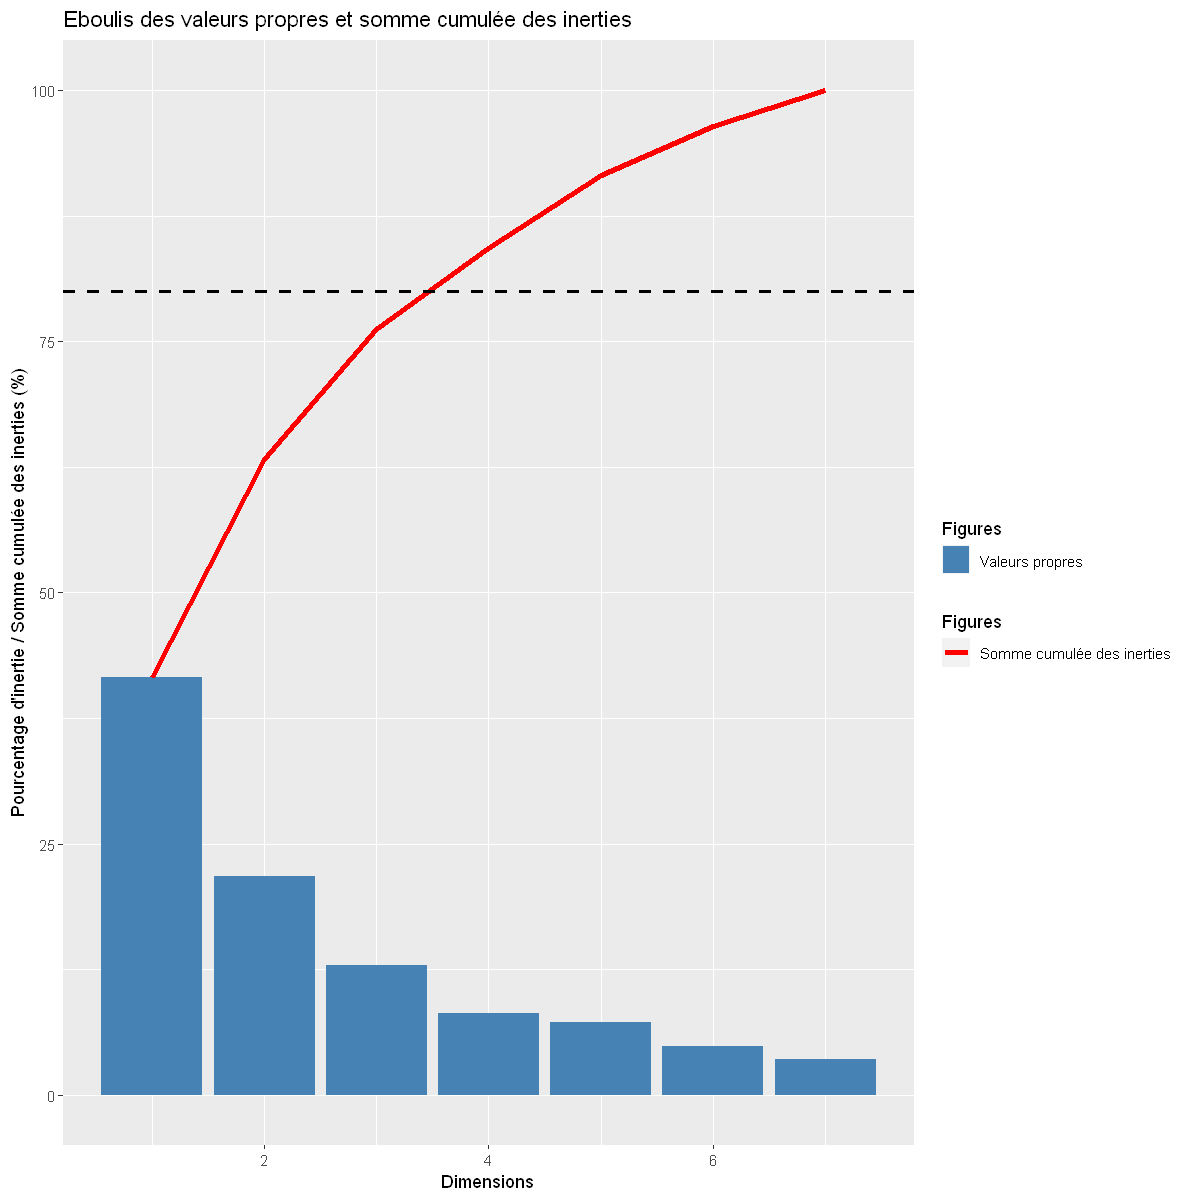

In [7]:

ggplot() +
  
  # Ajouter la figure de l'ébouli des valeurs propres
  geom_bar(data = eigenvalue, aes(x = Dim, y = variance.percent, fill = "Valeurs propres"), 
           stat = "identity") +
  
  # Ajouter la courbe de la somme cumulée des inerties
  geom_line(data = eigenvalue, aes(x = Dim, y = cumulative.variance.percent, 
                                        color = "Somme cumulée des inerties"), size = 1.5) +
  
  # Ajouter une ligne horizontale à 80%
  geom_hline(yintercept = 80, linetype = "dashed", size = 1) +
  
  # Ajouter des étiquettes pour les axes et le titre du graphique
  labs(x = "Dimensions", y = "Pourcentage d'inertie / Somme cumulée des inerties (%)", 
       title = "Eboulis des valeurs propres et somme cumulée des inerties") +
  
  # Ajouter une légende pour les figures
  scale_fill_manual(values = "steelblue", name = "Figures") +
  scale_color_manual(values = "red", name = "Figures")


- Sur ce graphique, on a tendance à pencher sur 3 dimensions avec lesquels on garde 80% de l'inertie totale.
  L'inertie mesure la quantité totale d'information contenue dans les données. En d'autres termes, on peut résumer 80% des informations contenues dans les données avec 3 dimensions.

 - <span style="color:indigo">Méthode 2: Aide à la décision par l'histogramme de coude - scree plot (Saut d'escalier)  </span>

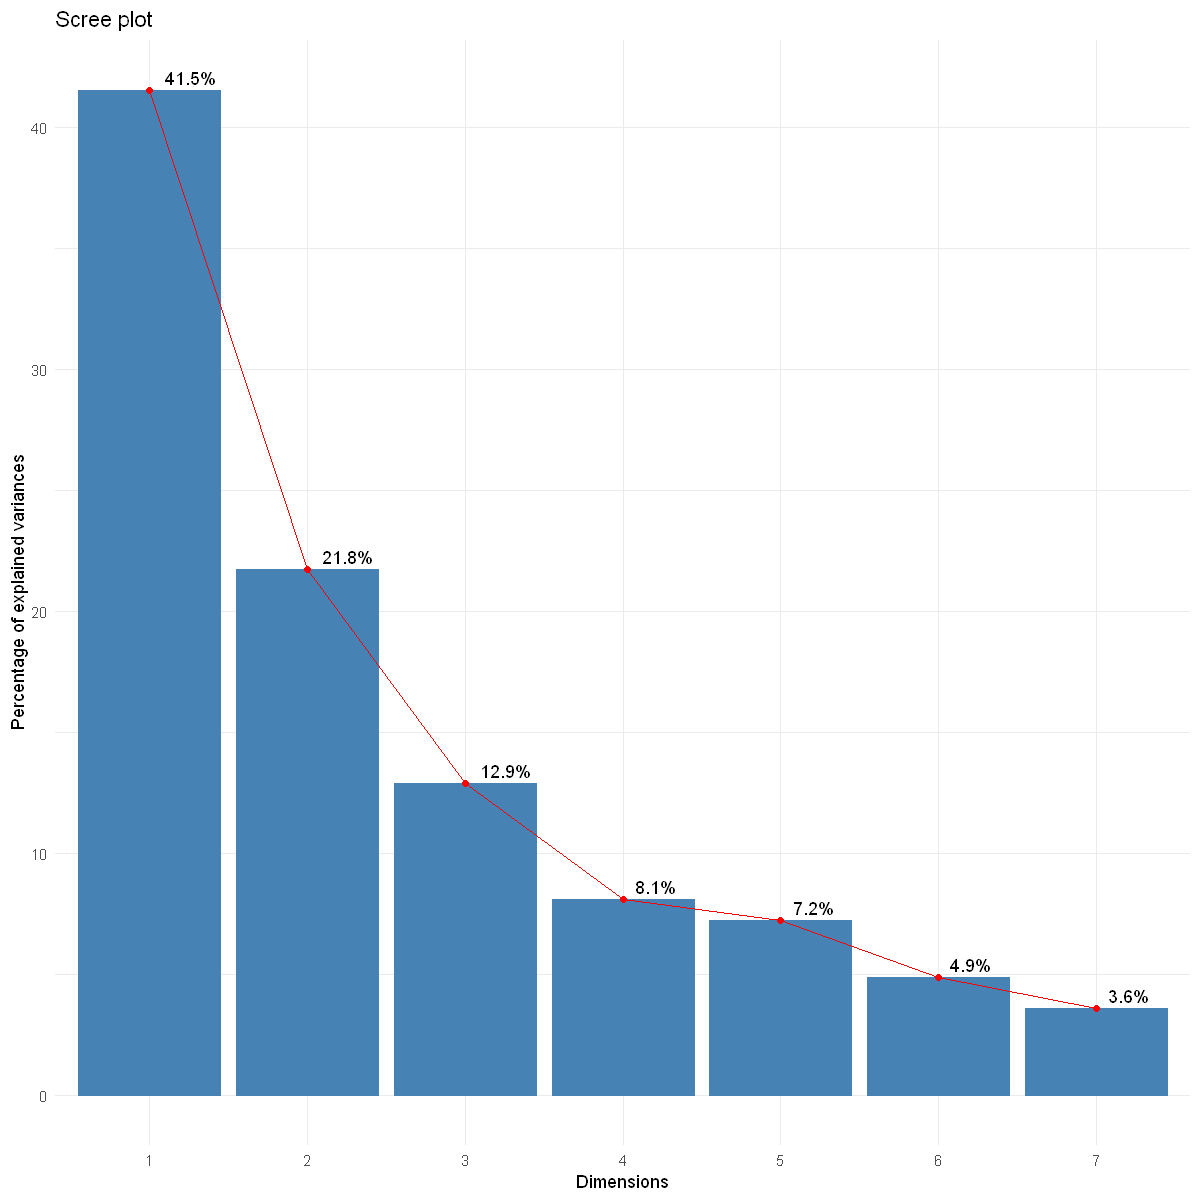

In [8]:
fviz_eig(res.pca, addlabels=TRUE, hjust = -0.3,
               linecolor ="red") + theme_minimal()

Les points représentent la quantité d'information conservé dans chaque composante. D'après ce graphique, on constate une légère courbe de "coude" à la troisième dimension, mais il n'est pas très prononcé. Par conséquent, il peut être difficile de décider combien de dimensions garder en utilisant uniquement l'histogramme de coude. On va voir une dernière méthode.


- <span style="color:indigo"> Méthode 3 : méthode de Kaiser ou de critère de Kaiser-Guttman  </span>

La méthode de Kaiser consiste à extraire tous les facteurs dont l'eigenvalue est supérieur à 1.  Les facteurs avec des eigenvalues supérieurs à 1 sont considérés comme significatifs et sont conservés.

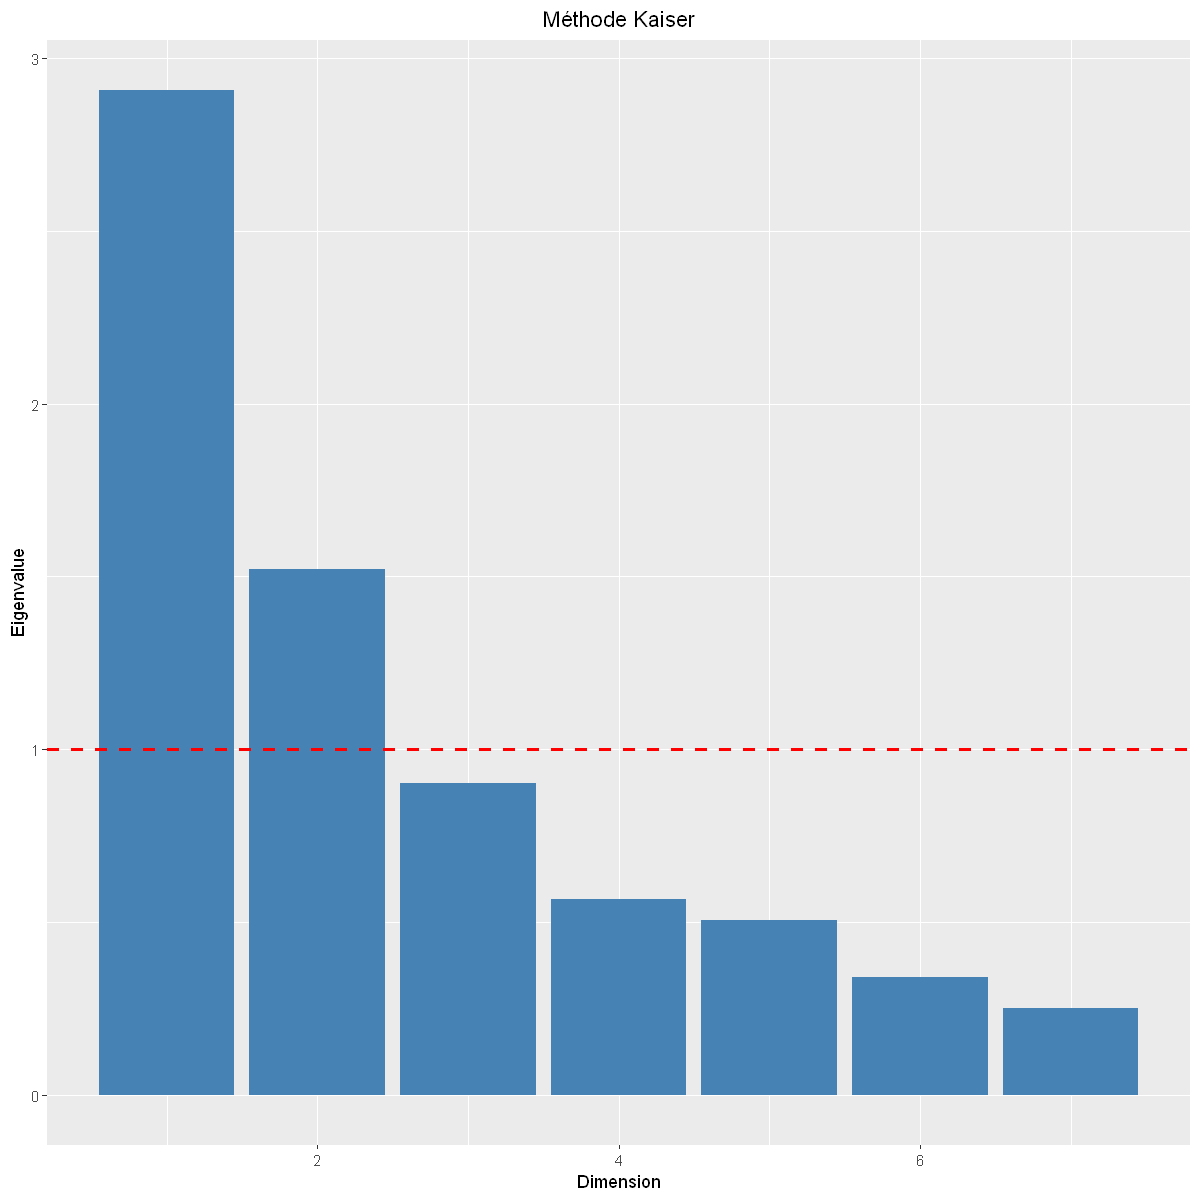

In [9]:
ggplot(eigenvalue, aes(x = Dim, y = eigenvalue)) + 
  geom_bar(stat = "identity", fill = "steelblue") + #identity: les hauteurs déterminées par les valeurs d'eigenvalue
  #scale_y_continuous(limits = c(0, max(eigenvalue$eigenvalue)*1.2)) +
  geom_hline(yintercept = 1, linetype = "dashed", color = "red", size= 1) +
  labs(x = "Dimension", y = "Eigenvalue") +
  ggtitle("Méthode Kaiser") +
  theme(plot.title = element_text(hjust = 0.5))

#scale_y_continuous() limite l'axe y à partir de zéro et étend un peu au-delà de la plus grande valeur d'eigenvalue.
#geom_hline() ajoute une ligne horizontale pointillée à y = 1 pour indiquer le seuil de la méthode Kaiser.
#labs() ajoute des étiquettes pour les axes x et y.
#ggtitle() ajoute un titre pour le graphique.
#theme() permet de personnaliser l'apparence du graphique. Ici, nous centrons le titre en utilisant hjust = 0.5.


La méthode Kaiser est la plus sévère de toutes. Avec cette méthode, les facteurs avec des eigenvalues supérieurs à 1 sont considérés comme significatifs et sont conservés.
Donc d'après ce graphique, le nombre optimal de composantes principales à conserver pour représenter les données est de 2 dimensions.

<span style="color:firebrick">Après l'analyse des différentes méthodes,  aucune des méthodes ne justifie de garder 4 dimensions. 
Je vais me baser sur le diagramme de coude qui suggère de garder 3 dimensions puisqu'il représente un compromis entre la fiabilité du modèle et le nombre de dimensions. Avec 3 dimesions, on pourra expliquer jusqu'à 76% des informations. Ce qui est bien mieux que 63% (avec 2 dimensions).</span>


####  <span style="color:navy">Etape 5 - Résultats de l'ACP sur les variables et représentations graphiques</span>

 - <span style="color:indigo"> Contribution des variables sur les axes </span>

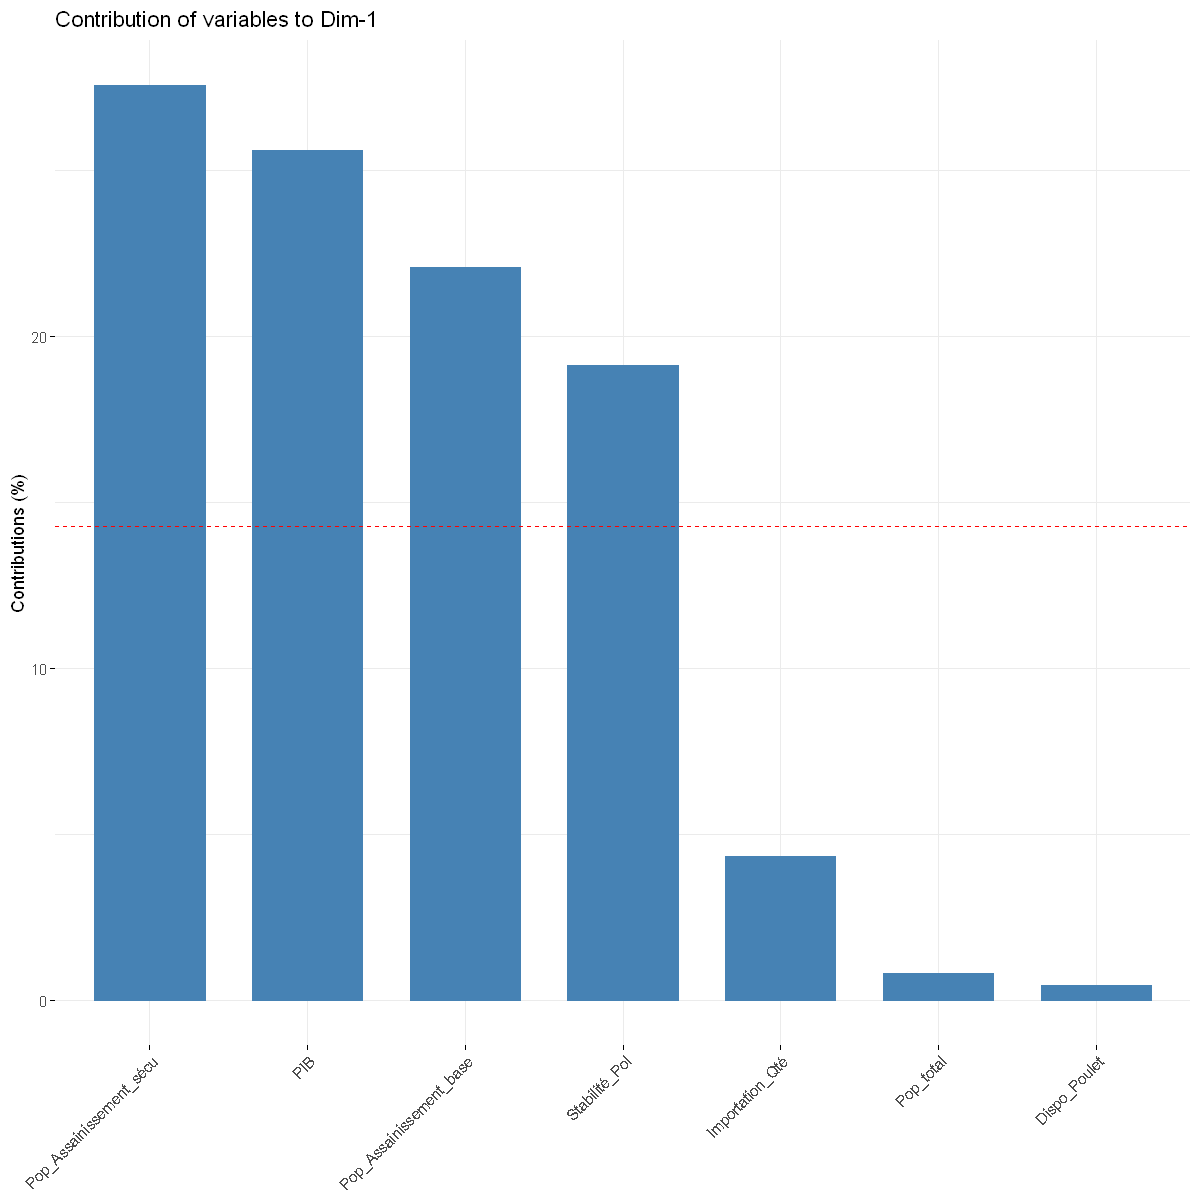

In [10]:
# Visualiser les contributions des variables sur les dimensions + Cercle de corrélations
fviz_contrib(res.pca, choice = "var", axes = 1)


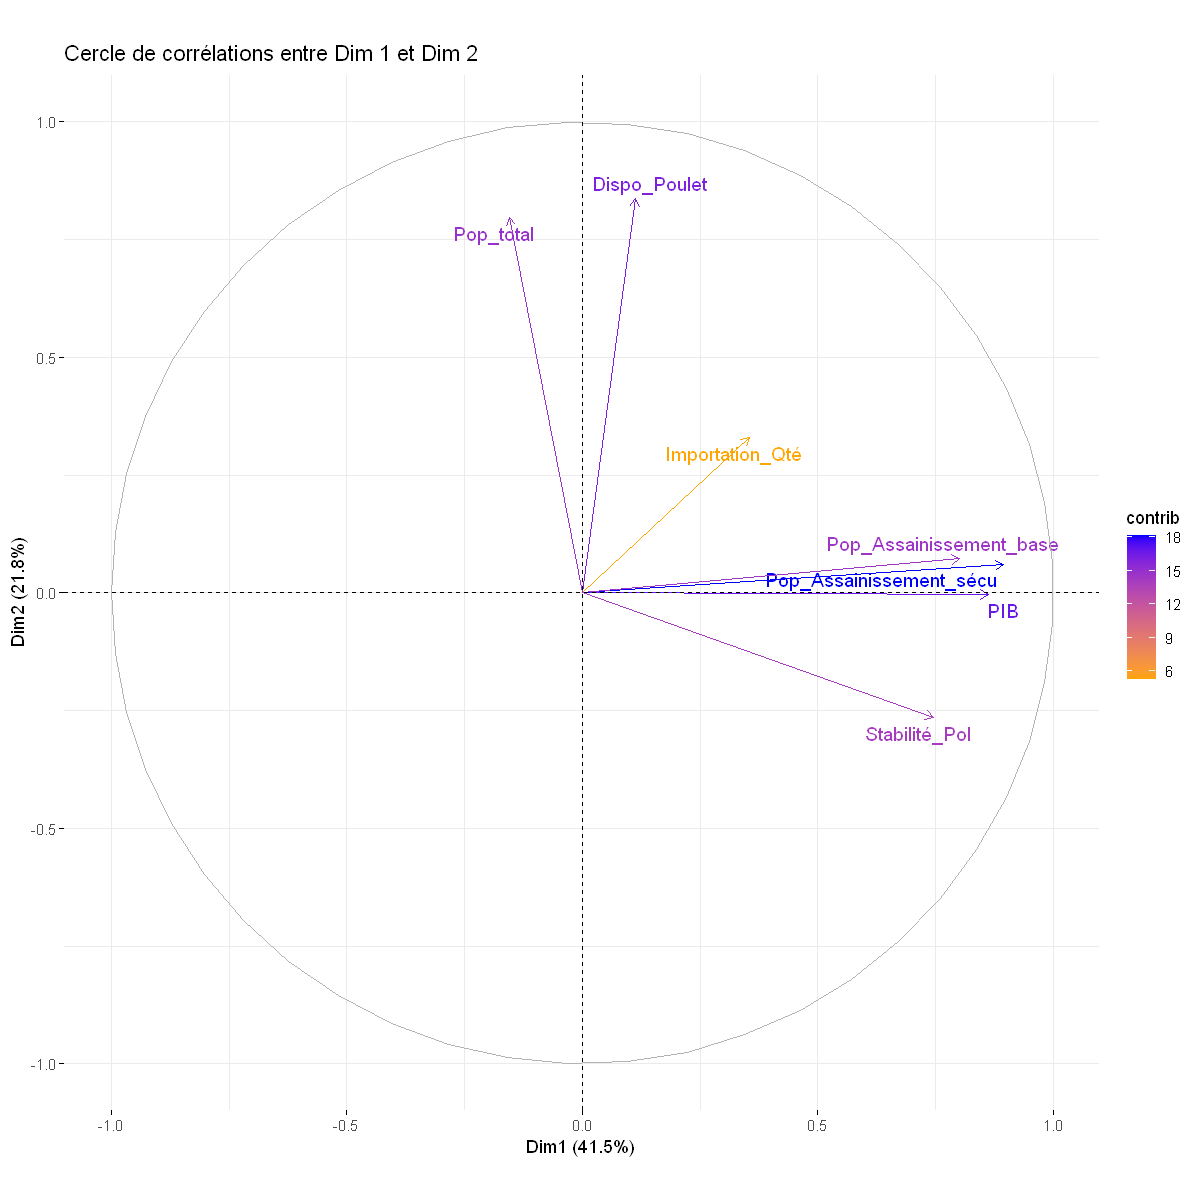

In [11]:
fviz_pca_var(res.pca, col.var= "contrib", 
             gradient.cols= c("orange","blue"), repel=TRUE,  title="Cercle de corrélations entre Dim 1 et Dim 2")

D'après ces visuels, on peut dire que: 

- Dimension 1: Cette axe regroupe les aspects économiques des Pays. Il y a une forte corrélation positive entre les variables PIB et infrastructures. Cette première dimension regroupe 41.5% des informations. La stabilité politique également contribue à cette dimension quand on regarde l'angle.

- Dimension 2: Cette axe regroupe la sécurité du marché alimentaire par rapport à la démographie: En effet, Dispo_poulet est plus contributeur par rapport à la population (quand on regarde l'angle et la longueur de la flèche)



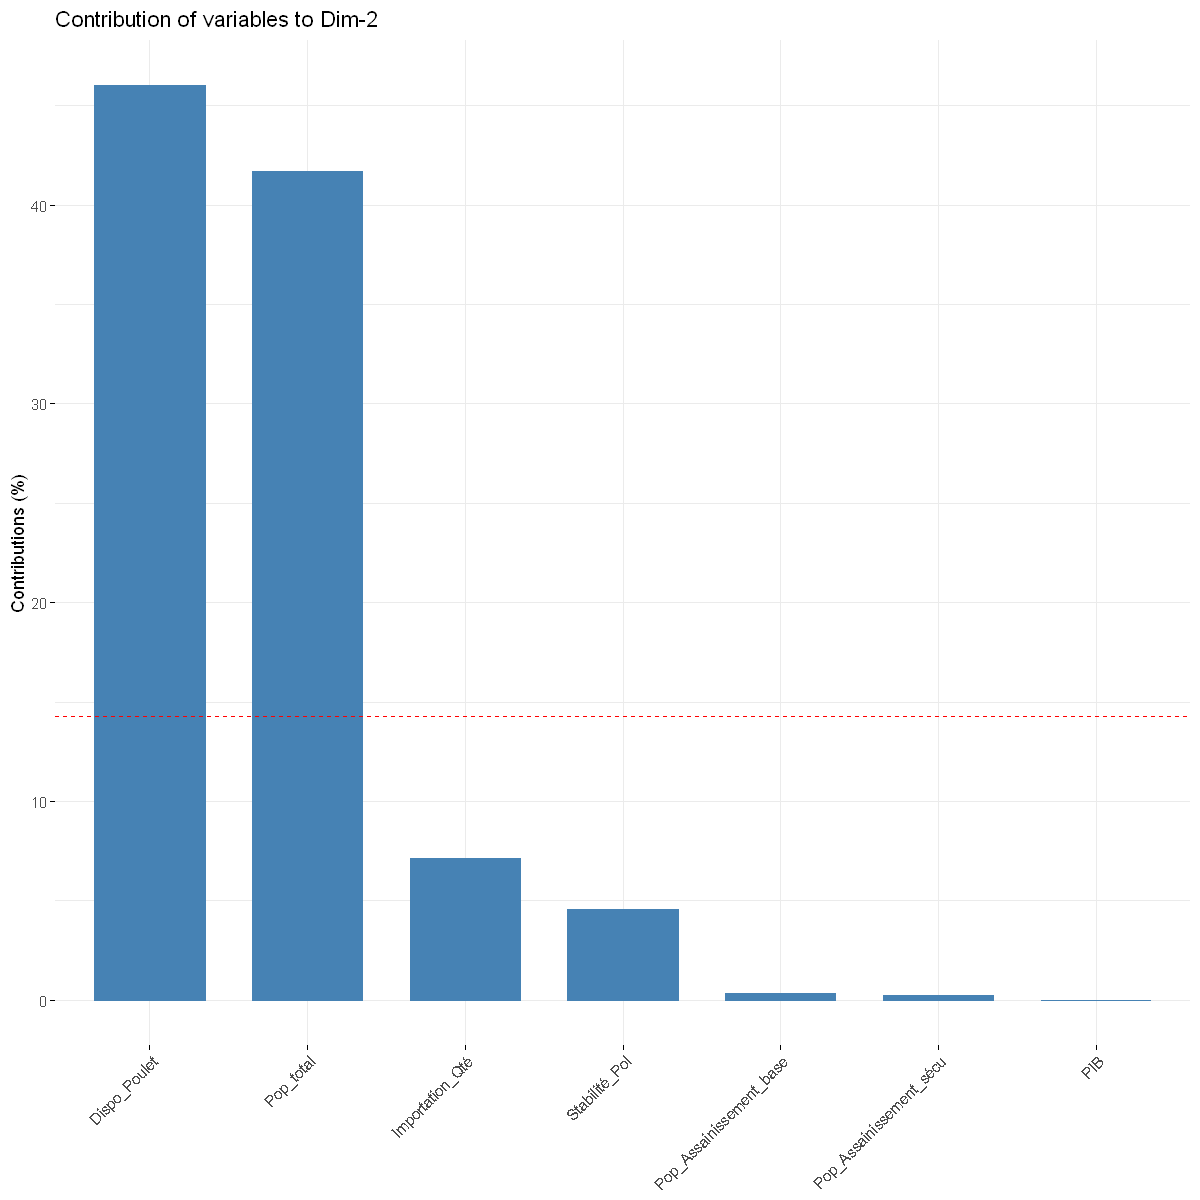

In [12]:
#Dimension 2
fviz_contrib(res.pca, choice = "var", axes = 2)

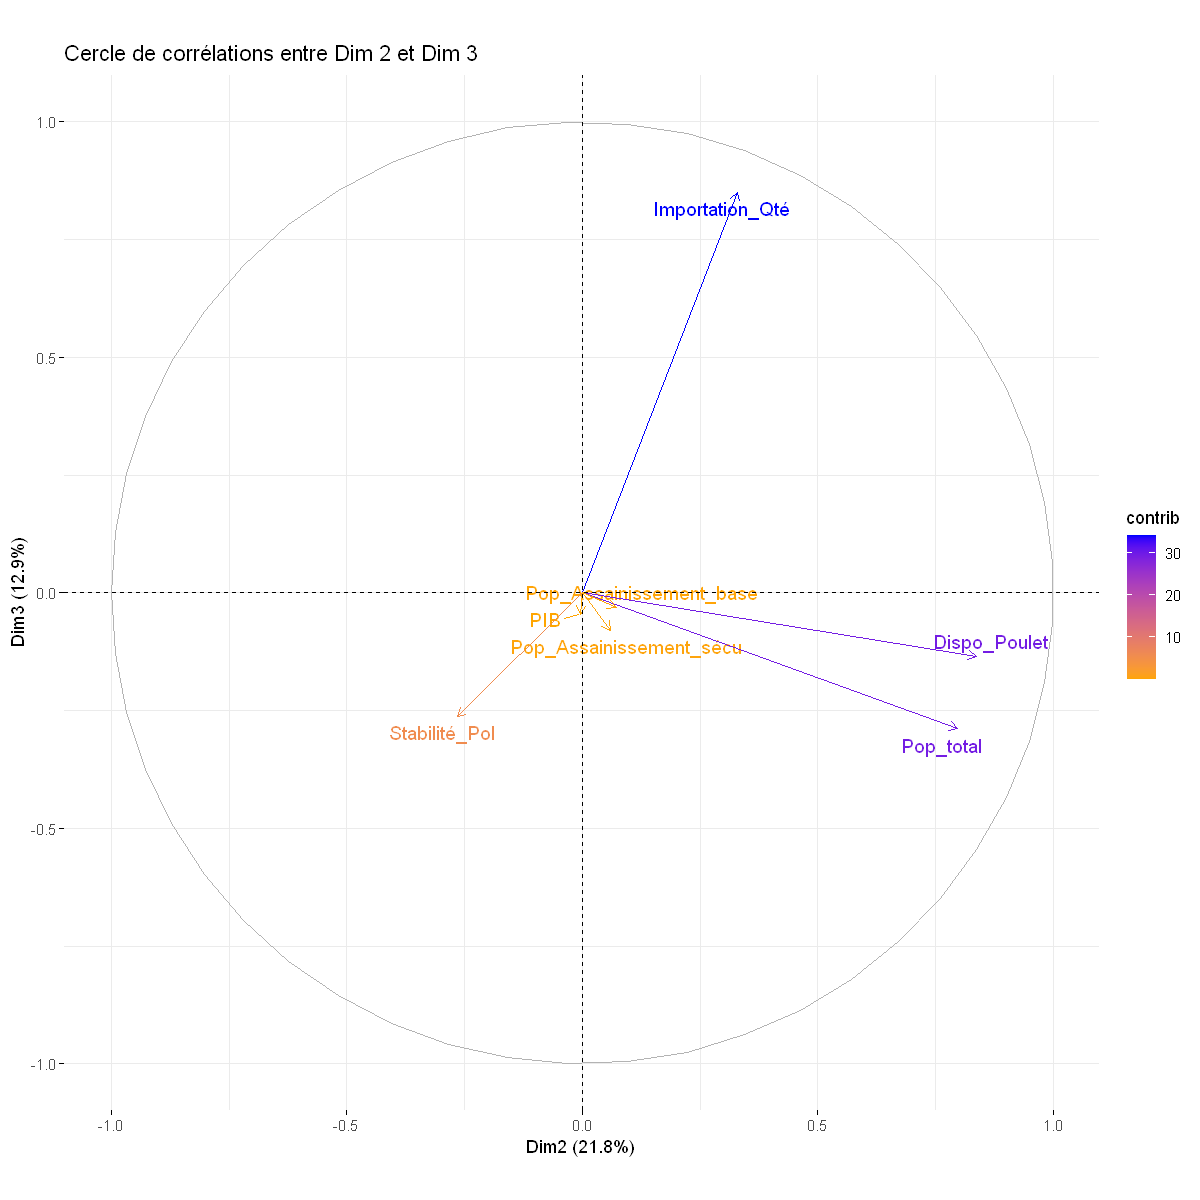

In [13]:
fviz_pca_var(res.pca, axes=c(2,3), col.var= "contrib", 
             gradient.cols= c("orange","blue"), repel=TRUE,  title="Cercle de corrélations entre Dim 2 et Dim 3")

Ces visuels confirment ce qui a été dit précédemment pour l'axe 2.  Et on voit la forte contribution de l'importation sur la dimension 3.


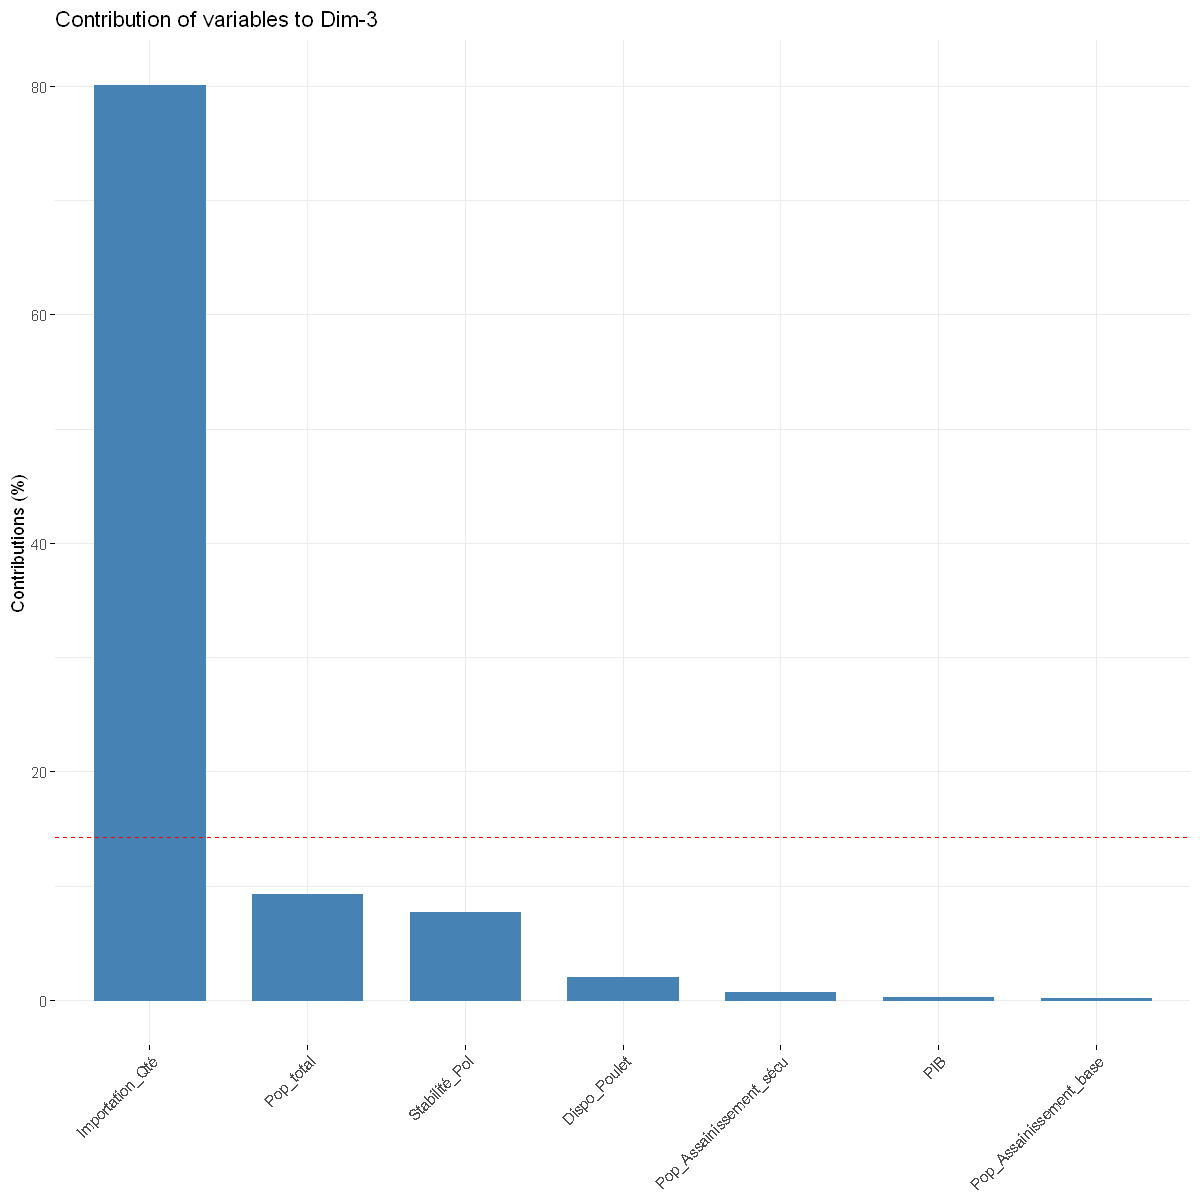

In [14]:
#dimension 3
fviz_contrib(res.pca, choice = "var", axes = 3)

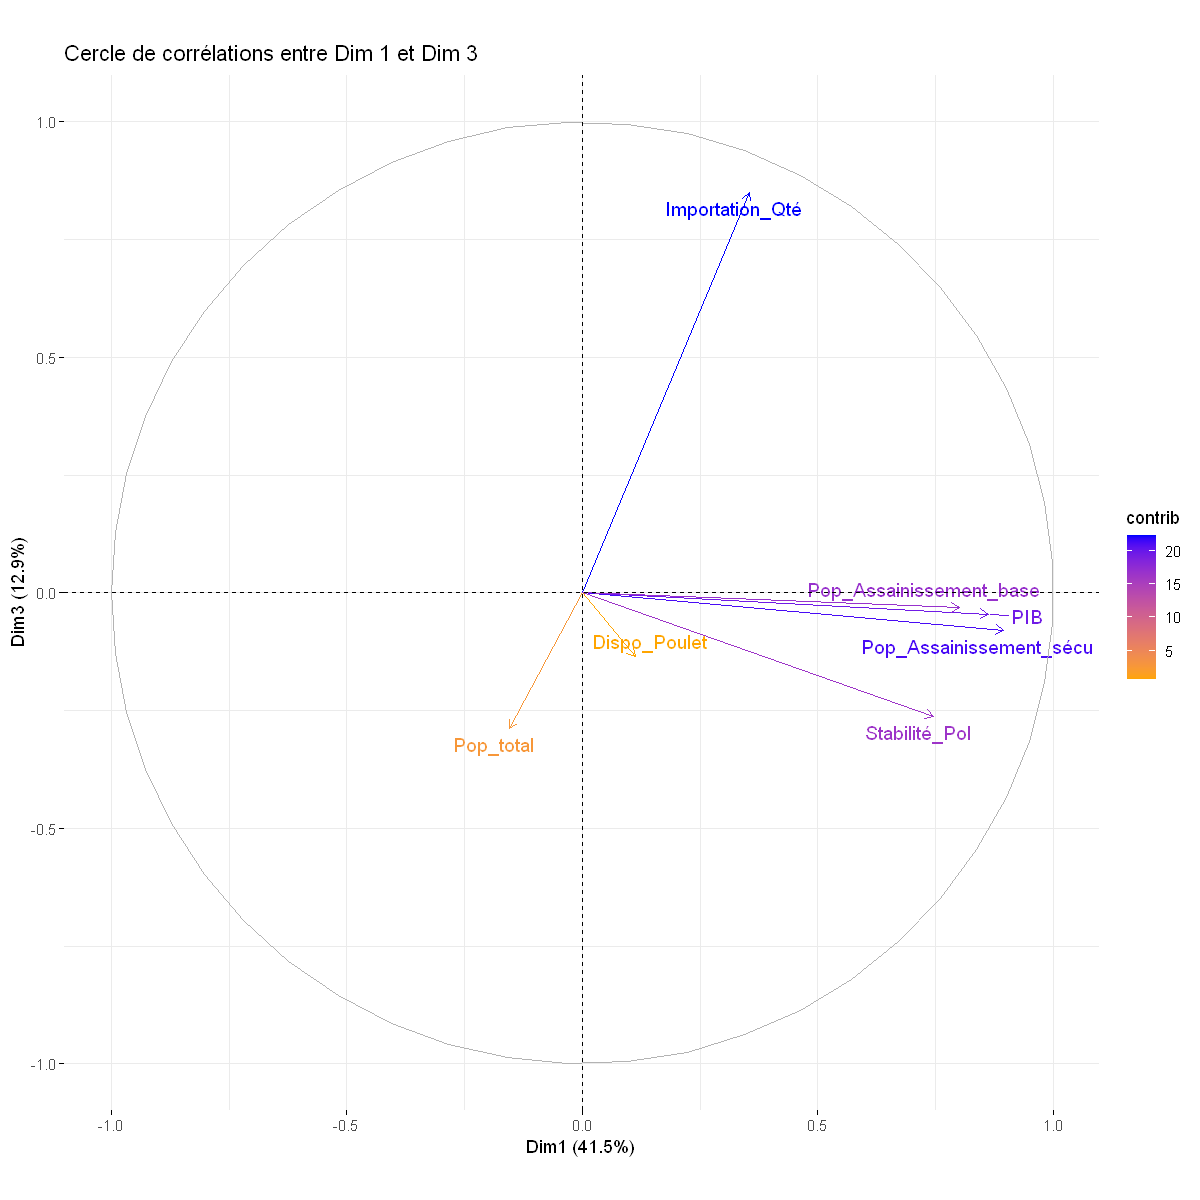

In [15]:
fviz_pca_var(res.pca, axes=c(1,3), col.var= "contrib", 
             gradient.cols= c("orange","blue"), repel=TRUE,  title="Cercle de corrélations entre Dim 1 et Dim 3")

Ces graphiques confirment ce qui a été dit concernant la dimension 1 et 3. La dimension 3 montre l'aspect flux de marchandises.

####  <span style="color:navy">Etape 6 - Les résultats des ACP sur les individus et représentations graphiques</span>

 - <span style="color:indigo"> Contribution des individus sur les axes </span>

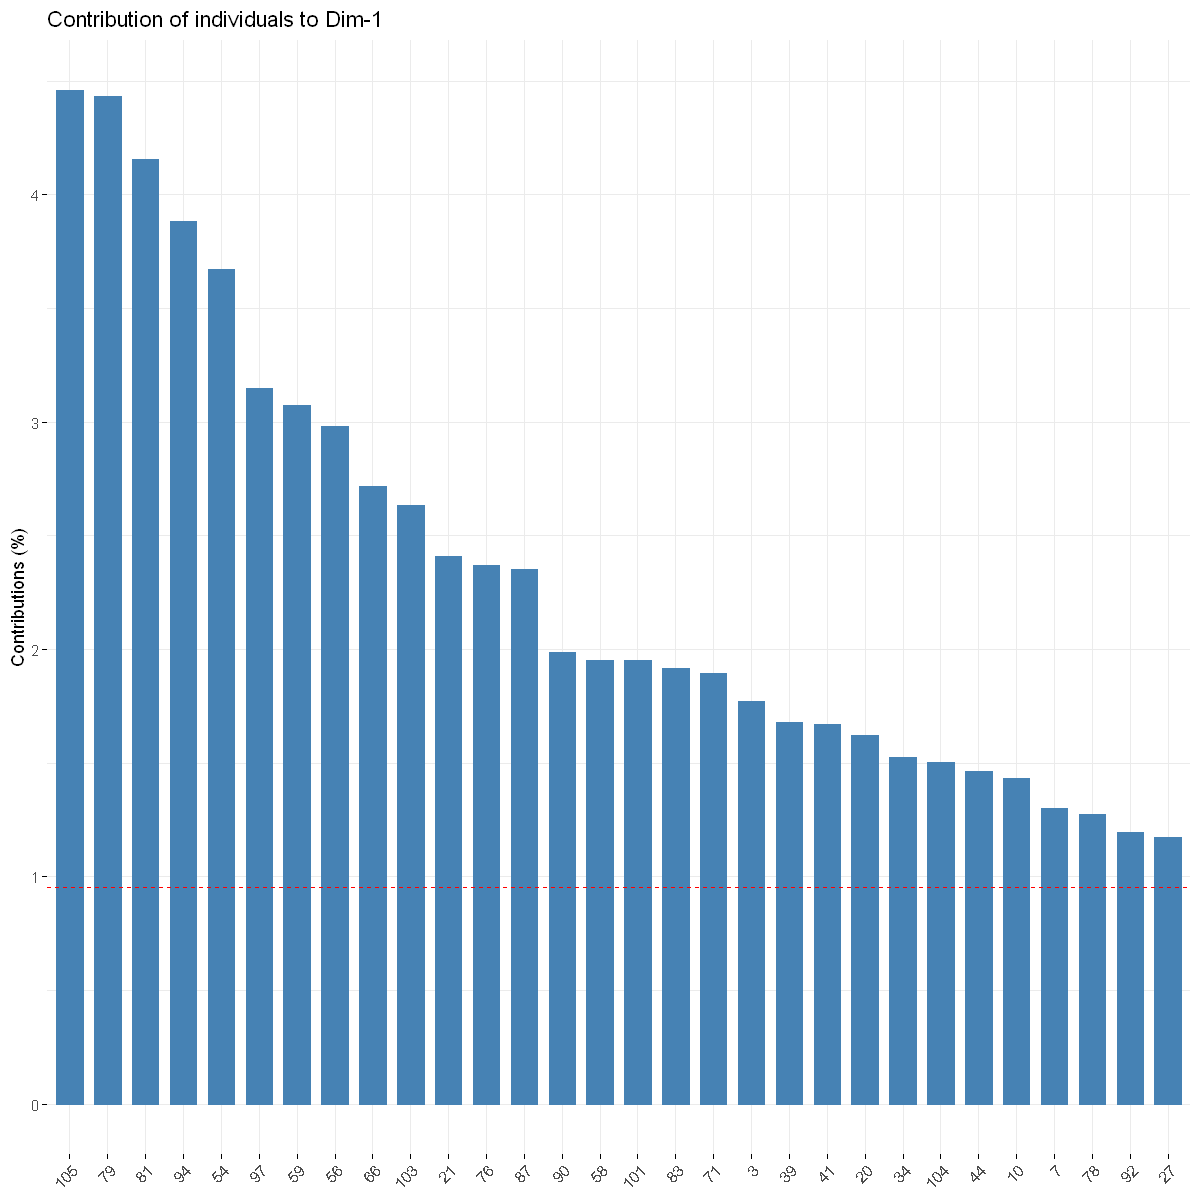

In [16]:
# Visualiser les contributions des individus sur les dimensions + Nuage des individus
fviz_contrib(res.pca, choice = "ind", axes = 1, top = 30)

Sur ce graphique, les 4 premiers pays qui ont une forte contribution à la dimension 1 (aspect économique) concernent les pays pauvres Ethiopie(105), République centrafricaine(79), RDC(81), Tchad(94)...

Warning message:
"ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


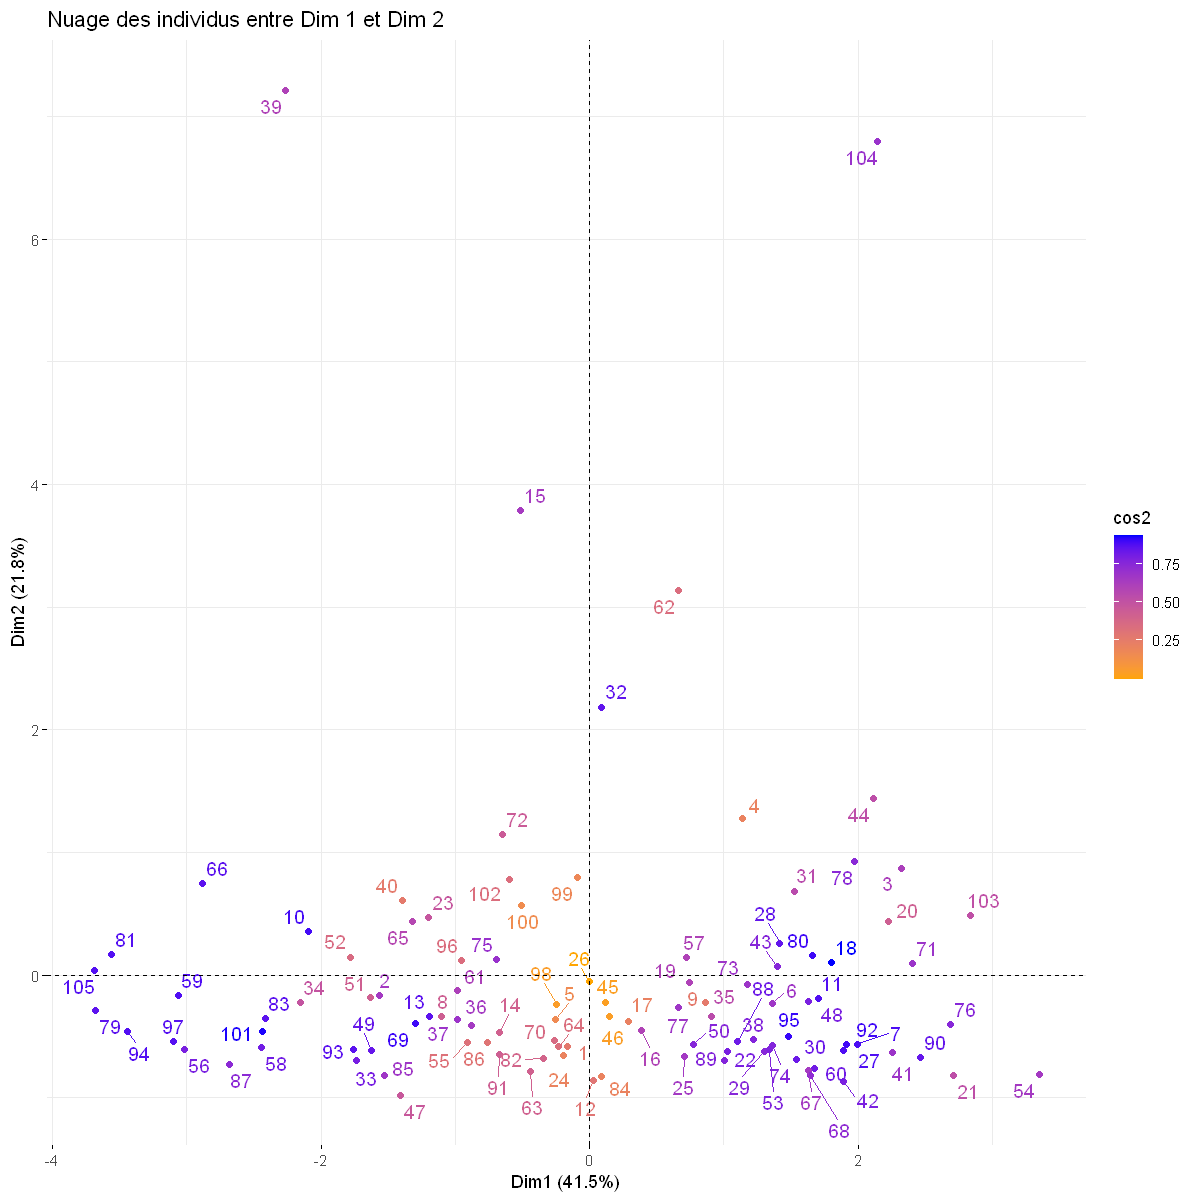

In [17]:
fviz_pca_ind(res.pca, axes = 1:2, col.ind= "cos2", gradient.cols= c("orange","blue"), 
              repel=TRUE,  title="Nuage des individus entre Dim 1 et Dim 2")

Quand le cos² proche de 1 (en bleu) càd que la zone a fortement contribué à la formulation de l'axe. Les Zones en orange par contre ont une contribution faible.

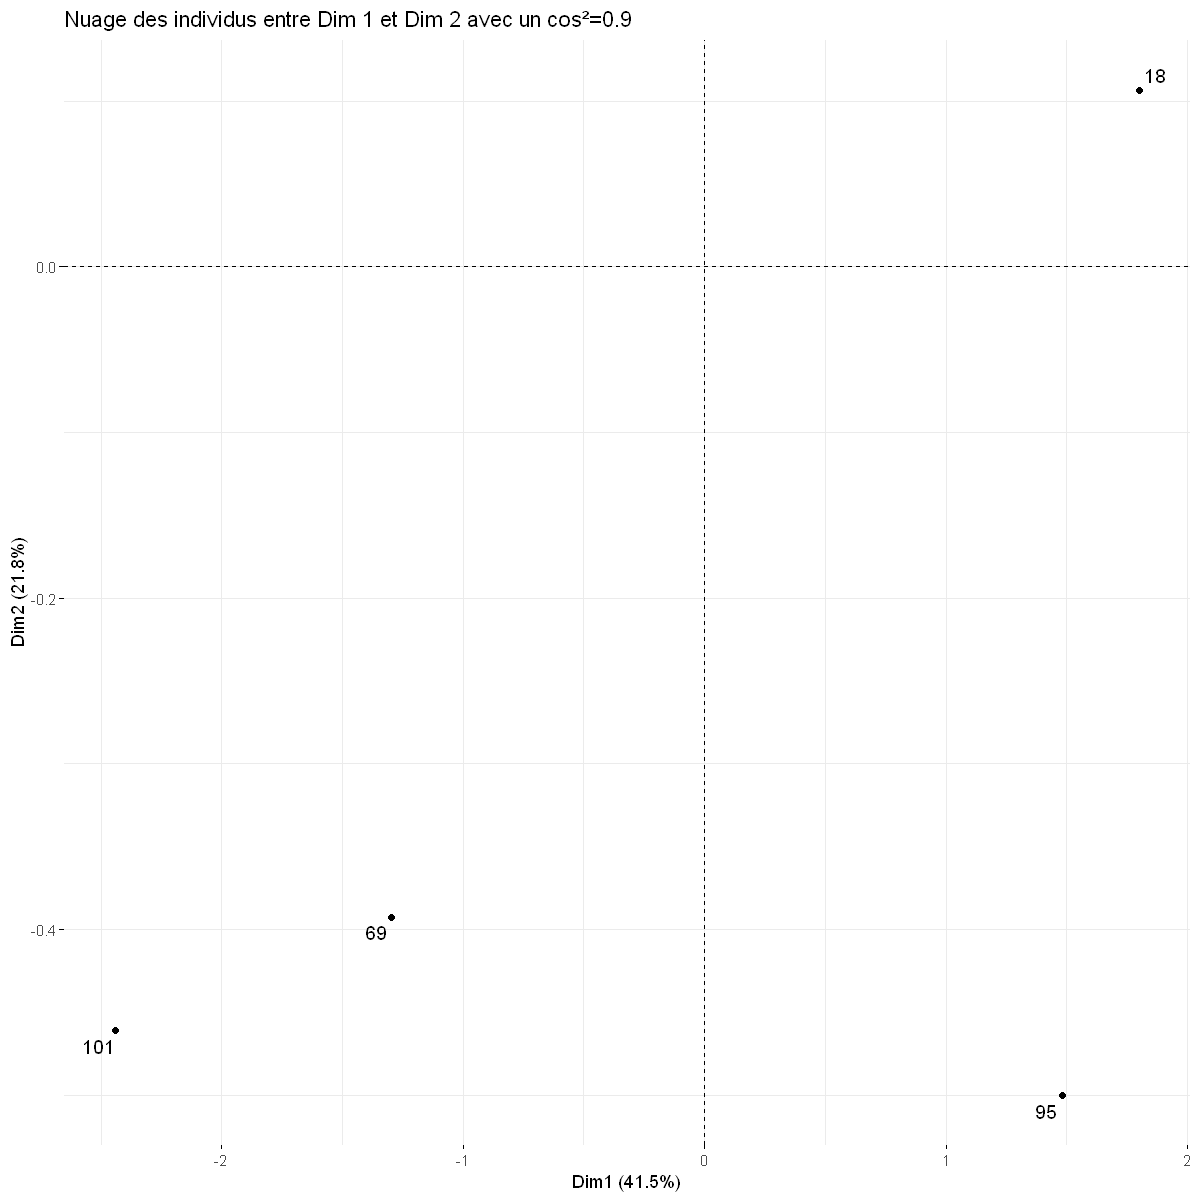

In [18]:
#voir les pays qui ont fortement contribué à la formation des dimensions ex: cos²=0.9
fviz_pca_ind(res.pca, axes = 1:2, select.ind =list(cos2=0.9), 
              repel=TRUE,  title="Nuage des individus entre Dim 1 et Dim 2 avec un cos²=0.9")

Si on regarde que les pays ayant une forte contribution aux 2 axes (cos²=0.9), on peut dire que :
- 18 (Canada) est un pays ayant une économie prospère.
- 95 (Tchéquie) est un pays ayant une économie prospère mais une faible disponibilité de poulet par habitant
- 101(Zimbabwe), 69(Népal) ont fortement contribué à la constitution des 2 axes. Ils ont à la fois une économie faible et une faible disponibilité de poulet par habitant.

In [19]:
# Voir la liste des pays correspondant au numéro ==> Ajouter une nouvelle colonne avec des numéros d'index à partir de 1
Correspondance.Zone <- Fichier_final[, ID := 1:.N]
Correspondance.Zone

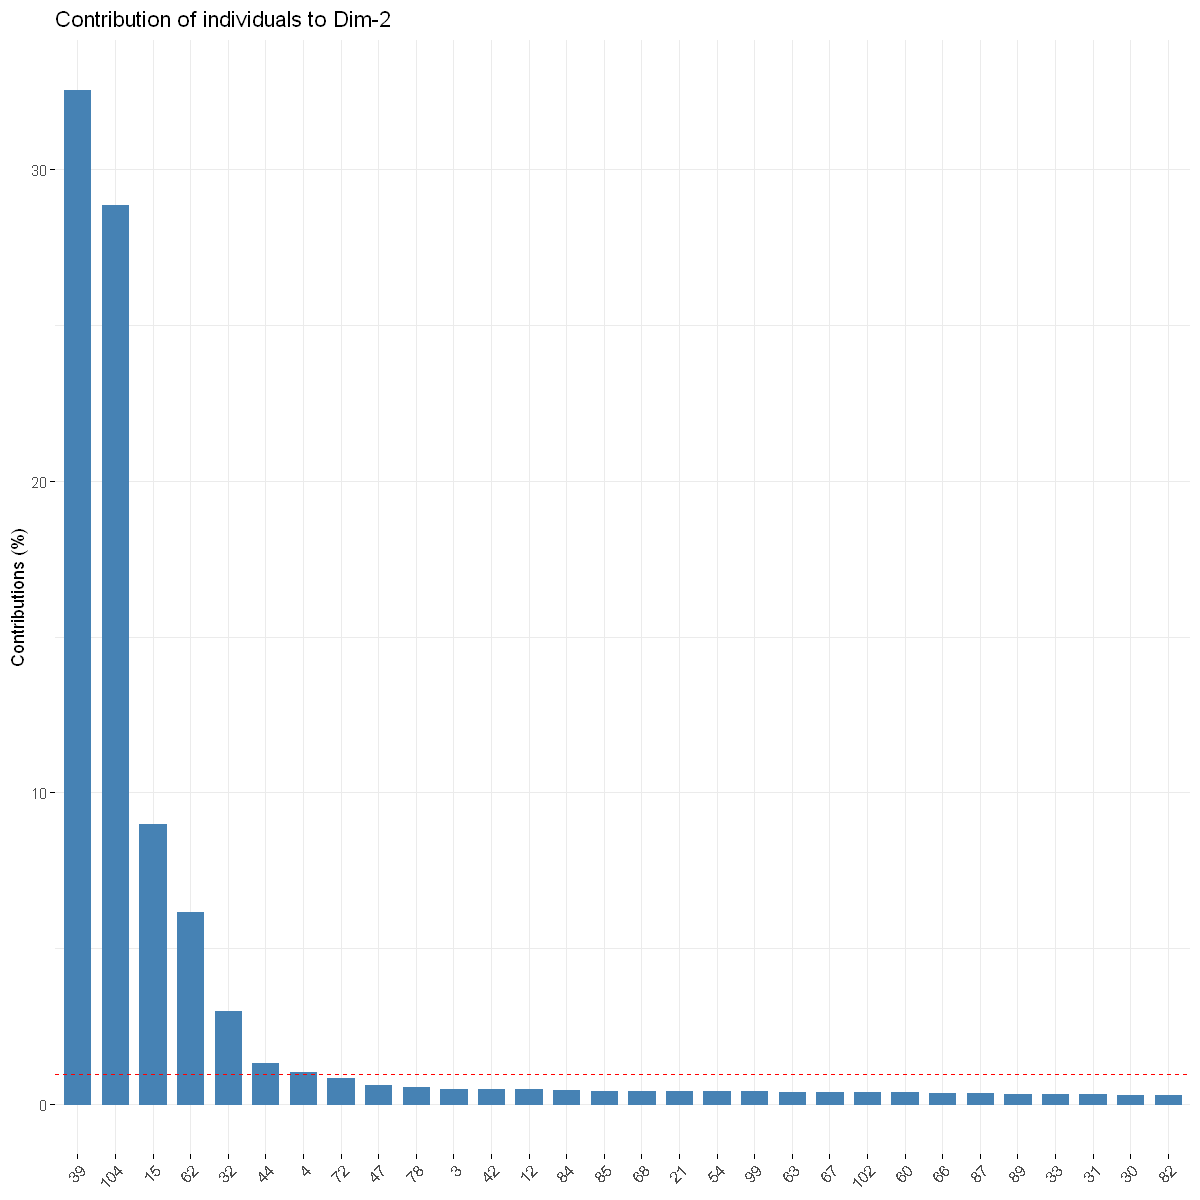

In [20]:
#Dimension 2
fviz_contrib(res.pca, choice = "ind", axes = 2, top = 30)

Quand on regarde ces 2 graphiques, les pays ayant fortement contribué à la dimension 2 sont: l'Inde(39), Les Emirats (104)..

Warning message:
"ggrepel: 78 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


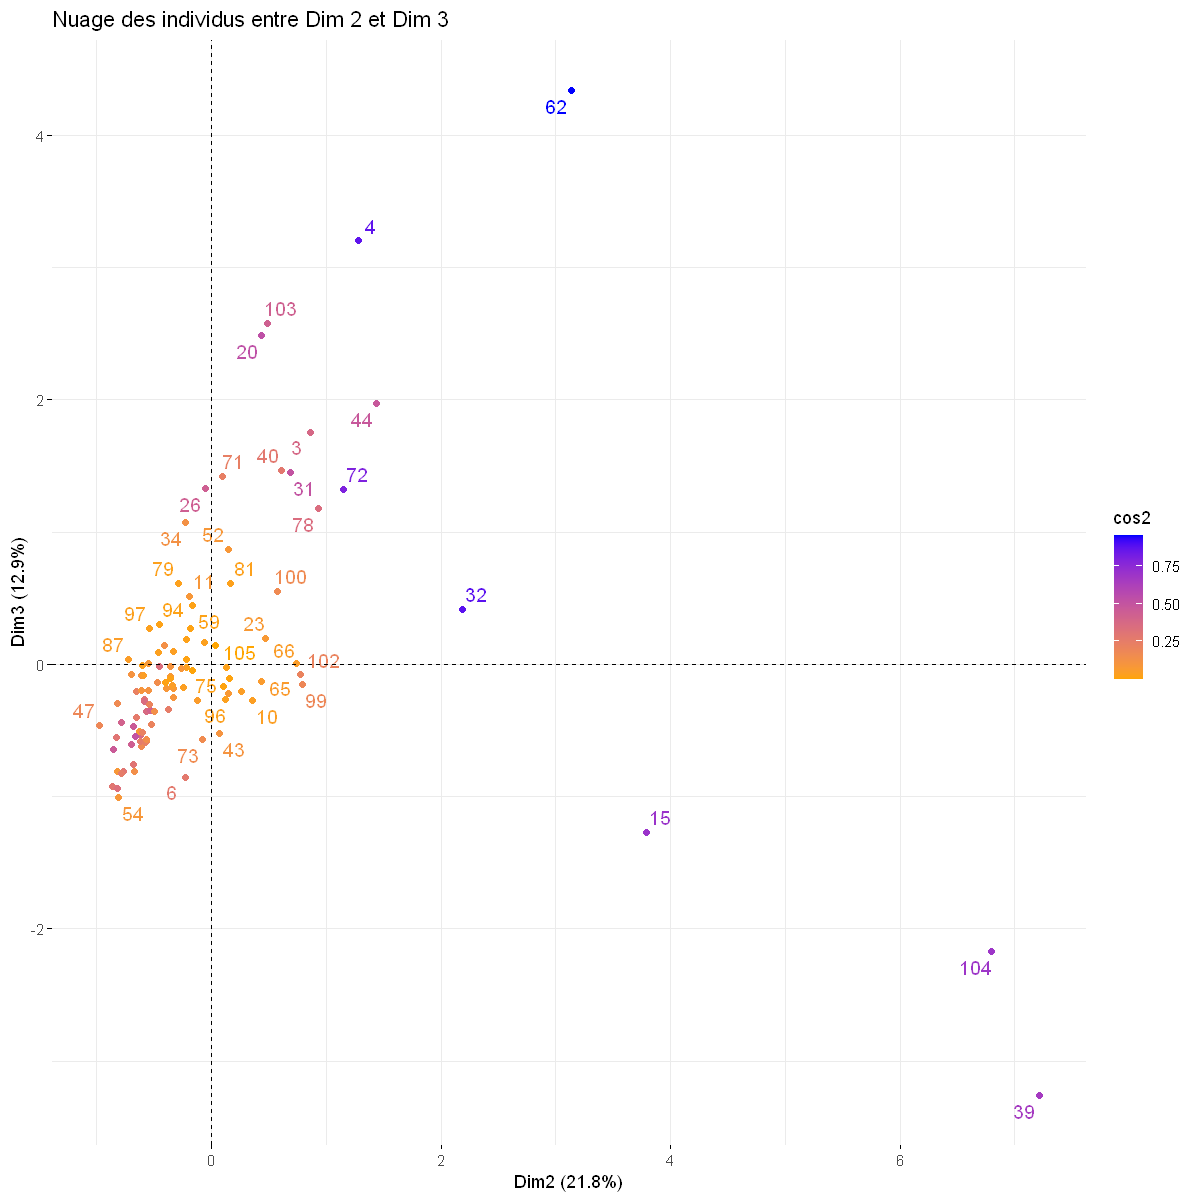

In [21]:
fviz_pca_ind(res.pca, axes=c(2,3), col.ind= "cos2", gradient.cols= c("orange","blue"),  
            repel=TRUE,  title="Nuage des individus entre Dim 2 et Dim 3")

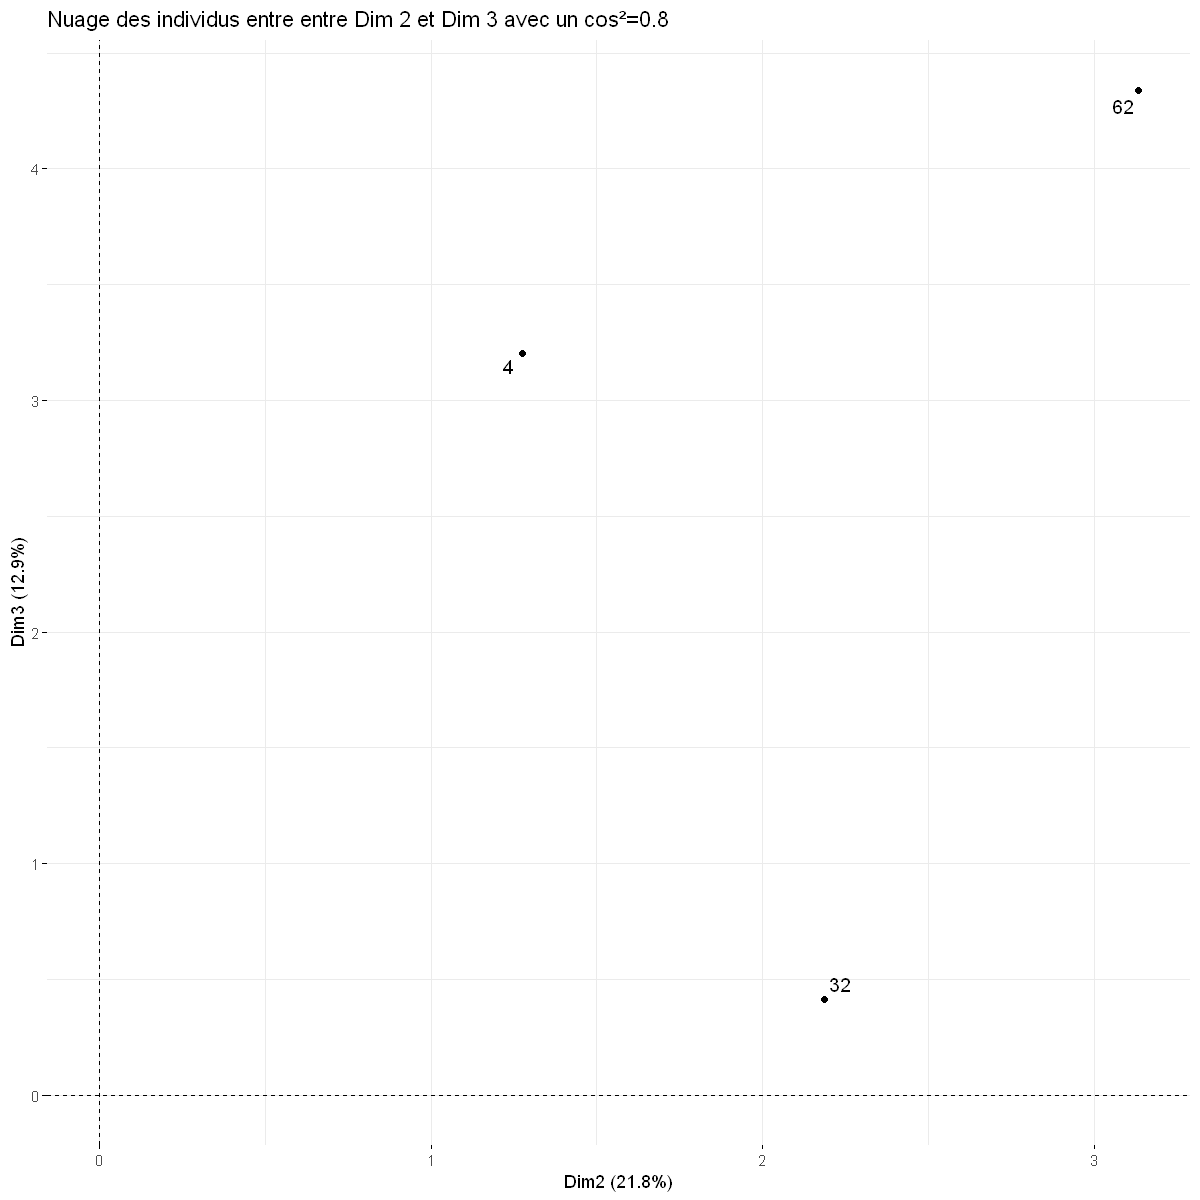

In [22]:
#voir les pays qui ont fortement contribué à la formation des dimensions ex: cos²=0.8
fviz_pca_ind(res.pca, axes = 2:3, select.ind =list(cos2=0.8), 
              repel=TRUE,  title="Nuage des individus entre entre Dim 2 et Dim 3 avec un cos²=0.8")

Si on regarde la dimension 2 et 3, seuls les pays 4(Arabie Saoudite), 32(Russie) et 62(Mexique)  présentent des cos² supérieur à 0.8. Ils contibuent fortement à l'élaboration des 2 axes. Ce sont donc des pays qui ont à la fois une forte disponibilité de poulet surtout la Russie et une forte importation de poulet, qui est surtout valable pour l'Arabie Saoudite dont l'angle est plus proche de la dimension 3 que de la dimension 2. 

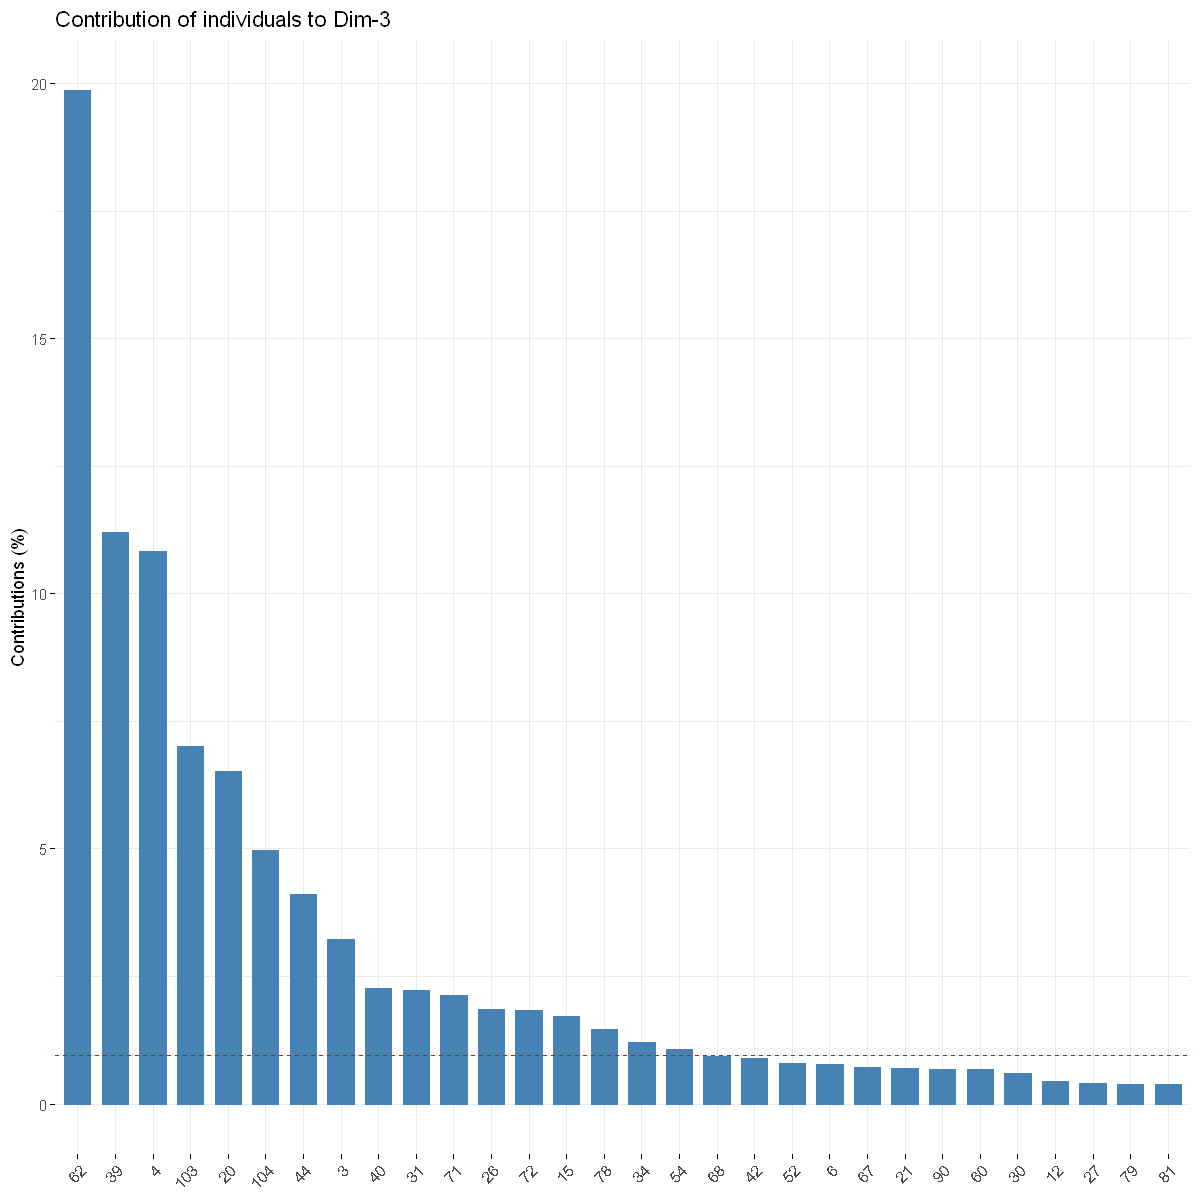

In [23]:
#dimension 3
fviz_contrib(res.pca, choice = "ind", axes = 3, top = 30)

Quand on regarde ce graphique, les pays ayant une forte contributions à la dimension 3 (flux d'importation) sont: le Mexique(62), l'Inde(39), ou encore l'Arabie Saoudite (4)

Warning message:
"ggrepel: 38 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


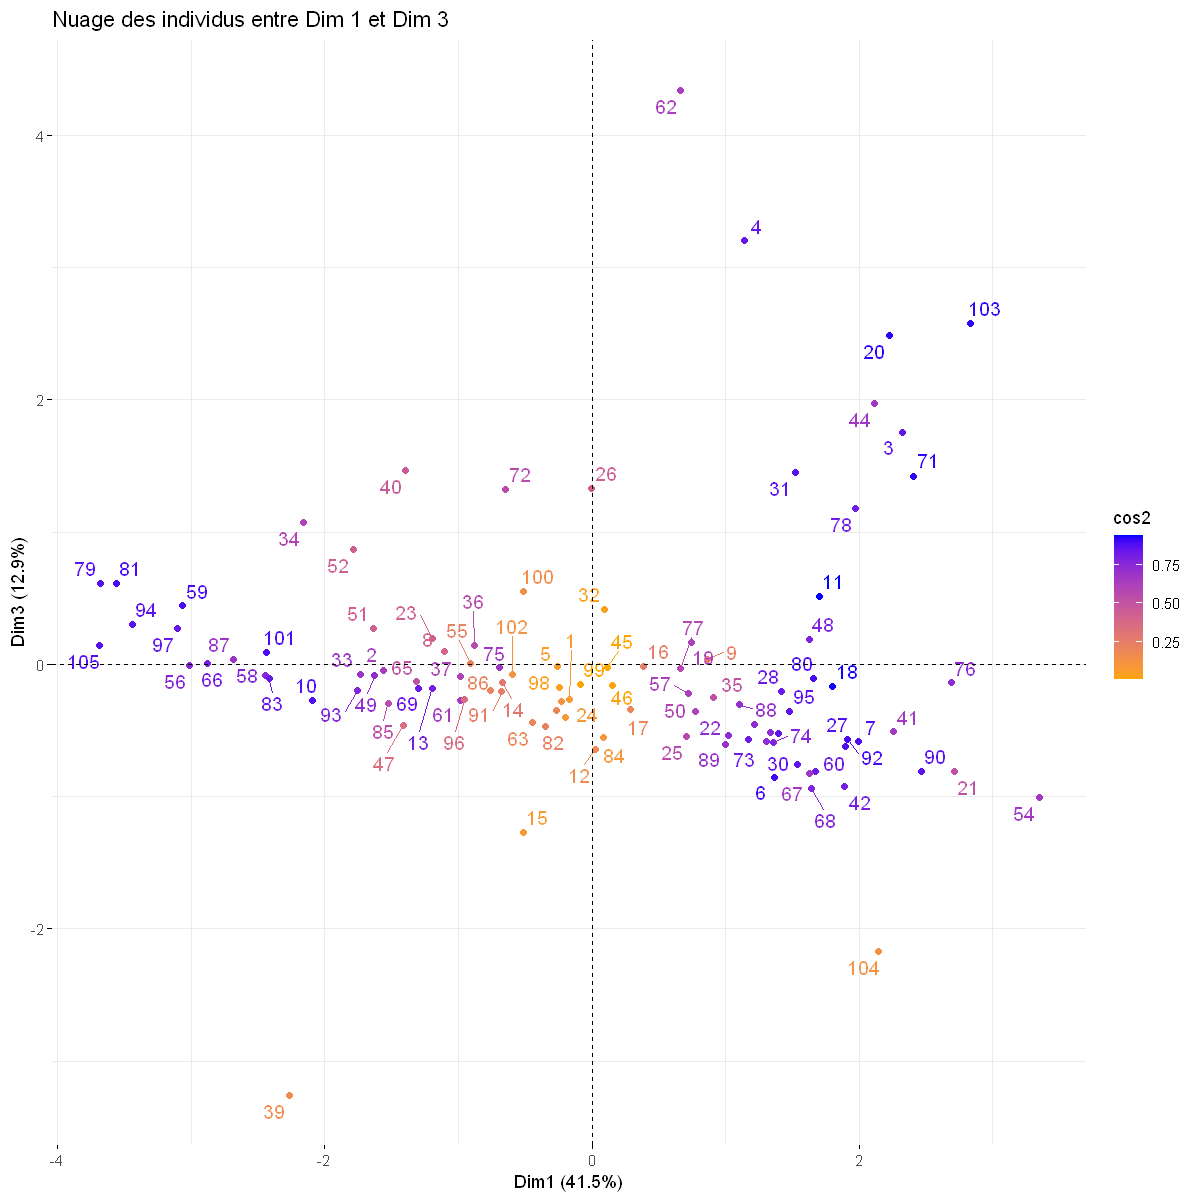

In [24]:
fviz_pca_ind(res.pca, axes=c(1,3), col.ind= "cos2", gradient.cols= c("orange","blue"), 
             repel=TRUE,  title="Nuage des individus entre Dim 1 et Dim 3")

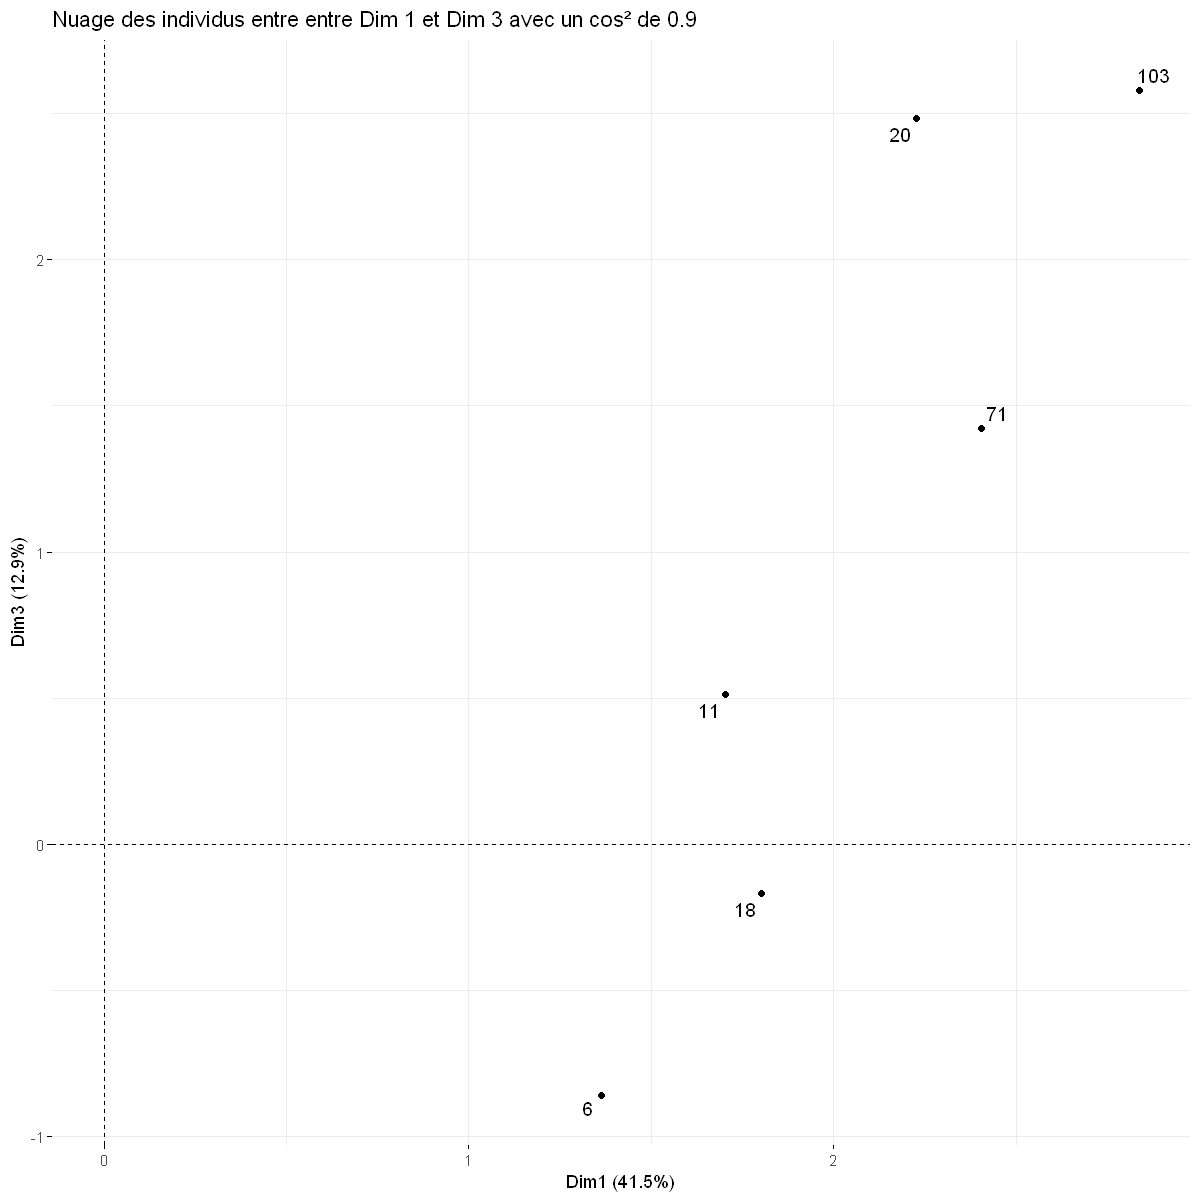

In [25]:
#voir les pays qui ont fortement contribué à la formation des dimensions ex: cos²=0.9
fviz_pca_ind(res.pca, axes = c(1,3), select.ind =list(cos2=0.9), 
              repel=TRUE,  title="Nuage des individus entre entre Dim 1 et Dim 3 avec un cos² de 0.9")

D'après cette analyse, les pays qui ont fortement contribués à l'élaboration des 2 dimensions sont: 
- 103(Émirats arabes unis), 20(Chine) et 71(Pays-Bas) qui ont les mêmes comportements. Ils ont une forte valeur pour l'aspect économique et ont un flux assez important quand à l'importation de poulet.
- Puis 11(Belgique) et 18(Canada) qui ont de forte valeur sur l'aspect économique, ainsi que l'Australie. Par contre, ce dernier a un flux moins important concernant l'importation de poulet.

####  <span style="color:navy">Etape 7 - Les représentations graphiques avec biplot</span>

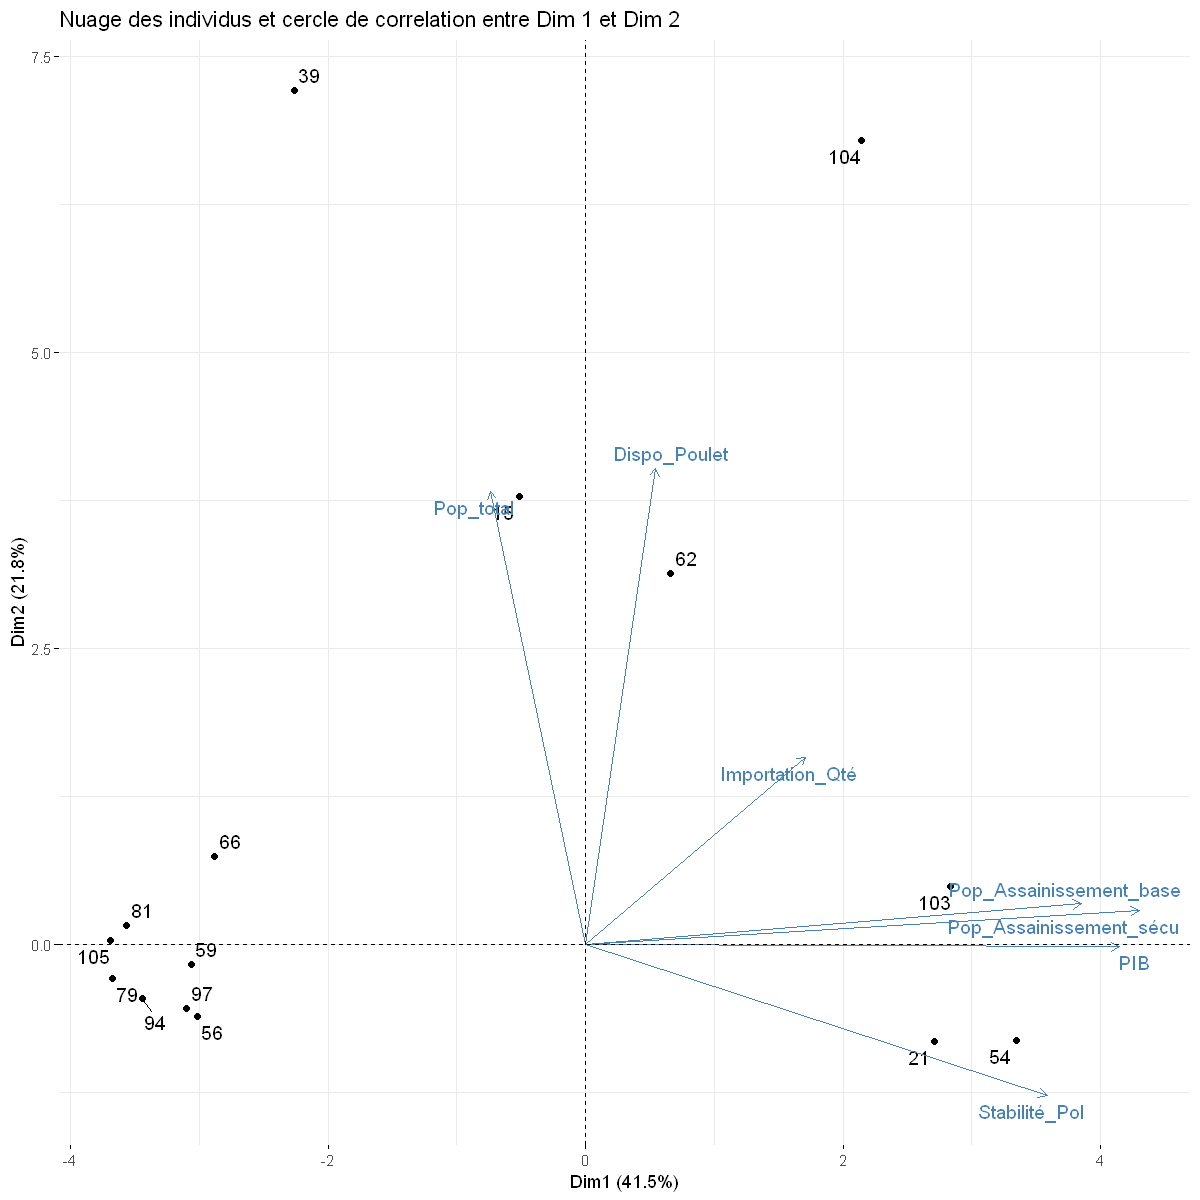

In [26]:
#dimension 1 et 2 = les 15 top pays
fviz_pca_biplot(res.pca, axes=c(1,2), select.ind = list(contrib = 15), 
             repel=TRUE,  title="Nuage des individus et cercle de correlation entre Dim 1 et Dim 2")

Sur la dimension 1, on peut dire:
- 103(Emirats arabes unis) a de forte valeurs sur l'aspect économique.
- 104(USA), 62(Mexique) contribuent plus fortement à la 2ème dimension. C'est à dire à la disponibilité en poulet.
- 21(Chine) et 54(Luxembours) ont ramenés de fortes valeurs par rapport à la stabilité politique.
- 39(Inde) et 15(Brésil) ont une forte contribution par rapport au nombre de population.
- Les pays comme 66(Nigéria), 81(RDC), représentent les pays pauvre et qui se trouvent à gauche. Ils sont correlés négativement à l'axe économique.

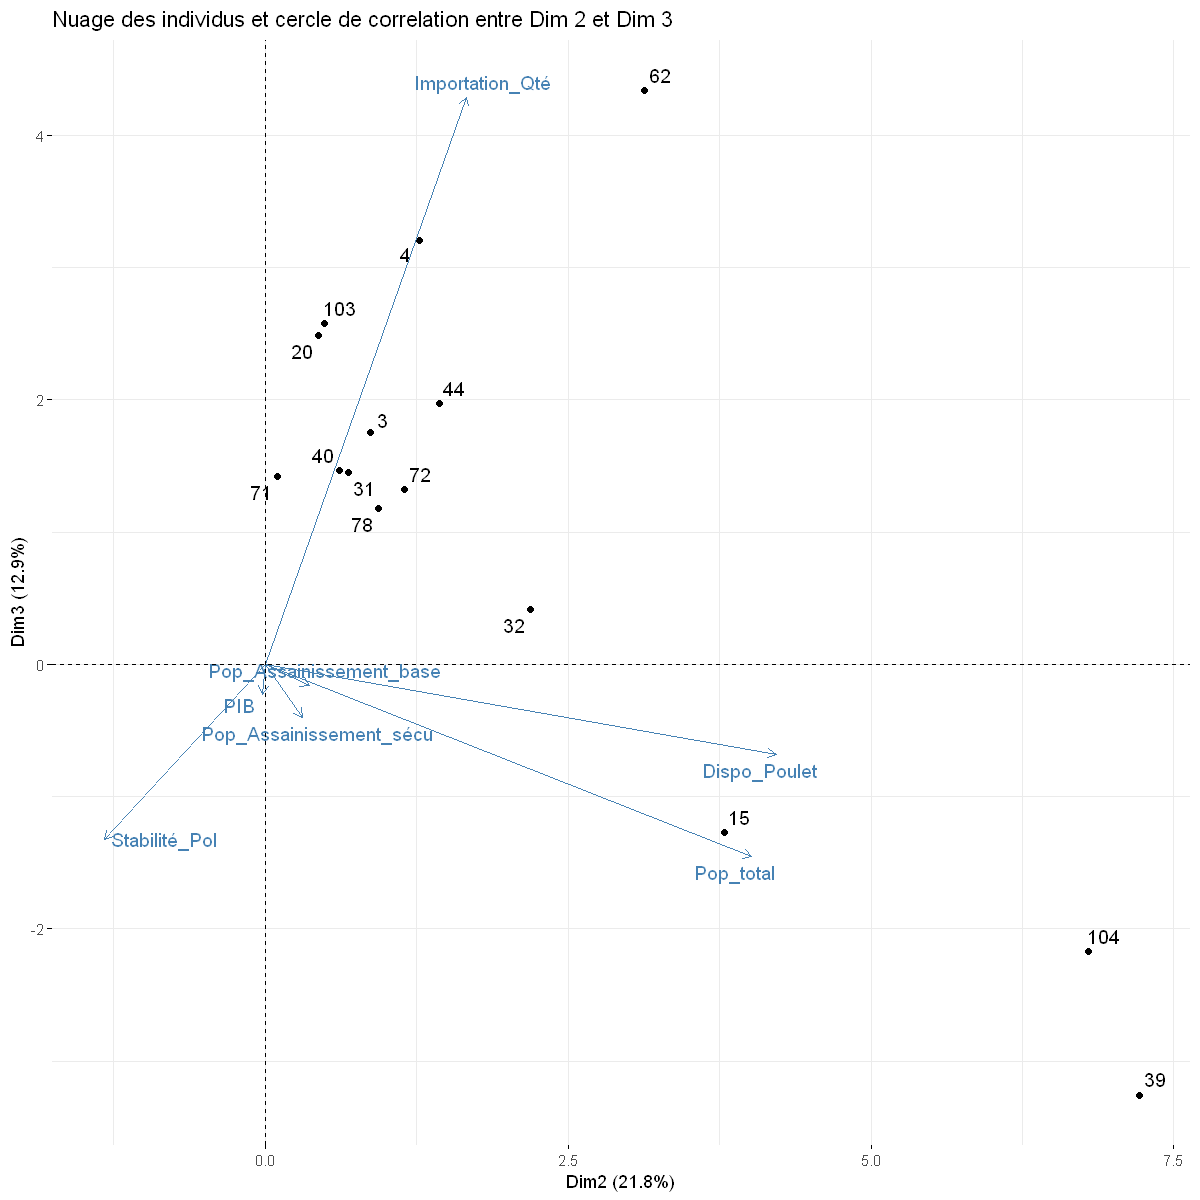

In [27]:
#dimension 2 et 3 = les 15 tops pays
fviz_pca_biplot(res.pca, axes=c(2,3), select.ind = list(contrib = 15), 
             repel=TRUE,  title="Nuage des individus et cercle de correlation entre Dim 2 et Dim 3")

- On a vu que les pays 39(Inde), 104 (USA) et 15(Brésil) ont une forte contribution par rapport à la densité et la disponibilité en poulet
- Toutes les zones en haut à droite ont de forte valeurs en importation de Poulet ex: 62(Mexique), 4(Arabie Saoudite)

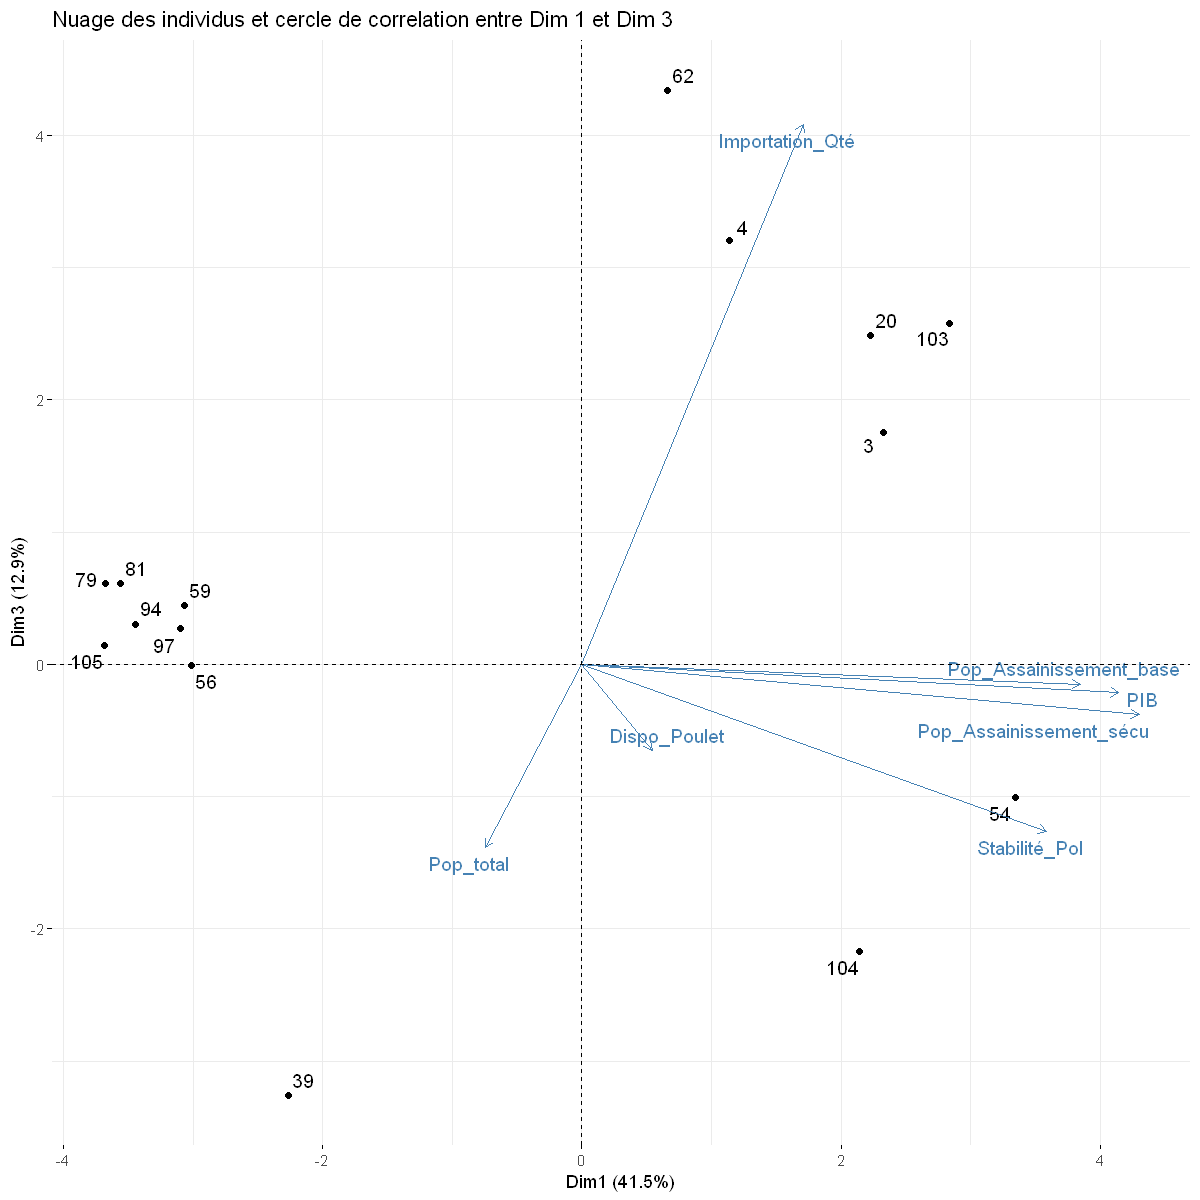

In [28]:
#dimension 1 et 3 = les 15 top pays
fviz_pca_biplot(res.pca, axes=c(1,3), select.ind = list(contrib = 15),
                 gradient.cols= c("orange","blue"), 
             repel=TRUE,  title="Nuage des individus et cercle de correlation entre Dim 1 et Dim 3")

   En comparant les dimensions 1 et 3, on a les pays qui ont de  forte valeurs en importation de Poulet ex: 62(Mexique), 4(Arabie Saoudite). Les pays comme 20(Chine), 103 (Emirats) sont des pays ayant ont une forte valeur pour l'aspect économique mais aussi une assez forte importation de poulet. Les pays comme 54(Luxembourg) tire sur la stabilité politique. Et enfin à droite, on a les pays pauvres qui sont correlés négativement par rapport au plan économique comme 81(RDC),66(Nigéria)...

####  <span style="color:navy">Etape 8 - Tableau pour résumer les variables et individus qui ont eu de fortes contributions pour élaborer les 3 axes</span>

In [29]:
# Créer un data.frame avec des sauts de ligne dans la colonne "variables"
dimension_caract <- data.frame(Dimension = c("Dim1", "Dim2", "Dim3"),
                          Caractéristique =c("Puissance économique du Pays","Sécurité du marché alimentaire % à la démographie","Flux d'importation de Poulet"),
                          Variables = c("Pop_Assainissement_base, Pop_Assainissement_sécu, PIB, Stabilité_Pol", "Dispo_Poulet,Pop_total","Importation_Qté"),
                          Individus_representatifs = c("103- Emirats, 21-Chine, 54-Luxembourg", "62- Mexique, 104-USA, 39-Inde, 15-Brésil, 32-Russie", "62-Mexique, 4-Arabie saoudite"),
                          stringsAsFactors = FALSE)

# Afficher le data.frame avec les sauts de ligne dans la colonne "variables"
dimension_caract


Dimension,Caractéristique,Variables,Individus_representatifs
<chr>,<chr>,<chr>,<chr>
Dim1,Puissance économique du Pays,"Pop_Assainissement_base, Pop_Assainissement_sécu, PIB, Stabilité_Pol","103- Emirats, 21-Chine, 54-Luxembourg"
Dim2,Sécurité du marché alimentaire % à la démographie,"Dispo_Poulet,Pop_total","62- Mexique, 104-USA, 39-Inde, 15-Brésil, 32-Russie"
Dim3,Flux d'importation de Poulet,Importation_Qté,"62-Mexique, 4-Arabie saoudite"


## <span style="color:indianred"> Partie V - Clustering ou partitionner des données </span>

### <span style="color:lightseagreen"> CAH - Classification ascendante hiérarchique </span>

La Classification hiérarchique ascendante (CAH) est une méthode d'analyse statistique qui permet de regrouper des données similaires en fonction de leurs caractéristiques communes

-   <span style="color:navy">Choisir le nombre de dimensions à retenir après l'ACP</span>

In [30]:
#j'ai choisi de travailler sur 3 dimensions pour le reste de l'analyse
# résultat ACP avec 3 dimensions centré réduite
res.pca3 <- PCA(Fichier_numérique, scale.unit=TRUE, ncp= 3) 

- <span style="color:navy">Appliquer la classification hiérarchique sur le résultat de l’étape 1</span>

In [31]:
res.hcpc <- HCPC(res.pca3, graph = FALSE)

- <span style="color:navy">Visualiser le dendrogramme généré par la classification</span>



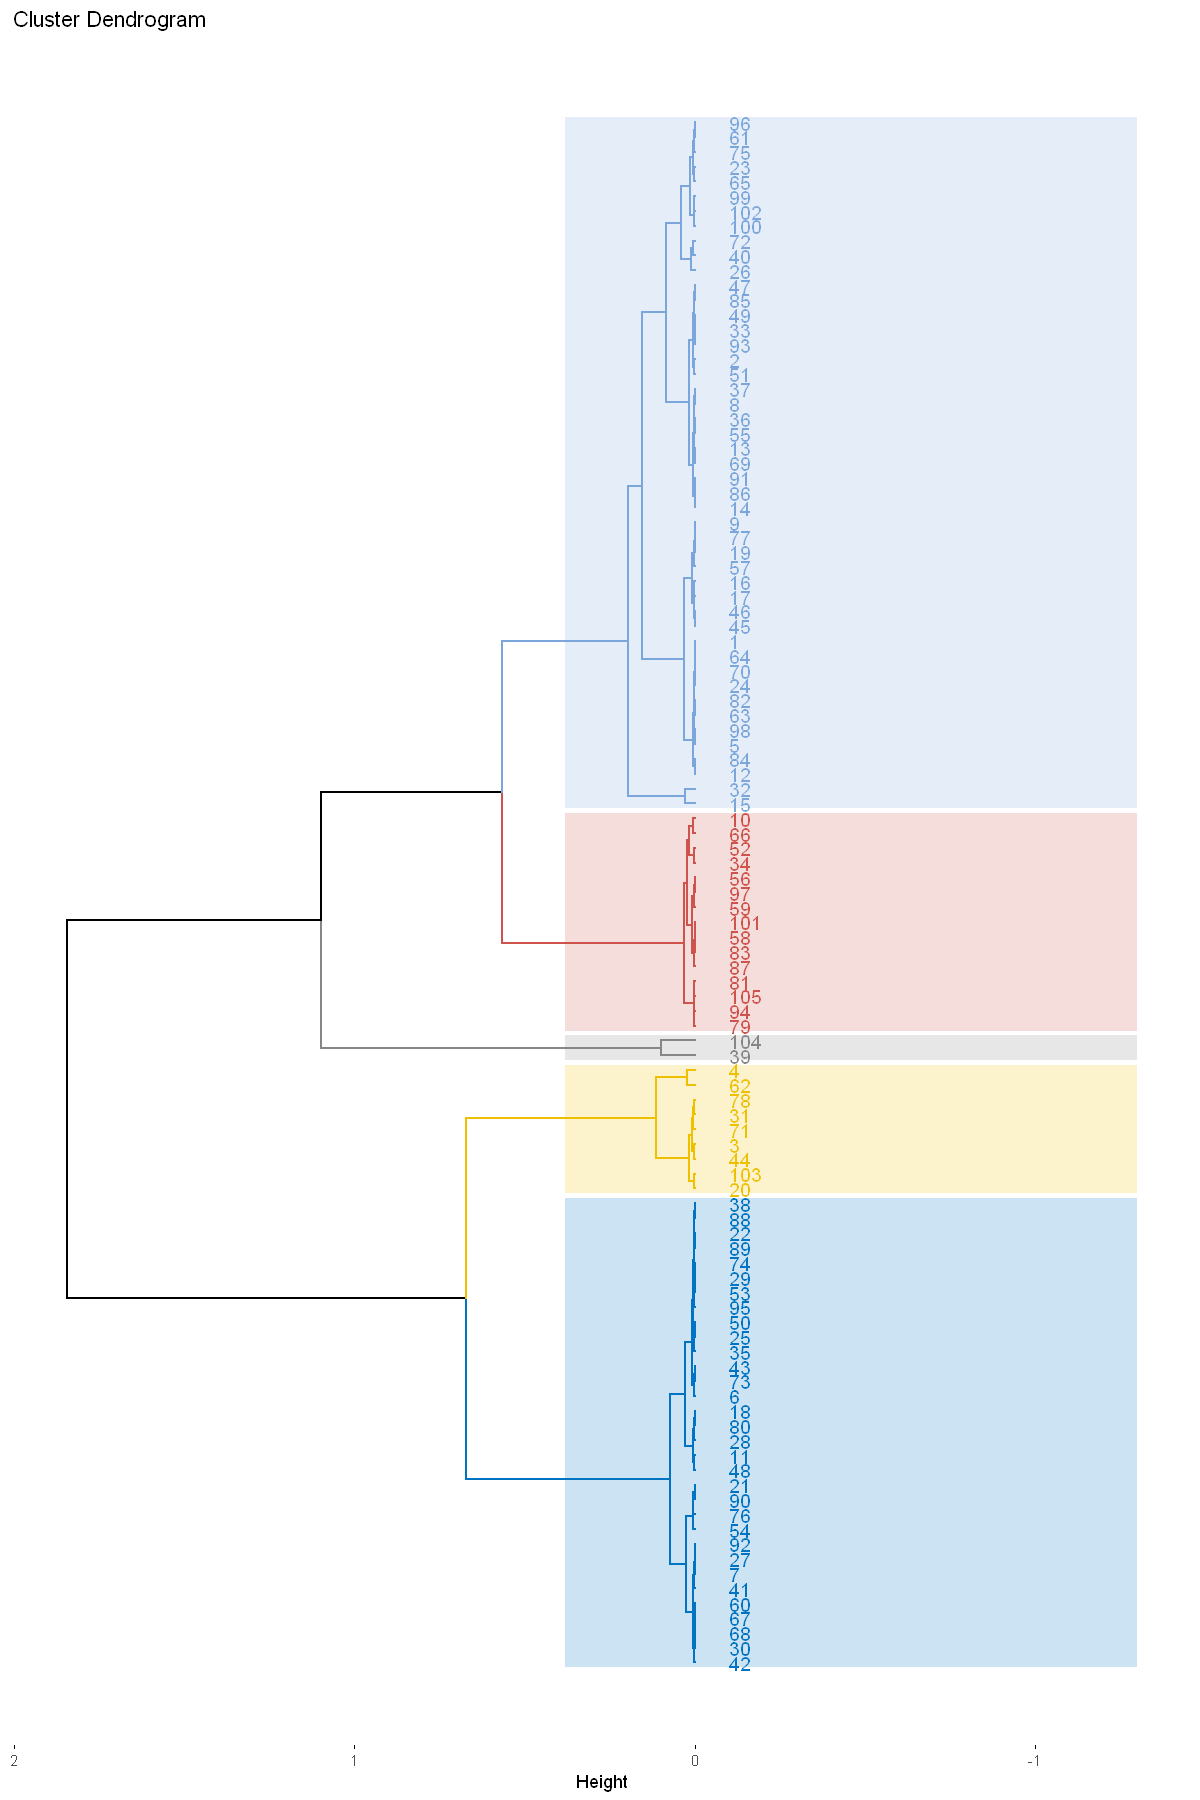

In [32]:
#Un partitionnement initial est effectué.
options(repr.plot.width=10, repr.plot.height=15)
fviz_dend(res.hcpc, 
          cex = 0.8,                     # Taille du text
          palette = "jco",               # Palette de couleur ?ggpubr::ggpar
          rect = TRUE, rect_fill = TRUE, horiz = TRUE, # Rectangle autour des groupes
          rect_border = "jco",           # Couleur du rectangle
          labels_track_height = 0.8     # Augment l'espace pour le texte
          #ggtheme = theme_classic()     # Thème avec une taille de graphique plus grande
          #ggpar = list(figsize = c(15, 20))# Taille du graphique en pouces)
          )

<span style="color:firebrick">Le dendrogramme suggère une solution à 5 groupes.</span>

- <span style="color:navy">Choix du nombre de cluster optimal.</span>

In [33]:
#fichier standardisé
Fichier_numérique_scale <- scale(Fichier_numérique)

##### <span style="color:lightseagreen">Méthodes statistiques Elbow </span>

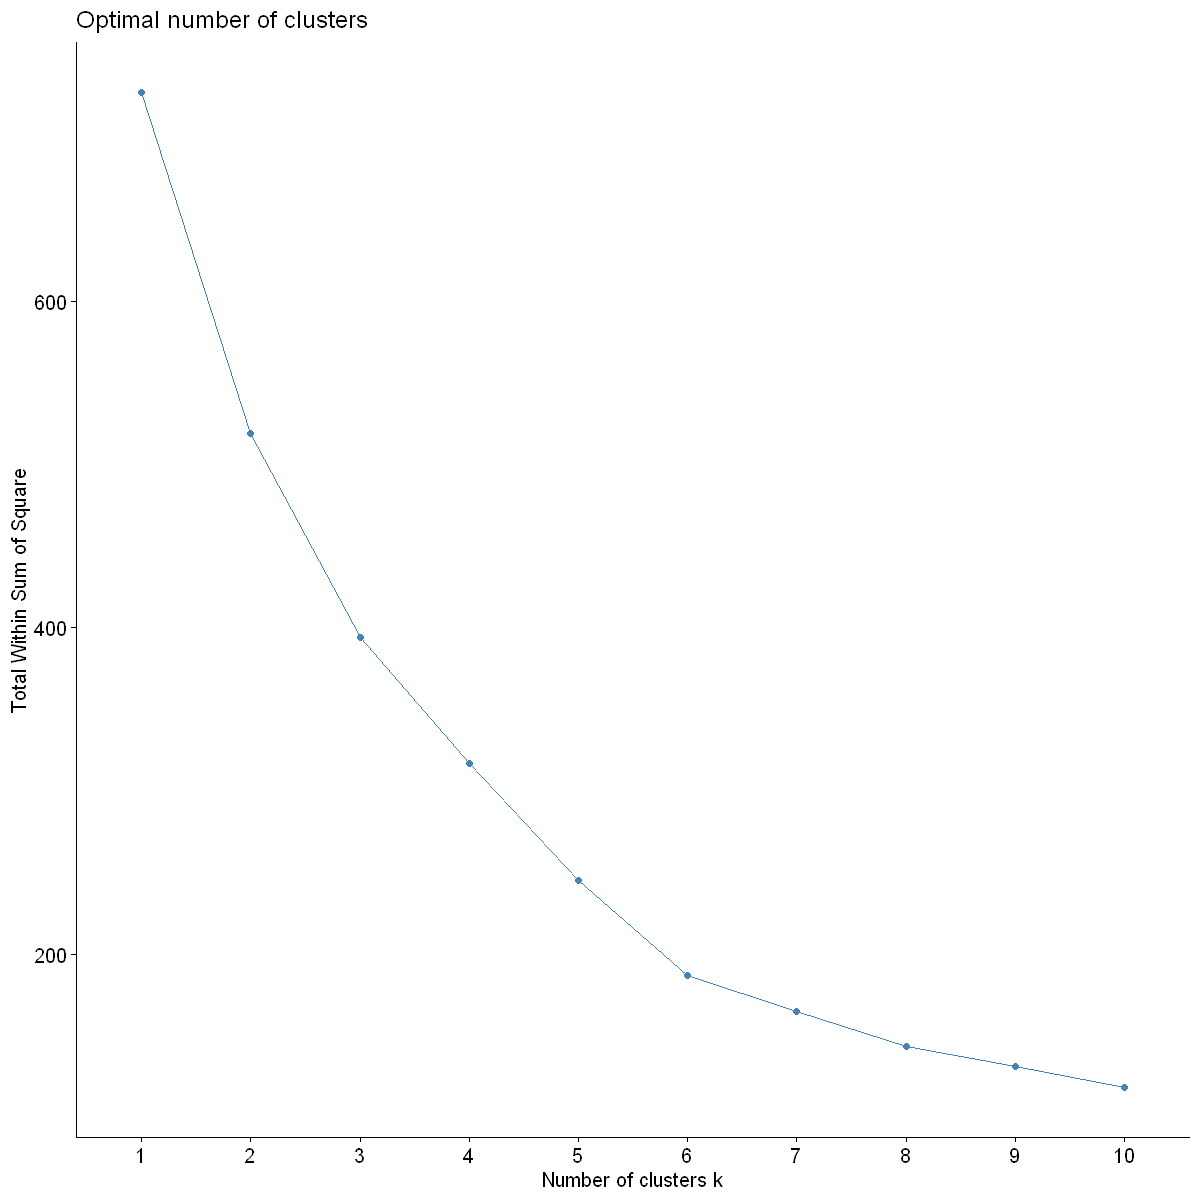

In [34]:
#Méthode du coude
options(repr.plot.width=10, repr.plot.height=10)
fviz_nbclust(Fichier_numérique_scale, hcut, method = "wss") # méthode de la somme des carrés intra-cluster

D'après cette méthode, on voit une perte d'inertie moins significative à partir de k =6

- Méthode du coude : solution à 6 clusters suggérée


##### <span style="color:lightseagreen">Méthodes statistiques Silhouhette </span>

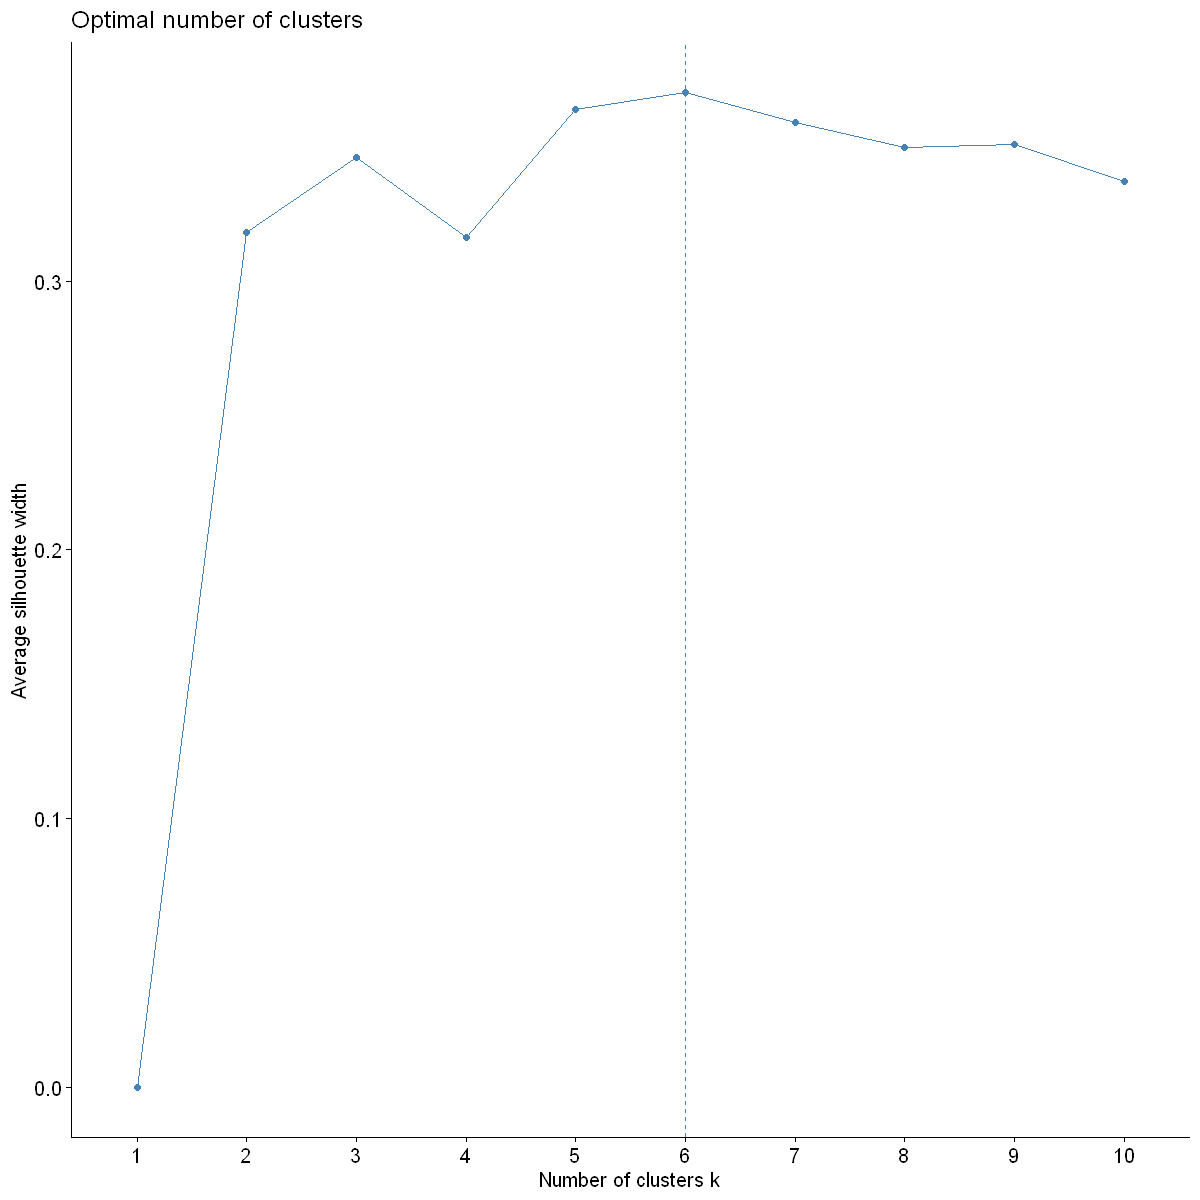

In [35]:
# Méthode du coefficient de silhouette
fviz_nbclust(Fichier_numérique_scale, hcut, method = "silhouette") # méthode du coefficient de silhouette

- Méthode des silhouettes : solution à 6 clusters suggérée

<span style="color:firebrick"> Les 2 méthodes convergent vers le même résultat, qui est de prendre en compte 6 clusters.</span>

- <span style="color:navy">Classification hiérarchique avec 6 clusters</span>

   <span style="color:indigo"> Méthode ward </span>

In [36]:
#Calcul du CAH avec 6 clusters
#hcpc inclu les dimensions de l'ACP
hc.ward <- HCPC(res.pca3, method = "ward", nb.clust = 6)

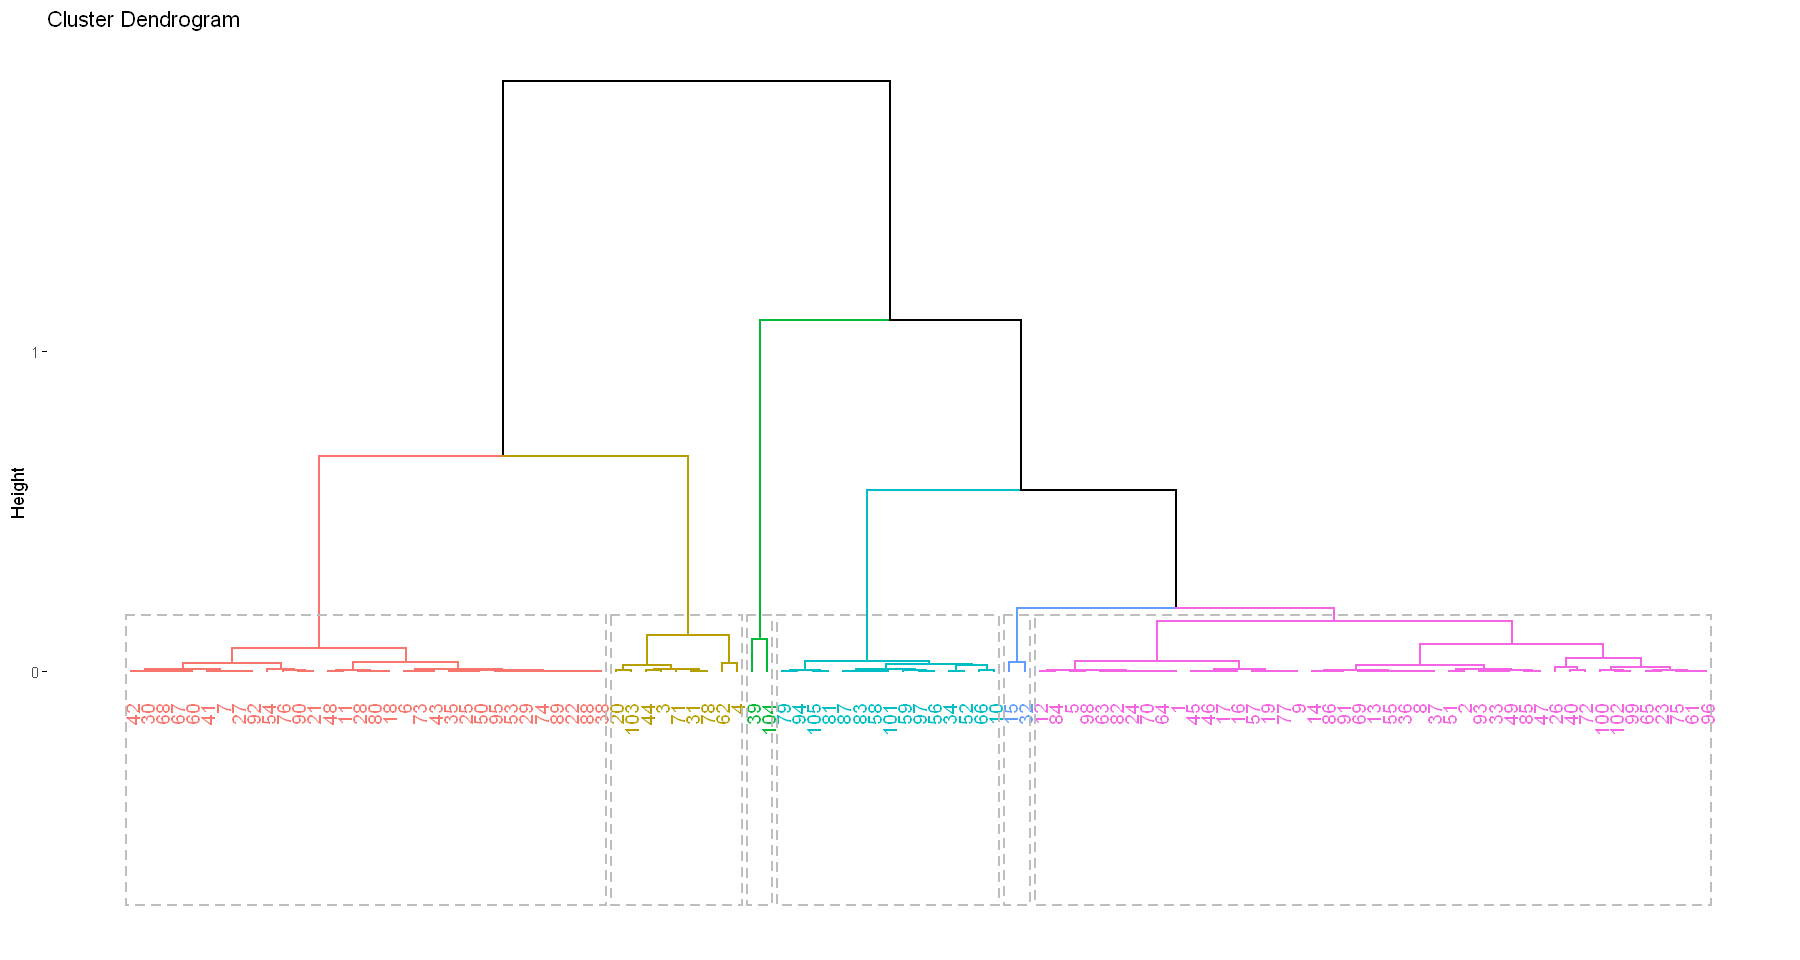

In [37]:
#dendrogramme
options(repr.plot.width=15, repr.plot.height=8)
fviz_dend(hc.ward, rect = TRUE)  # Afficher le dendrogramme avec les clusters rectangulaires

- <span style="color:navy">Individus représentatifs de chaque groupe:</span> 

In [38]:
hc.ward$desc.ind$para

Cluster: 1
       59        97       101        56        83 
0.2953718 0.4339251 0.5031663 0.5239213 0.5780395 
------------------------------------------------------------ 
Cluster: 2
       14        36        37        86        55 
0.2322628 0.2941571 0.2941593 0.3317467 0.3502200 
------------------------------------------------------------ 
Cluster: 3
      32       15 
1.201268 1.201268 
------------------------------------------------------------ 
Cluster: 4
     104       39 
2.279831 2.279831 
------------------------------------------------------------ 
Cluster: 5
       95        74        53        29        38 
0.1238613 0.2603674 0.2619428 0.3162064 0.3218663 
------------------------------------------------------------ 
Cluster: 6
       44         3        20        31        78 
0.5326634 0.6819369 0.7132234 0.9678144 1.0943264 

Pour chaque groupe, les 5 meilleurs individus les plus proches du centre du cluster sont affichés. Les individus représentatifs pour chaque groupe sont: 
- Groupe 1: Mali, Togo, Zimbabwe, Madagascar, Tanzanie
- Groupe 2: Bosnie, Géorgie, Honduras, Serbie, Macédoine
- Groupe 3: Russie, Brésil
- Groupe 4: USA, Inde
- Groupe 5: Tchéquie, Portugal, Lituanie, Estonie, Hongrie
- Groupe 6: Japon, Allemagne, Hong_Kong Chine, France, Royaume_Uni

- <span style="color:navy"> Caractéristique des variables:</span> 

In [39]:
hc.ward$desc.var$quanti

,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
PIB,-3.985678,3902.701333,2.669094e+04,4969.0832844,2.380398e+04,6.728768e-05
Stabilité_Pol,-5.136148,-1.162667,-1.990476e-02,0.7946527,9.263163e-01,2.804275e-07
Pop_Assainissement_sécu,-5.951821,18.104667,5.965771e+01,8.5843710,2.906659e+01,2.651752e-09
Pop_Assainissement_base,-8.426646,29.333333,8.234457e+01,21.0369655,2.619113e+01,3.557129e-17
,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
Stabilité_Pol,-2.418681,-0.2943902,-1.990476e-02,0.775981,9.263163e-01,1.557687e-02
Importation_Qté,-2.457643,40388.6985366,8.837254e+04,72237.735463,1.593657e+05,1.398523e-02
Pop_Assainissement_sécu,-3.700878,46.4787805,5.965771e+01,20.496109,2.906659e+01,2.148543e-04
PIB,-5.204345,11513.5500000,2.669094e+04,5923.836036,2.380398e+04,1.946820e-07
,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value


- <span style="color:navy">Axes principaux associées aux clusters:</span> 


In [40]:
hc.ward$desc.axes$quanti

,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
Dim.1,-6.908819,-2.829892,-5.146677e-16,0.5842972,1.705325,4.887045e-12
,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
Dim.1,-3.409633,-0.7123543,-5.146677e-16,0.6089057,1.705325,0.0006505041
,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
Dim.2,3.440589,2.987668,-8.33989e-17,0.8009681,1.233993,0.0005804504
,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
Dim.2,8.065173,7.003471,-8.339890e-17,0.2094413,1.2339930,7.313231e-16
Dim.3,-4.059870,-2.714782,3.604921e-17,0.5432103,0.9502455,4.909997e-05
,v.test,Mean in category,Overall mean,sd in category,Overall sd,p.value
Dim.1,6.598878,1.5276851,-5.146677e-16,0.6118053,1.7053247,4.142799e-11


Les résultats ci-dessus indiquent que :

- Les individus dans les groupes 1 et 2 ont des coordonnées élevées sur l’axe 1.
- Les individus du groupe 3 ont des coordonnées élevées sur la deuxième axe.
- Les autres groupes ont des coordonnées élevés sur l'ensemble des 3 axes.


- <span style="color:navy">Visualiser les individus sur les dimensions de l'ACP et colorer par groupes</span>

Warning message:
"ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


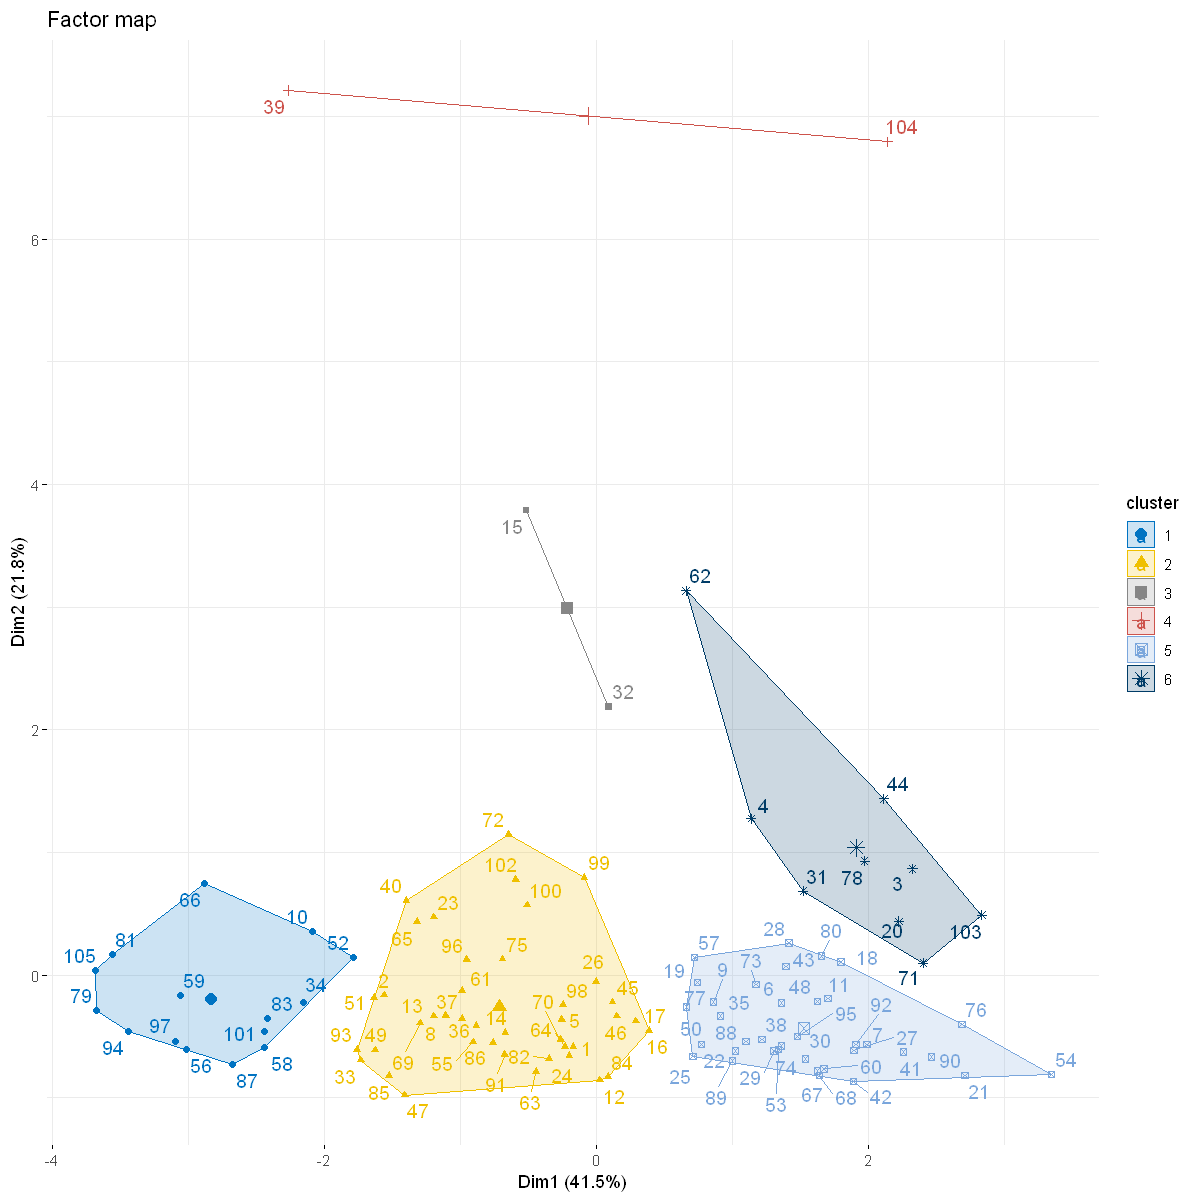

In [41]:
options(repr.plot.width=10, repr.plot.height=10)
fviz_cluster(hc.ward,
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
             )

Warning message:
"ggrepel: 79 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


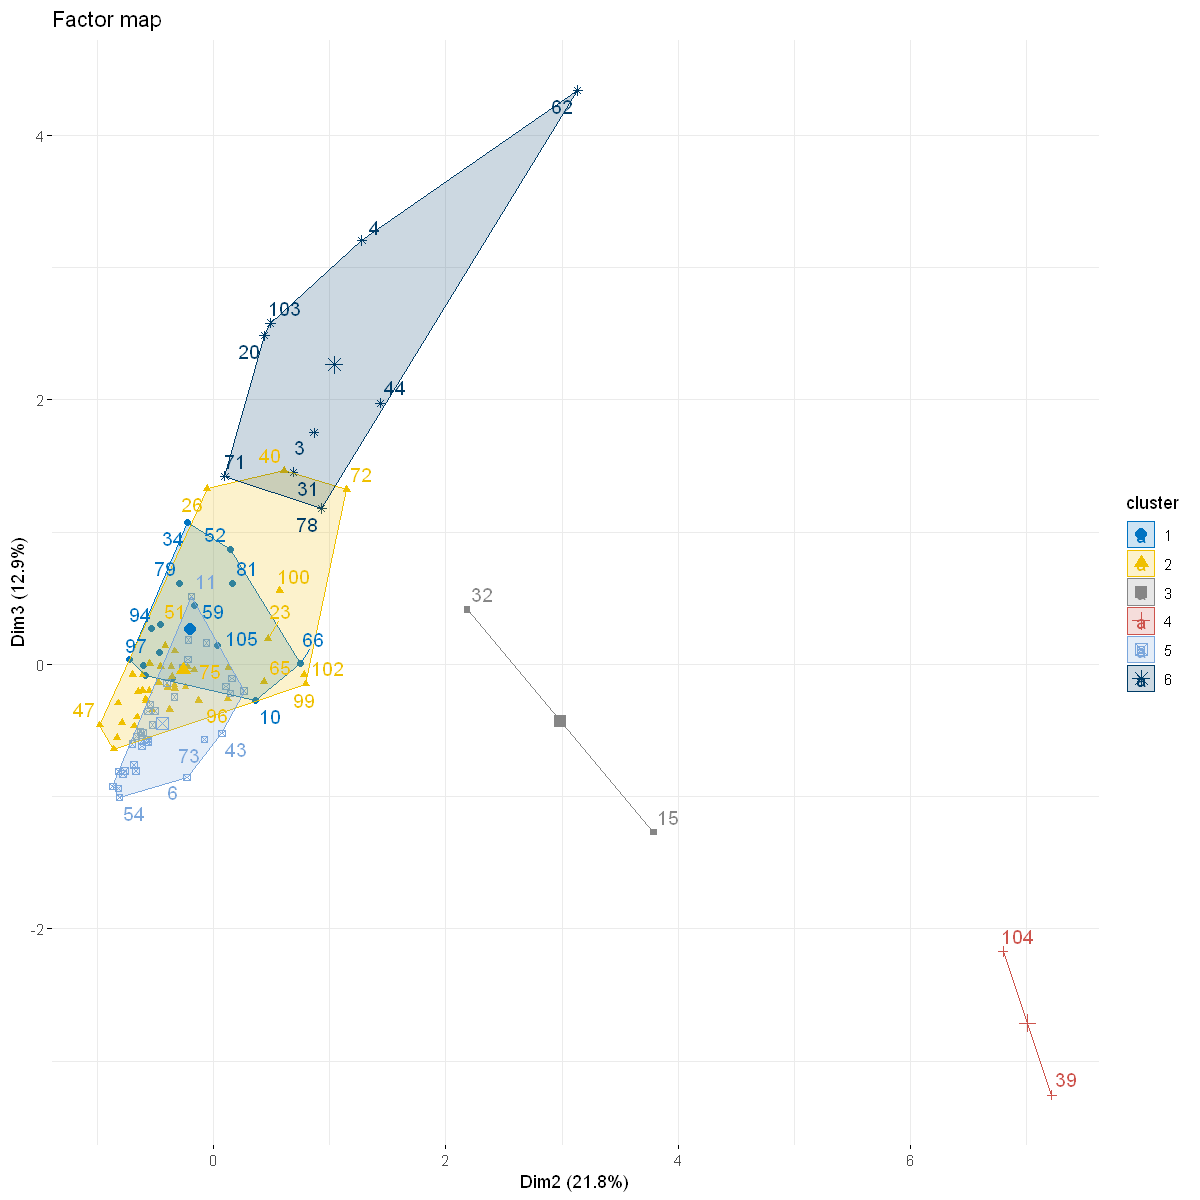

In [42]:
fviz_cluster(hc.ward,
             axes=c(2,3),
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
            )


Warning message:
"ggrepel: 36 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


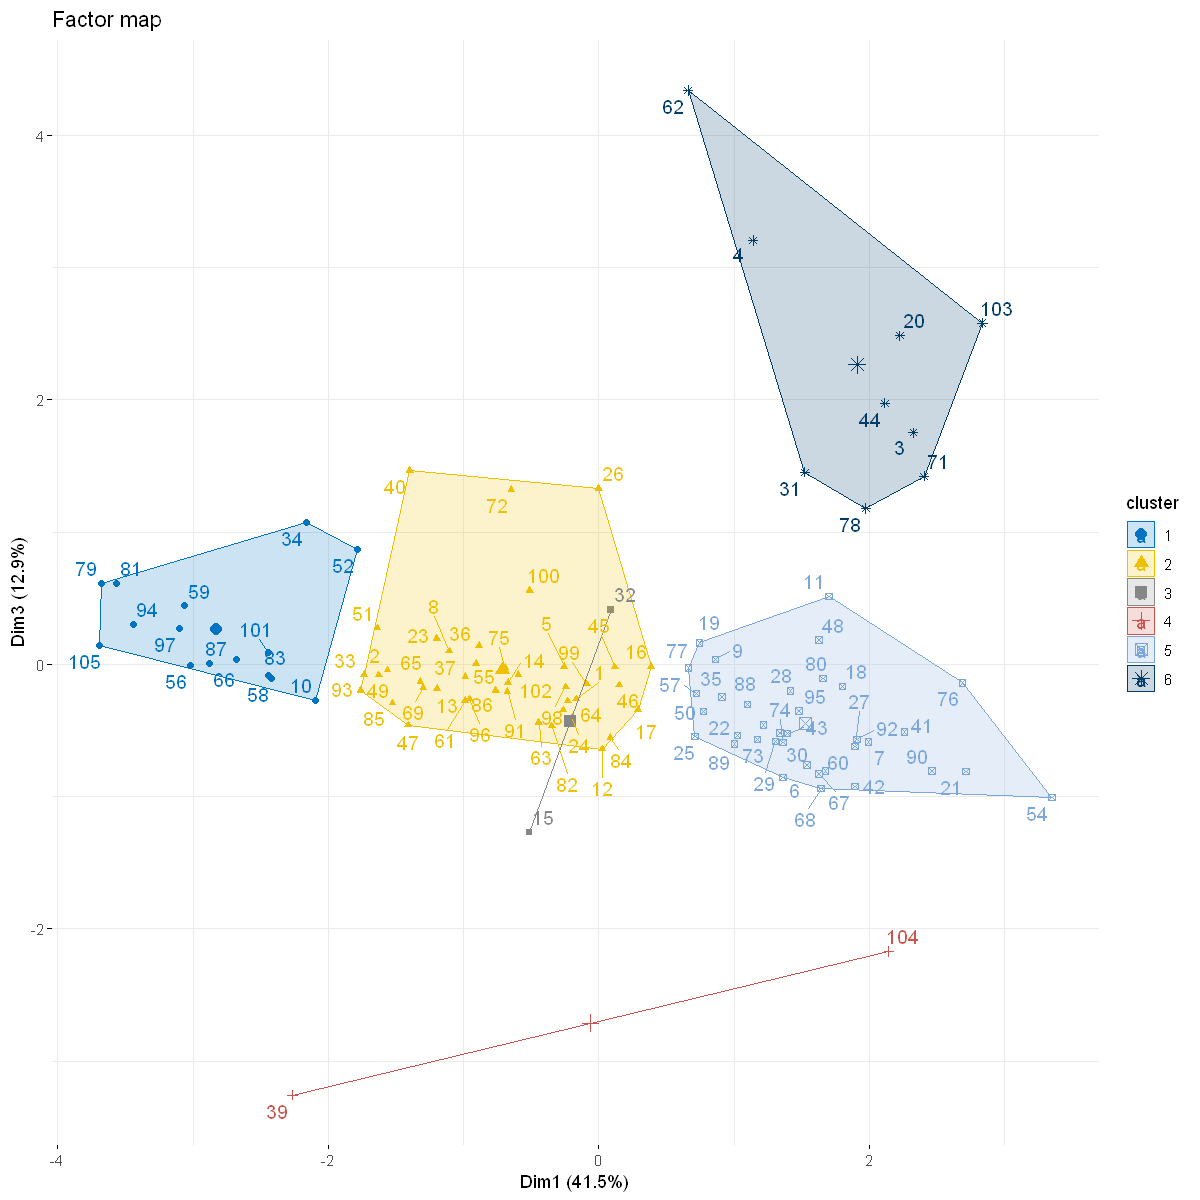

In [43]:
fviz_cluster(hc.ward,
             axes=c(1,3),
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
            )

- <span style="color:navy">Données d’origine avec la colonne cluster:</span> 


In [44]:
# Extraire la colonne Zone du fichier final
Zone <- Fichier_final[, 2]
hc.ward$data.clust <- cbind(Zone, hc.ward$data.clust)
hc.ward$data.clust

Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Albanie,2870362,23050.38,32180.28,13248.75,47.45,98.88,0.24,2
Algérie,42679711,5.62,263055.24,11406.38,17.95,86.22,-0.92,2
Allemagne,83081350,482983.66,919105.15,52977.78,97.07,99.00,0.60,6
Arabie saoudite,35397224,640715.39,1329242.95,46571.40,57.25,99.00,-0.63,6
Arménie,2821132,35786.65,44138.53,12775.98,66.95,93.75,-0.51,2
Australie,25303574,2151.42,1171442.17,48853.85,72.83,99.00,0.91,5
Autriche,8869561,46427.78,108184.36,54280.68,99.00,99.00,0.93,5
Azerbaïdjan,10210957,27058.24,132308.81,14257.67,21.90,96.10,-0.72,2
Bahreïn,1475819,56233.44,66754.62,45236.30,90.30,99.00,-0.76,5


- <span style="color:navy">Représentation graphiques des clusters par rapport aux variables</span> 

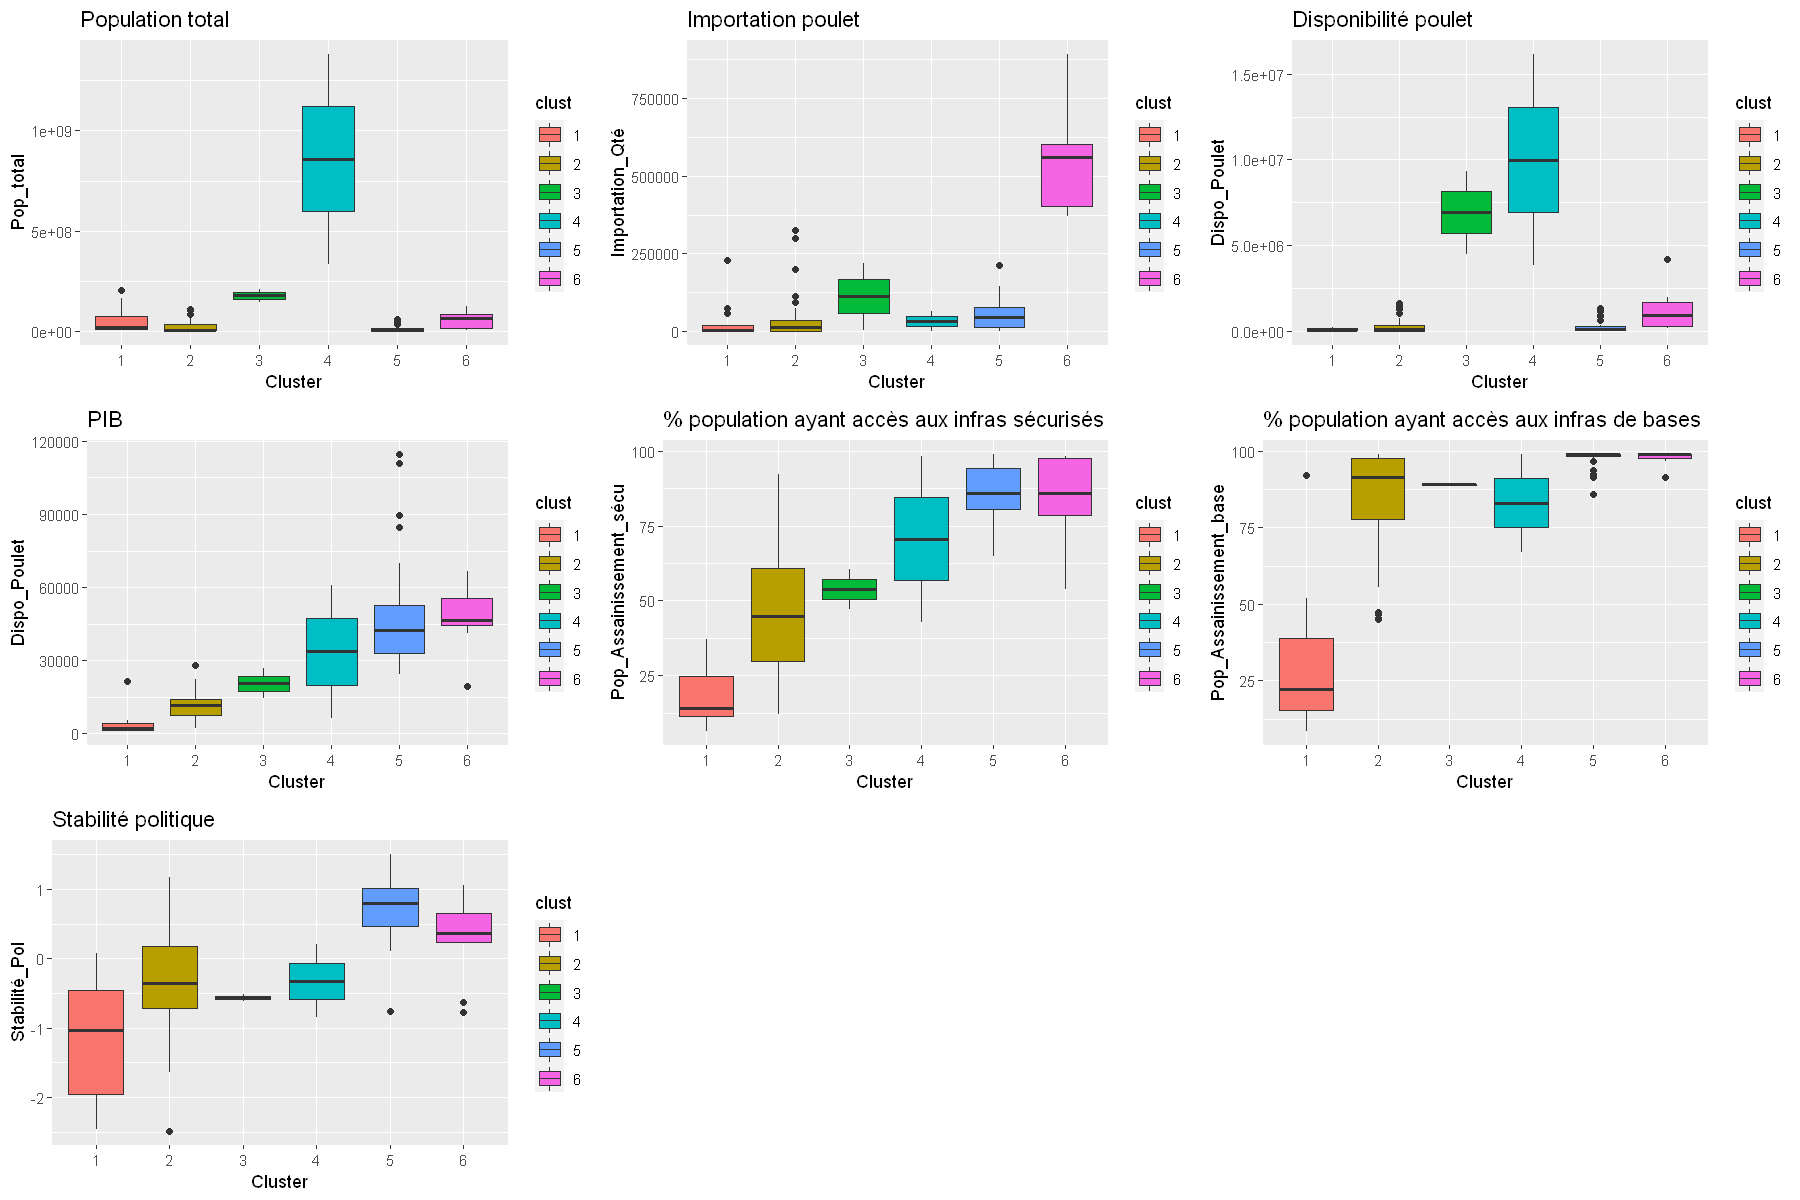

In [81]:
data <- hc.ward$data.clust
options(repr.plot.width=15, repr.plot.height=10)
# Créer un boxplot pour chaque variable en fonction du cluster
plot1 <- ggplot(data, aes(x = factor(clust), y = Pop_total, fill=clust)) + 
  geom_boxplot() +
  labs(title="Population total",x="Cluster", y = "Pop_total")
    
plot2 <- ggplot(data, aes(x = factor(clust), y = Importation_Qté, fill=clust)) + 
  geom_boxplot() +
  labs(title="Importation poulet",x="Cluster", y = "Importation_Qté")
 
plot3 <- ggplot(data, aes(x = factor(clust), y = Dispo_Poulet, fill=clust)) + 
  geom_boxplot() +
  labs(title="Disponibilité poulet",x="Cluster", y = "Dispo_Poulet")
  
plot4 <- ggplot(data, aes(x = factor(clust), y = PIB, fill=clust)) + 
  geom_boxplot() +
  labs(title="PIB", x="Cluster", y = "Dispo_Poulet")

plot5 <- ggplot(data, aes(x = factor(clust), y = Pop_Assainissement_sécu, fill=clust)) + 
  geom_boxplot() +
  labs(title="% population ayant accès aux infras sécurisés",x="Cluster", y = "Pop_Assainissement_sécu")
  
plot6 <- ggplot(data, aes(x = factor(clust), y = Pop_Assainissement_base, fill=clust)) + 
  geom_boxplot() +
  labs(title="% population ayant accès aux infras de bases",x="Cluster", y = "Pop_Assainissement_base")
  
plot7 <- ggplot(data, aes(x = factor(clust), y = Stabilité_Pol, fill=clust)) + 
  geom_boxplot() +
  labs(title="Stabilité politique",x="Cluster", y = "Stabilité_Pol")

# Affichage des graphiques côte à côte
grid.arrange(plot1, plot2, plot3, plot4, plot5, plot6, plot7, ncol = 3, nrow = 3)



Grâce à cette visualisation, on peut identifier les variables qui contribuent à la segmentation des clusters et à mieux comprendre les caractéristiques distinctes de chaque cluster. 
- Par exemple concernant le cluster 4 en bleu turquoise, on peut dire que ce sont les variables populations et dispo_poulet qui sont les plus contributeurs du cluster. On voit celà avec la taille des boites.
- Quand on regarde la répartitions des valeurs concernant les variables économiques types PIB, ou accès aux infrastructures sécurisés, on remarque la médiane monte à mesure que l'on passe du cluster 1 au cluster 6. Celà fait un tri naturel qui indique que les pays les plus pauvres se retrouvent dans les premiers clusters pour terminer par les pays riches dans les derniers clusters.

-  <span style="color:navy">Caractéristiques des clusters par rapport aux axes</span>

In [46]:
# Créer un data.frame avec des sauts de ligne dans la colonne "variables"
caract_cluster <- data.frame(Clusters = c(1,2,3,4,5,6),
                          Dimensions = c("Puissance économique du Pays","Puissance économique du Pays","Sécurité du marché alimentaire % à la démographie","Sécurité du marché alimentaire + Flux d'importation de Poulet", "Puissance économique du Pays","Flux d'importation de Poulet + Puissance économique du Pays"),
                          Caractéristique = c("Niveau économique faible","Stabilité politique rassurant avec niveau d'importation élevé","Disponibilité en poulet élevé", "Population élevé dépendant de la disponibilité en poulet","Niveau infrascture et économique élevé", "Pays riche qui importe beaucoup de poulet"),
                          Individus_representatifs = c("Mali, Togo, Zimbabwe, Madagascar, Tanzanie", "Bosnie, Géorgie, Honduras, Serbie, Macédoine", "Russie, Brésil","USA, Inde", "Tchéquie, Portugal, Lituanie, Estonie, Hongrie","Japon, Allemagne, Hong_Kong Chine, France, Royaume_Uni"),
                          stringsAsFactors = FALSE)

# Afficher le data.frame avec les sauts de ligne dans la colonne "variables"
caract_cluster


Clusters,Dimensions,Caractéristique,Individus_representatifs
<dbl>,<chr>,<chr>,<chr>
1,Puissance économique du Pays,Niveau économique faible,"Mali, Togo, Zimbabwe, Madagascar, Tanzanie"
2,Puissance économique du Pays,Stabilité politique rassurant avec niveau d'importation élevé,"Bosnie, Géorgie, Honduras, Serbie, Macédoine"
3,Sécurité du marché alimentaire % à la démographie,Disponibilité en poulet élevé,"Russie, Brésil"
4,Sécurité du marché alimentaire + Flux d'importation de Poulet,Population élevé dépendant de la disponibilité en poulet,"USA, Inde"
5,Puissance économique du Pays,Niveau infrascture et économique élevé,"Tchéquie, Portugal, Lituanie, Estonie, Hongrie"
6,Flux d'importation de Poulet + Puissance économique du Pays,Pays riche qui importe beaucoup de poulet,"Japon, Allemagne, Hong_Kong Chine, France, Royaume_Uni"


PS: Les individus représentatifs sont les plus proches du centroides.

-  <span style="color:navy">Heatmap de corrélations </span>

In [47]:
clust.table <- hc.ward$data.clust
C1 <- subset(clust.table, clust.table$clust==1)
C2 <- subset(clust.table, clust.table$clust==2)
C3 <- subset(clust.table, clust.table$clust==3)
C4 <- subset(clust.table, clust.table$clust==4)
C5 <- subset(clust.table, clust.table$clust==5)
C6 <- subset(clust.table, clust.table$clust==6)
clust.table<-clust.table[order(clust.table$clust),]
# Changer le type de la variable clust en entier
clust.table[, clust := as.integer(clust)]

In [48]:
# Agréger les données par la variable "clust" et calculer la somme de chaque variable
donnees_agreg <- clust.table[,2:9][, lapply(.SD, mean), by = clust]
scale <- scale(donnees_agreg)


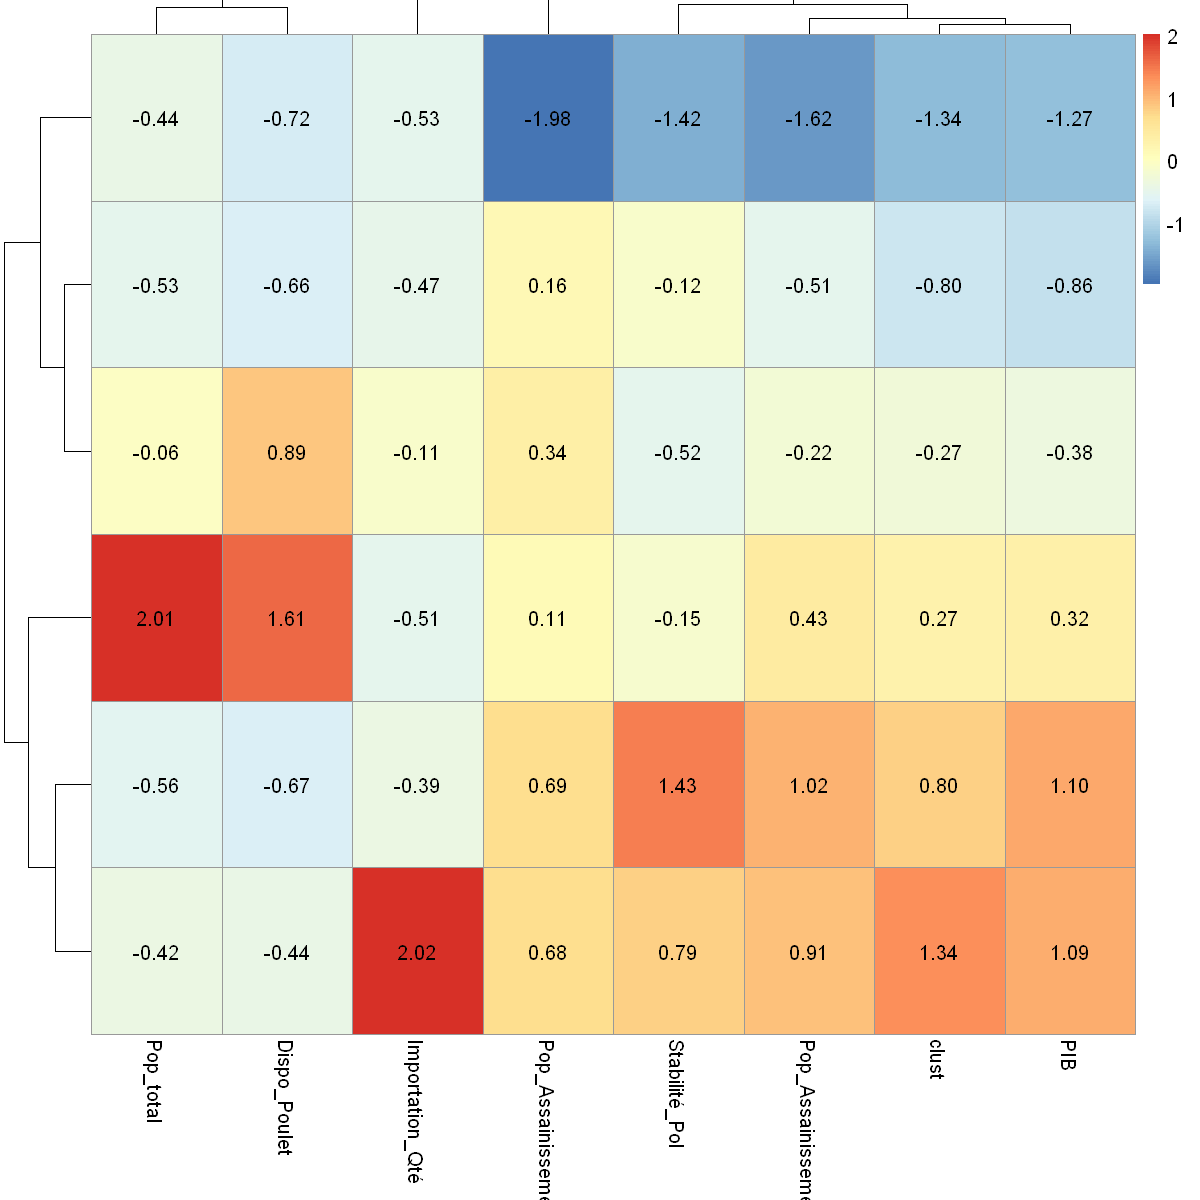

In [49]:
set.seed(5)
pheatmap(scale, cellheight = 100, 
         display_numbers = TRUE,
         number_color = "black", 
         fontsize_number = 12, 
         main = "Pheatmap avec CAH clusters",
         fontsize = 12)


-  <span style="color:navy">Ciblage des clusters: </span>

Avec la méthode de CAH, 2 groupes ressortent du lot, ce sont les groupes 5 et 6
- Si le plus important pour l'entreprise est le CA, je recommande le groupe 6. Ce sont des pays riches qui importent beaucoup de poulet
- Si le plus important pour l'entreprise est la sécurité des employés pour travailler dans un environnement non risqué, dans un pays confortable du point de vue infrastructure, je recommande le groupe 5. 

### <span style="color:lightseagreen"> K-means </span>

-   <span style="color:navy">Standariser et centrer les données </span>

Nous avons déjà effectué cette étape précédemment. Et concernant le nombre de dimension, on se basera sur le nombre de 3 calculé  dans l'ACP.

-   <span style="color:navy">Calculer le nombre de clusters optimal </span>

##### <span style="color:lightseagreen">Méthodes statistiques Elbow </span>

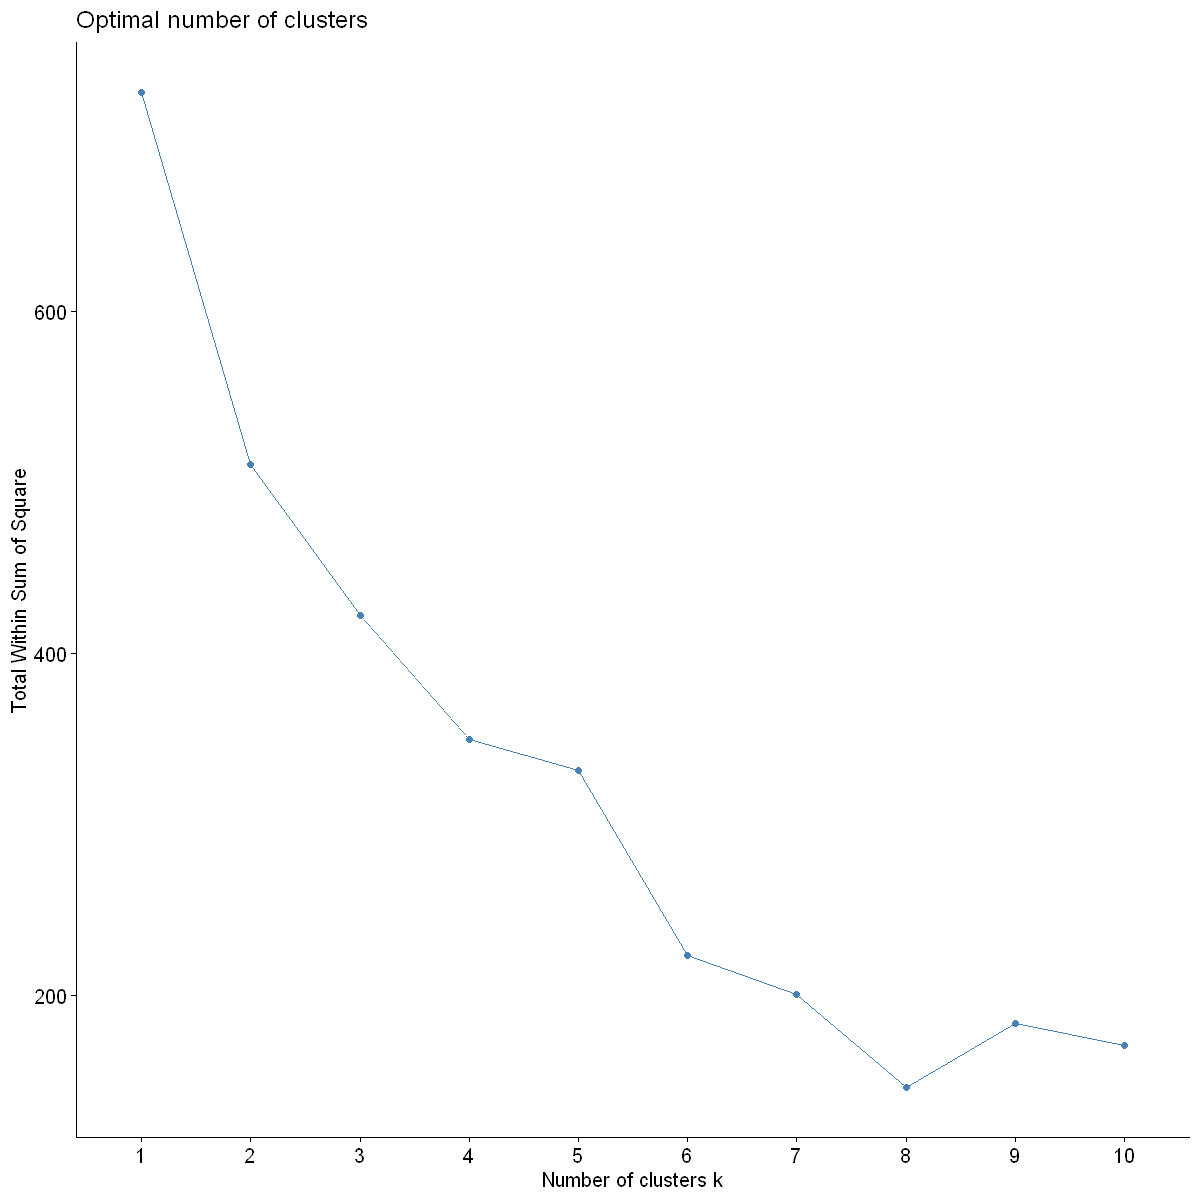

In [50]:
#Méthode du coude
fviz_nbclust(Fichier_numérique_scale, kmeans, method = "wss") # méthode de la somme des carrés intra-cluster

D'après ce graphique, le coude semble se situer quelque part entre k=4 et k=6. Nous allons utiliser une autre méthode pour prendre une décision

##### <span style="color:lightseagreen">Méthodes statistiques Silhouhette </span>


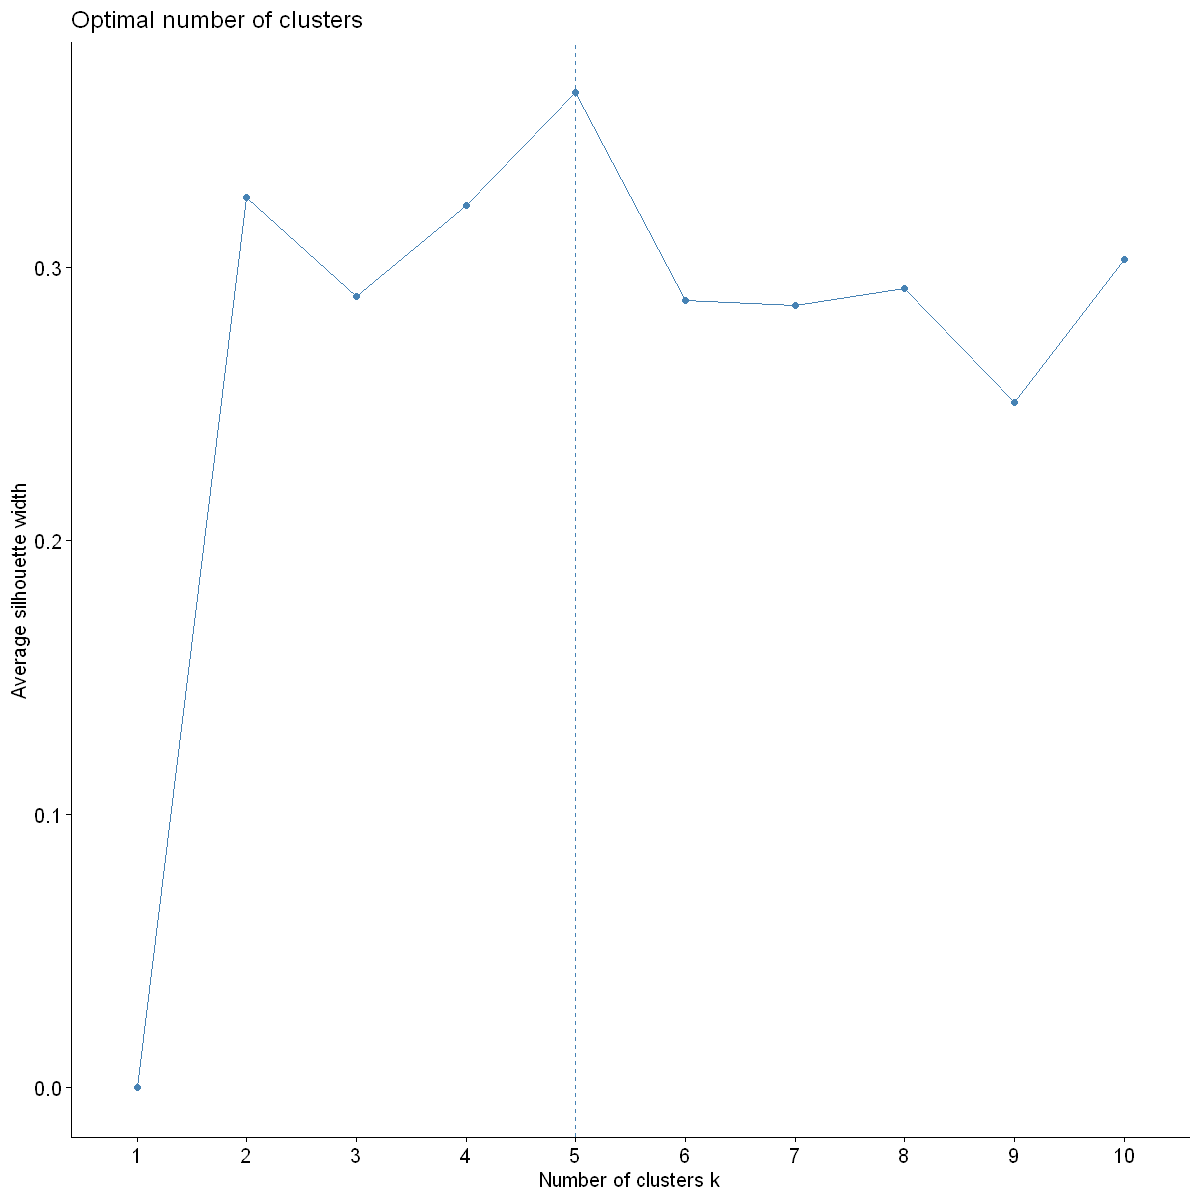

In [51]:
# Méthode du coefficient de silhouette
fviz_nbclust(Fichier_numérique_scale, kmeans, method = "silhouette") # méthode du coefficient de silhouette

Selon cette deuxième méthode, le k suggéré est de 5.

- <span style="color:navy">Effectuer une analyse K-means et centroîdes </span>

In [52]:
kmeans <- kmeans(Fichier_numérique_scale, centers = 5, nstart = 20)
#Le paramètre nstart spécifie le nombre de fois que l'algorithme de k-means sera exécuté avec différentes initialisations aléatoires des centres. 

In [53]:
kmeans

K-means clustering with 5 clusters of sizes 19, 37, 3, 37, 9

Cluster means:
    Pop_total Importation_Qté Dispo_Poulet         PIB Pop_Assainissement_sécu
1 -0.01858028      -0.4236469  -0.32164398 -1.00366141              -1.3087012
2 -0.12971237      -0.2446726  -0.09081994 -0.56918675              -0.4130635
3  4.21905721      -0.4097905   4.71004034  0.02349462               0.1087317
4 -0.22744585      -0.1988357  -0.20174894  0.86647262               0.8819686
5  0.10118979       2.8542744   0.31179590  0.88883397               0.7988488
  Pop_Assainissement_base Stabilité_Pol
1             -1.95322265    -0.7567004
2              0.27587084    -0.4673176
3              0.09811605    -0.3904647
4              0.57741555     0.8024974
5              0.58280952     0.3496719

Clustering vector:
  [1] 2 2 5 5 2 4 4 2 4 1 4 2 2 2 3 4 2 4 4 5 4 4 2 2 4 2 4 4 4 4 5 2 1 1 4 2 2
 [38] 4 3 2 4 4 4 5 2 2 1 4 1 4 2 2 4 4 2 1 4 1 1 4 2 5 2 2 2 1 4 4 2 2 5 2 4 4
 [75] 2 4 4 5 1 4 1 2 1 2 1 2

- <span style="color:navy">Visualiser les individus sur les dimensions de l'ACP et colorer par groupes</span>

Warning message:
"ggrepel: 25 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


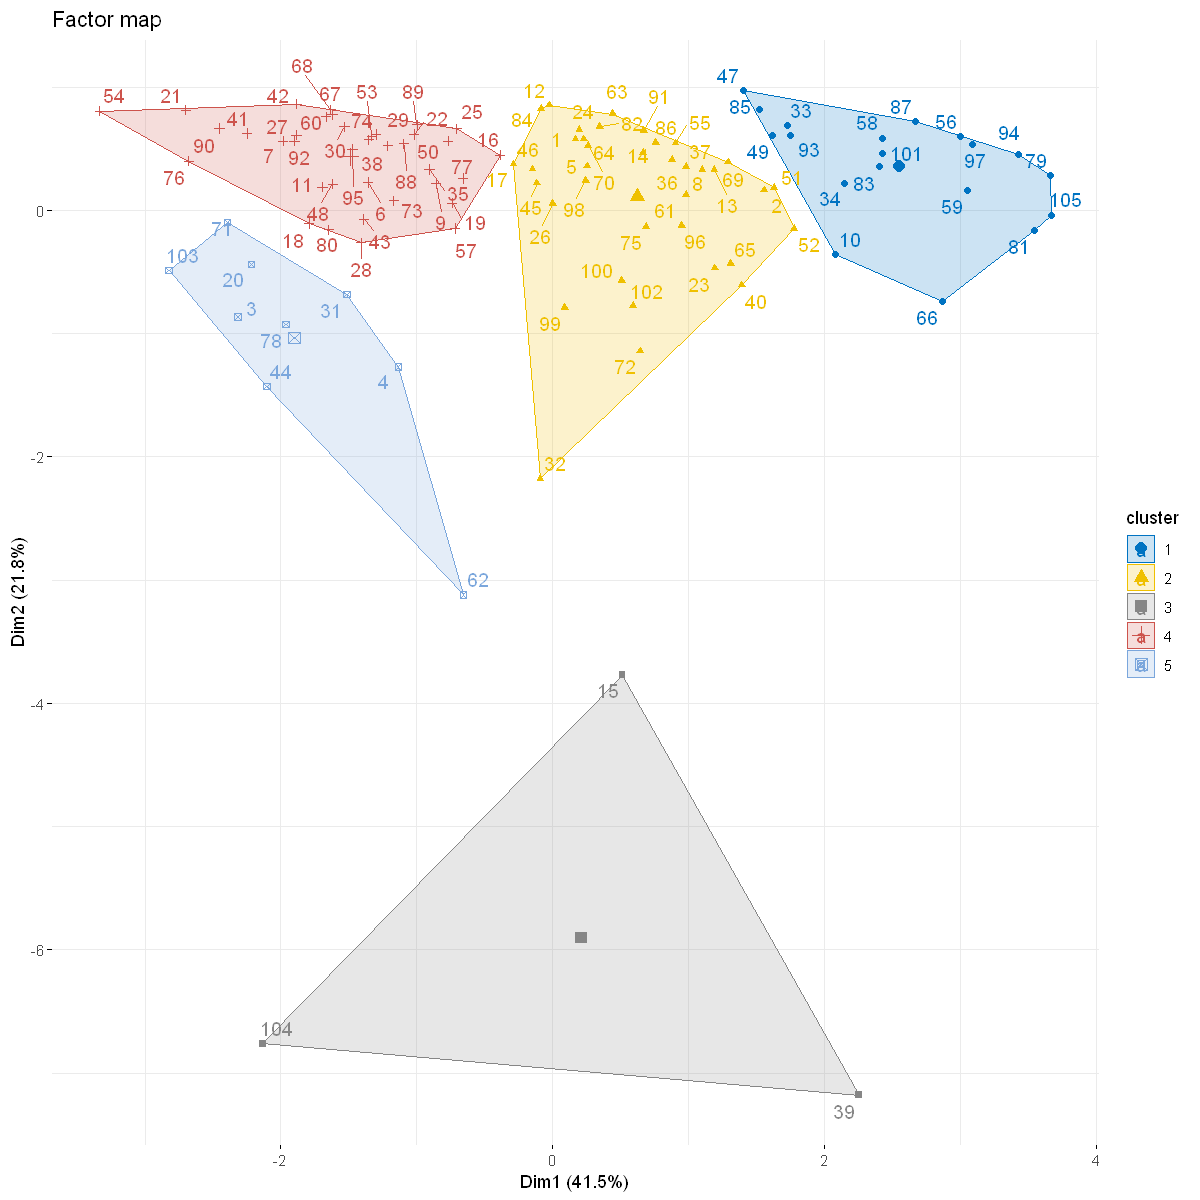

In [54]:
fviz_cluster(kmeans, data= Fichier_numérique,
             axes=c(1,2),
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
            )

Warning message:
"ggrepel: 78 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


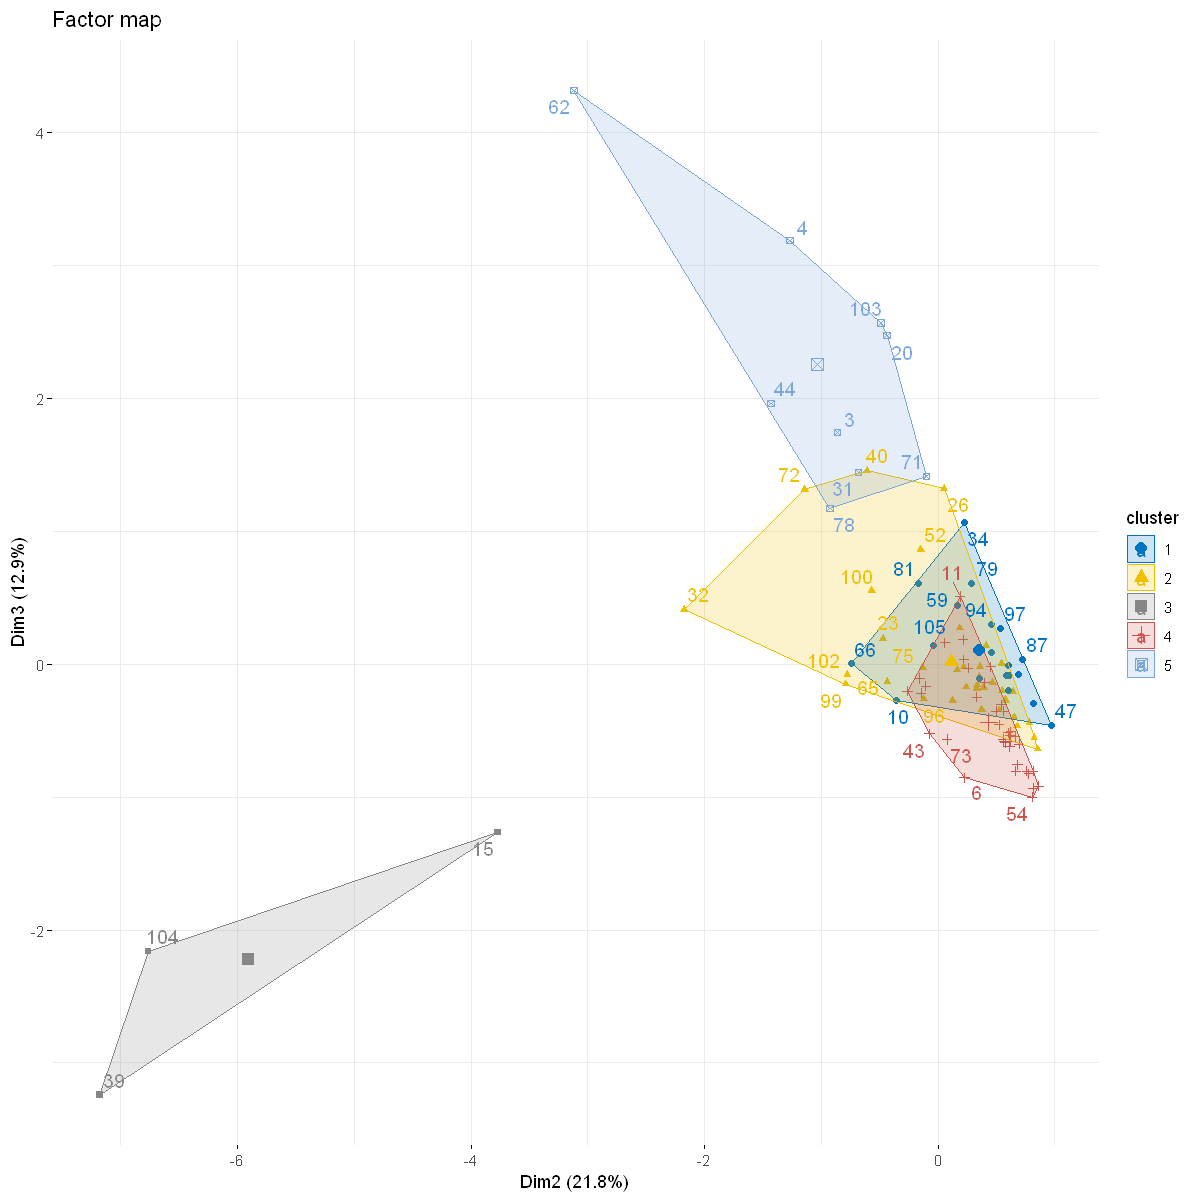

In [55]:
fviz_cluster(kmeans, data= Fichier_numérique,
             axes=c(2,3),
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
            )

Warning message:
"ggrepel: 37 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


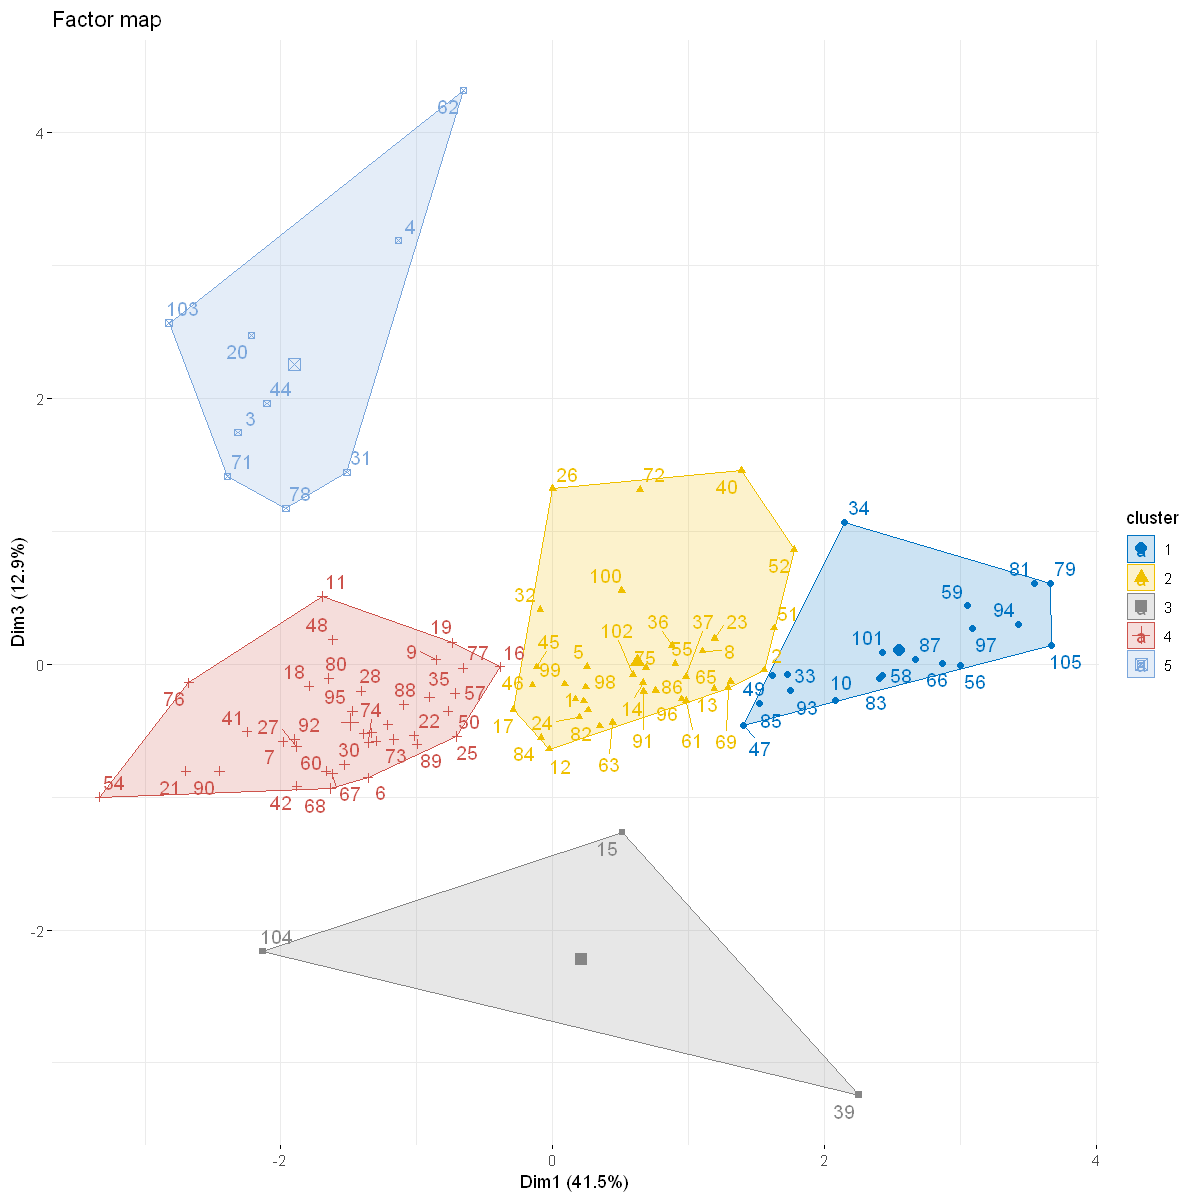

In [56]:
fviz_cluster(kmeans, data= Fichier_numérique,
             axes=c(1,3),
             repel = TRUE,            # Evite le chevauchement des textes
             show.clust.cent = TRUE, # Montre le centre des clusters
             palette = "jco",         # Palette de couleurs, voir ?ggpubr::ggpar
             ggtheme = theme_minimal(),
             main = "Factor map"
            )

-  <span style="color:navy">Fichier final avec les 2 types clusters</span>

In [57]:
données.cah <- hc.ward$data.clust
données.cah$cluster_Kmeans <- as.factor(kmeans$cluster)
données.cah

Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust,cluster_Kmeans
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Albanie,2870362,23050.38,32180.28,13248.75,47.45,98.88,0.24,2,2
Algérie,42679711,5.62,263055.24,11406.38,17.95,86.22,-0.92,2,2
Allemagne,83081350,482983.66,919105.15,52977.78,97.07,99.00,0.60,6,5
Arabie saoudite,35397224,640715.39,1329242.95,46571.40,57.25,99.00,-0.63,6,5
Arménie,2821132,35786.65,44138.53,12775.98,66.95,93.75,-0.51,2,2
Australie,25303574,2151.42,1171442.17,48853.85,72.83,99.00,0.91,5,4
Autriche,8869561,46427.78,108184.36,54280.68,99.00,99.00,0.93,5,4
Azerbaïdjan,10210957,27058.24,132308.81,14257.67,21.90,96.10,-0.72,2,2
Bahreïn,1475819,56233.44,66754.62,45236.30,90.30,99.00,-0.76,5,4


- <span style="color:navy">Représentation graphiques des clusters par rapport aux variables</span> 

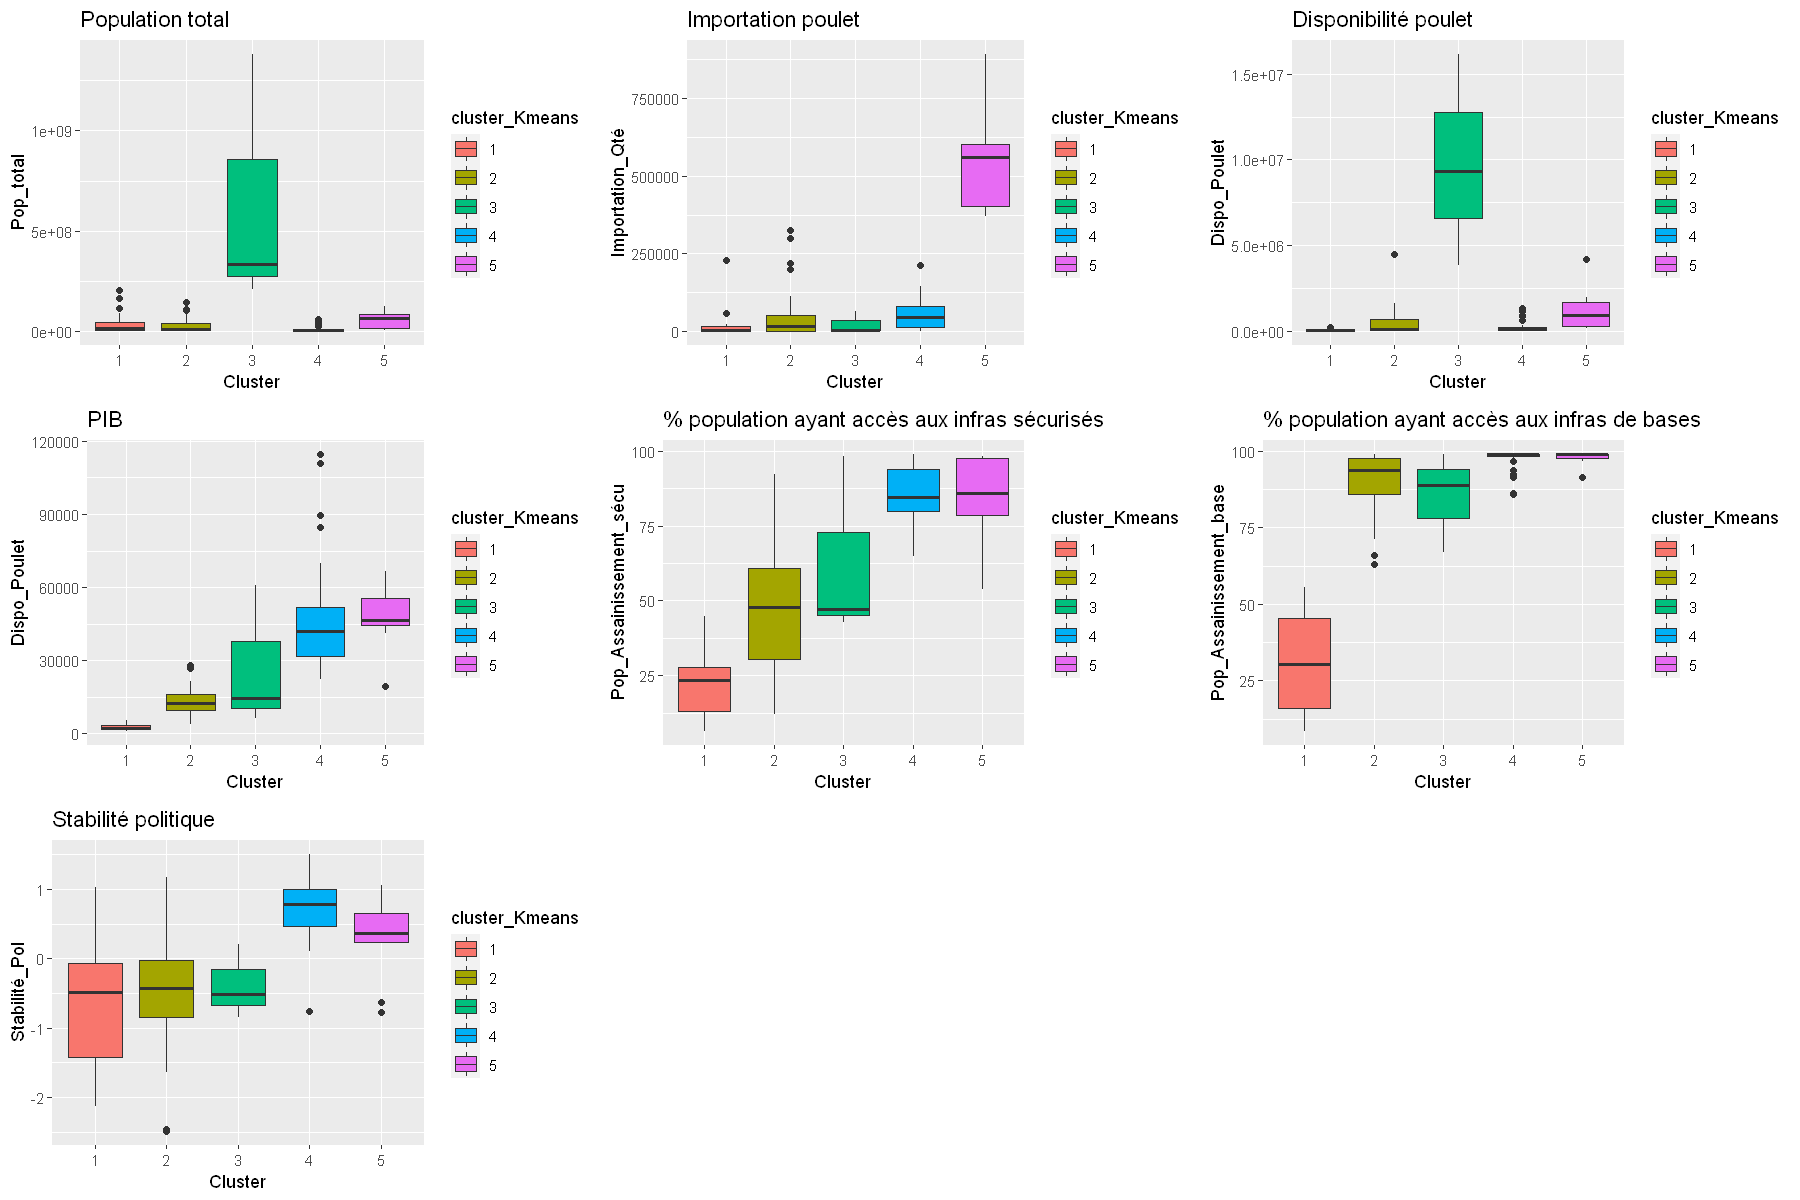

In [82]:
options(repr.plot.width=15, repr.plot.height=10)
# Créer un boxplot pour chaque variable en fonction du cluster
Plot1 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = Pop_total, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="Population total",x="Cluster", y = "Pop_total")
    
Plot2 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = Importation_Qté, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="Importation poulet",x="Cluster", y = "Importation_Qté")
 
Plot3 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = Dispo_Poulet, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="Disponibilité poulet",x="Cluster", y = "Dispo_Poulet")
  
Plot4 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = PIB, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="PIB", x="Cluster", y = "Dispo_Poulet")

Plot5 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = Pop_Assainissement_sécu, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="% population ayant accès aux infras sécurisés",x="Cluster", y = "Pop_Assainissement_sécu")
  
Plot6 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = Pop_Assainissement_base, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="% population ayant accès aux infras de bases",x="Cluster", y = "Pop_Assainissement_base")
  
Plot7 <- ggplot(données.cah, aes(x = cluster_Kmeans, y = Stabilité_Pol, fill=cluster_Kmeans)) + 
  geom_boxplot() +
  labs(title="Stabilité politique",x="Cluster", y = "Stabilité_Pol")

# Affichage des graphiques côte à côte
grid.arrange(Plot1, Plot2, Plot3, Plot4, Plot5, Plot6, Plot7, ncol = 3, nrow = 3)



- Ici, on peut dire quand on regarde la médiane au niveau stabilité politique, que ce sont les clusters 4 et 5 qui sont les plus stable (on a quand même quelques valeurs aberrantes, c'est à dire des pays plus à risque qui se retrouvent dans ces groupes)
- Pour le niveau économique, on a le même constat que pour l'étude du CAH
- Si on regarde le cluster 5 en rose, on peut dire que c'est la variable importation qui contribue le plus, et donc c'est ce cluster qui peut nous rapporter le plus de CA.

- <span style="color:navy">Heat map de corrélation</span>

In [60]:
c1 <- subset(données.cah, données.cah$cluster_Kmeans==1)
c2 <- subset(données.cah, données.cah$cluster_Kmeans==2)
c3 <- subset(données.cah, données.cah$cluster_Kmeans==3)
c4 <- subset(données.cah, données.cah$cluster_Kmeans==4)
c5 <- subset(données.cah, données.cah$cluster_Kmeans==5)
clust.kmeans<-données.cah[order(données.cah$cluster_Kmeans),]
# Changer le type de la variable clust en entier
clust.kmeans[, cluster_Kmeans := as.integer(cluster_Kmeans)]
# Supprimer colonnes corrélées
clust.kmeans[ , clust := NULL]

In [61]:
# Agréger les données par la variable "clust" et calculer la somme de chaque variable
kmeans_agreg <- clust.kmeans[,2:9][, lapply(.SD, mean), by = cluster_Kmeans]
scale_kmeans <- scale(kmeans_agreg)

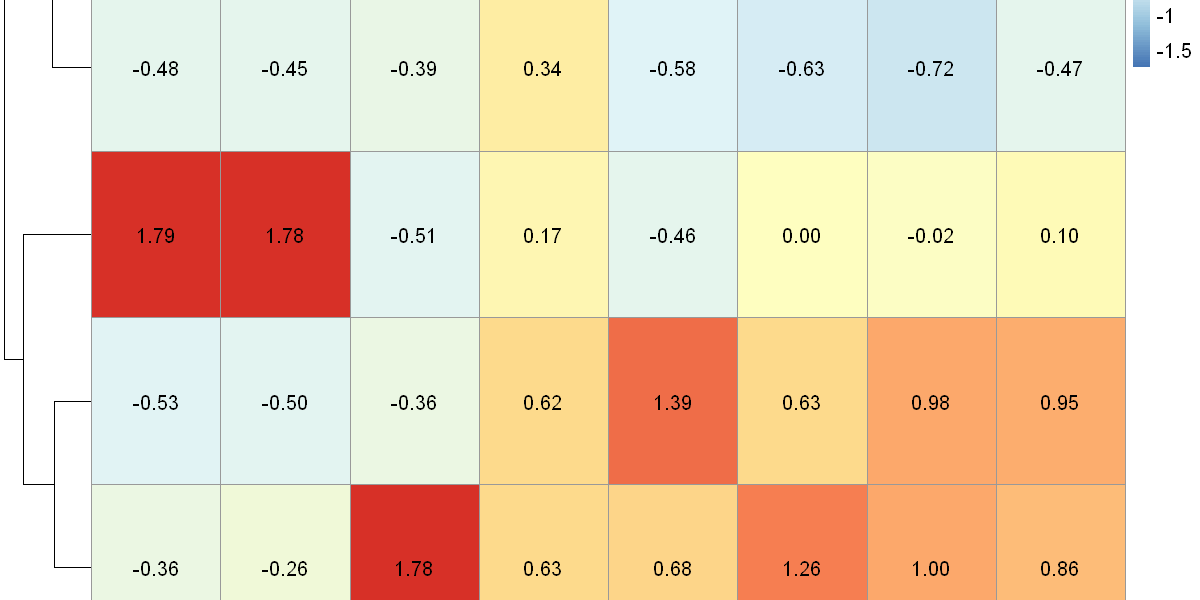

In [62]:
set.seed(5)
pheatmap(scale_kmeans, cellheight = 100, 
         display_numbers = TRUE,
         number_color = "black", 
         fontsize_number = 12, 
         main = "Pheatmap avec Kmeans clusters",
         fontsize = 12)

-  <span style="color:navy">Ciblage des clusters: </span>

Les 2 méthodes présentent un résultat assez similaire. Kmeans avec 5 groupe et CAH avec 6 groupes.

Avec la méthode de Kmeans, 2 groupes ressortent du lot également, et ce sont les groupes 4 et 5

- Si le plus important pour l'entreprise est le CA, je recommande le groupe 5. Ce sont des pays riches qui importent beaucoup de poulet
- Si le plus important pour l'entreprise est la sécurité des employés pour travailler dans un environnement non risqué, dans un pays confortable du point de vue infrastructure, je recommande le groupe 4.


### <span style="color:lightseagreen"> Comparaison des clusters entre Kmeans et CAH </span>

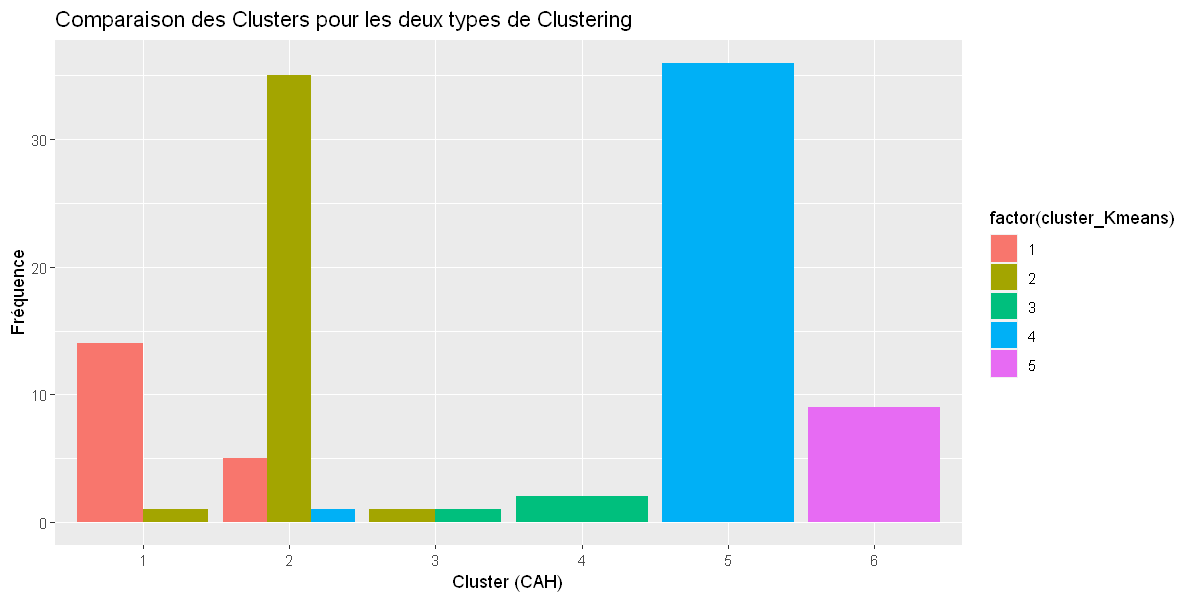

In [59]:
# Graphique en barres comparant les fréquences des clusters pour les deux types de clustering
options(repr.plot.width=10, repr.plot.height=5)
ggplot(données.cah, aes(x = factor(clust), fill = factor(cluster_Kmeans))) +
  geom_bar(position = "dodge") +
  xlab("Cluster (CAH)") +
  ylab("Fréquence") +
  ggtitle("Comparaison des Clusters pour les deux types de Clustering")


Sur ce graphique, on peut dire que les 2 méthodes donnent un résultat assez similaire. On a une distribution assez homogène au moins sur 3 clusters (4, 5 et 6). On retrouve les mêmes pays en gros quand on compare la constitution des groupes pour les 2 méthodes à quelques pays près.

## <span style="color:indianred"> Partie VI - Résultats </span>

- <span style="color:navy"> Afficher les pays des groupes retenues </span>

In [63]:
# Le groupe des pays riches qui importent beaucoup de poulet
C6
c5

Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Allemagne,83081350,482983.7,919105.2,52977.78,97.07,99.00,0.60,6
Arabie saoudite,35397224,640715.4,1329242.9,46571.40,57.25,99.00,-0.63,6
Chine - RAS de Hong-Kong,7486946,559471.1,245716.0,59100.90,85.93,96.50,0.37,6
France,64366630,390504.0,935468.7,44549.85,78.60,98.62,0.23,6
Japon,125713461,564728.8,1965622.0,41204.07,80.80,99.00,1.06,6
Mexique,124928374,893624.7,4178830.0,19300.85,53.70,91.35,-0.78,6
Pays-Bas,17358551,404184.1,155318.8,55564.47,97.50,97.70,0.87,6
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,66723393,370451.8,1687518.5,45853.70,98.10,99.00,0.37,6
Émirats arabes unis,9214511,602185.5,286524.8,66428.73,97.95,98.97,0.66,6


Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust,cluster_Kmeans
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Allemagne,83081350,482983.7,919105.2,52977.78,97.07,99.00,0.60,6,5
Arabie saoudite,35397224,640715.4,1329242.9,46571.40,57.25,99.00,-0.63,6,5
Chine - RAS de Hong-Kong,7486946,559471.1,245716.0,59100.90,85.93,96.50,0.37,6,5
France,64366630,390504.0,935468.7,44549.85,78.60,98.62,0.23,6,5
Japon,125713461,564728.8,1965622.0,41204.07,80.80,99.00,1.06,6,5
Mexique,124928374,893624.7,4178830.0,19300.85,53.70,91.35,-0.78,6,5
Pays-Bas,17358551,404184.1,155318.8,55564.47,97.50,97.70,0.87,6,5
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,66723393,370451.8,1687518.5,45853.70,98.10,99.00,0.37,6,5
Émirats arabes unis,9214511,602185.5,286524.8,66428.73,97.95,98.97,0.66,6,5



### <span style="color:lightseagreen"> Recommandations </span>

Quand on compare les 2 méthodes, nous avons les mêmes pays proposés si le plus important pour l'entreprise est le CA. D'après le tableau ci-dessus, je favoriserais les pays comme l'Allemagne, les Pays-bas ou en core le Royaume-Uni en termes de distances.

In [64]:
#le groupe des pays riches très confortable du point de vue infrastructure et stabilité politique
C5
c4

Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Australie,25303574,2151.42,1171442.17,48853.85,72.83,99.00,0.91,5
Autriche,8869561,46427.78,108184.36,54280.68,99.00,99.00,0.93,5
Bahreïn,1475819,56233.44,66754.62,45236.30,90.30,99.00,-0.76,5
Belgique,11503357,211624.76,107409.14,50567.82,87.50,99.00,0.47,5
Canada,37431180,144681.97,1318383.09,48128.88,84.10,99.00,1.05,5
Chili,18980602,131243.79,646989.46,24404.22,76.47,99.00,0.23,5
Chine - RAS de Macao,663228,23137.49,17994.08,110880.00,64.95,99.00,1.27,5
Chypre,1227583,10001.33,27791.64,39698.65,77.07,99.00,0.47,5
Croatie,4127941,13793.18,38717.15,27939.88,69.75,96.55,0.70,5


Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust,cluster_Kmeans
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Australie,25303574,2151.42,1171442.17,48853.85,72.83,99.00,0.91,5,4
Autriche,8869561,46427.78,108184.36,54280.68,99.00,99.00,0.93,5,4
Bahreïn,1475819,56233.44,66754.62,45236.30,90.30,99.00,-0.76,5,4
Belgique,11503357,211624.76,107409.14,50567.82,87.50,99.00,0.47,5,4
Bulgarie,7043486,92739.88,135908.09,22330.25,69.50,86.00,0.46,2,4
Canada,37431180,144681.97,1318383.09,48128.88,84.10,99.00,1.05,5,4
Chili,18980602,131243.79,646989.46,24404.22,76.47,99.00,0.23,5,4
Chine - RAS de Macao,663228,23137.49,17994.08,110880.00,64.95,99.00,1.27,5,4
Chypre,1227583,10001.33,27791.64,39698.65,77.07,99.00,0.47,5,4


Les pays regroupés par les 2 méthodes sont les mêmes à 1 pays près, qui est la Bulgarie (rajouté dans kmeans). Comme il y a beaucoup  de pays (37), nous allons réaliser des clusters pour effectuer de meilleurs propositions

### <span style="color:lightseagreen"> CAH - Sous-clusters du groupe 5 </span>

In [65]:
C5_num <- C5[,2:8]
# résultat ACP avec 3 dimensions centré réduite
pca.5 <- PCA(C5_num, scale.unit=TRUE, ncp= 3) 
#fichier standardisé
C5.scale <- scale(C5_num)

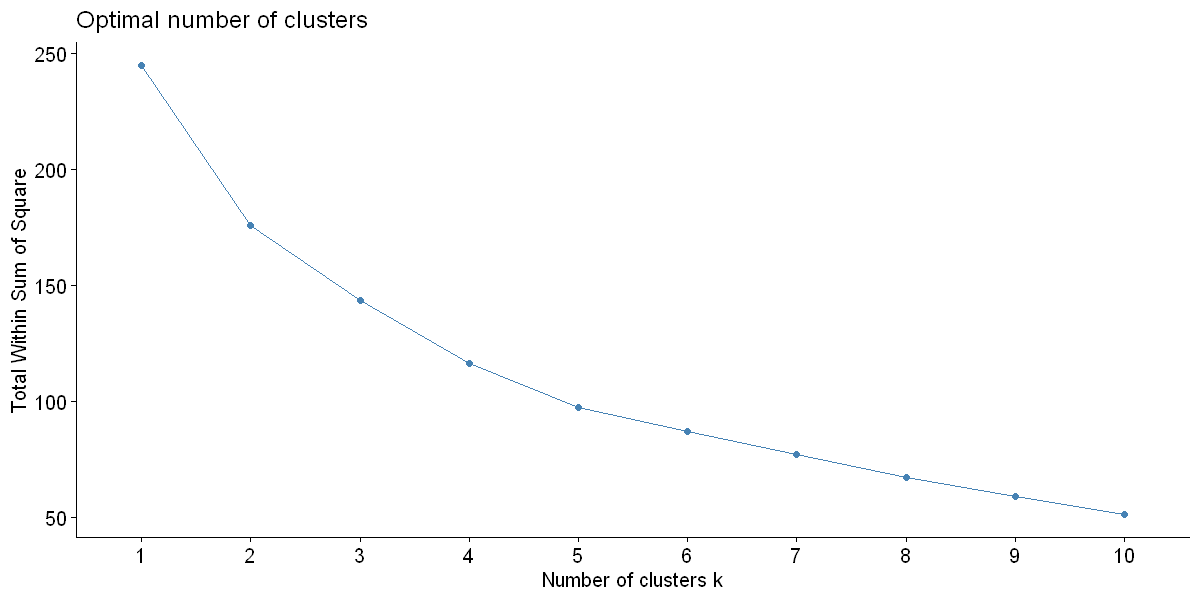

In [66]:
#Méthode du coude
fviz_nbclust(C5.scale, hcut, method = "wss") # méthode de la somme des carrés intra-cluster

<span style="color:salmon"> Il y a 5 clusters qui ressortent  </span>

In [67]:
#Calcul du CAH avec 6 clusters
#hcpc inclu les dimensions de l'ACP
cah.5 <- HCPC(pca.5, method = "ward", nb.clust = 5)

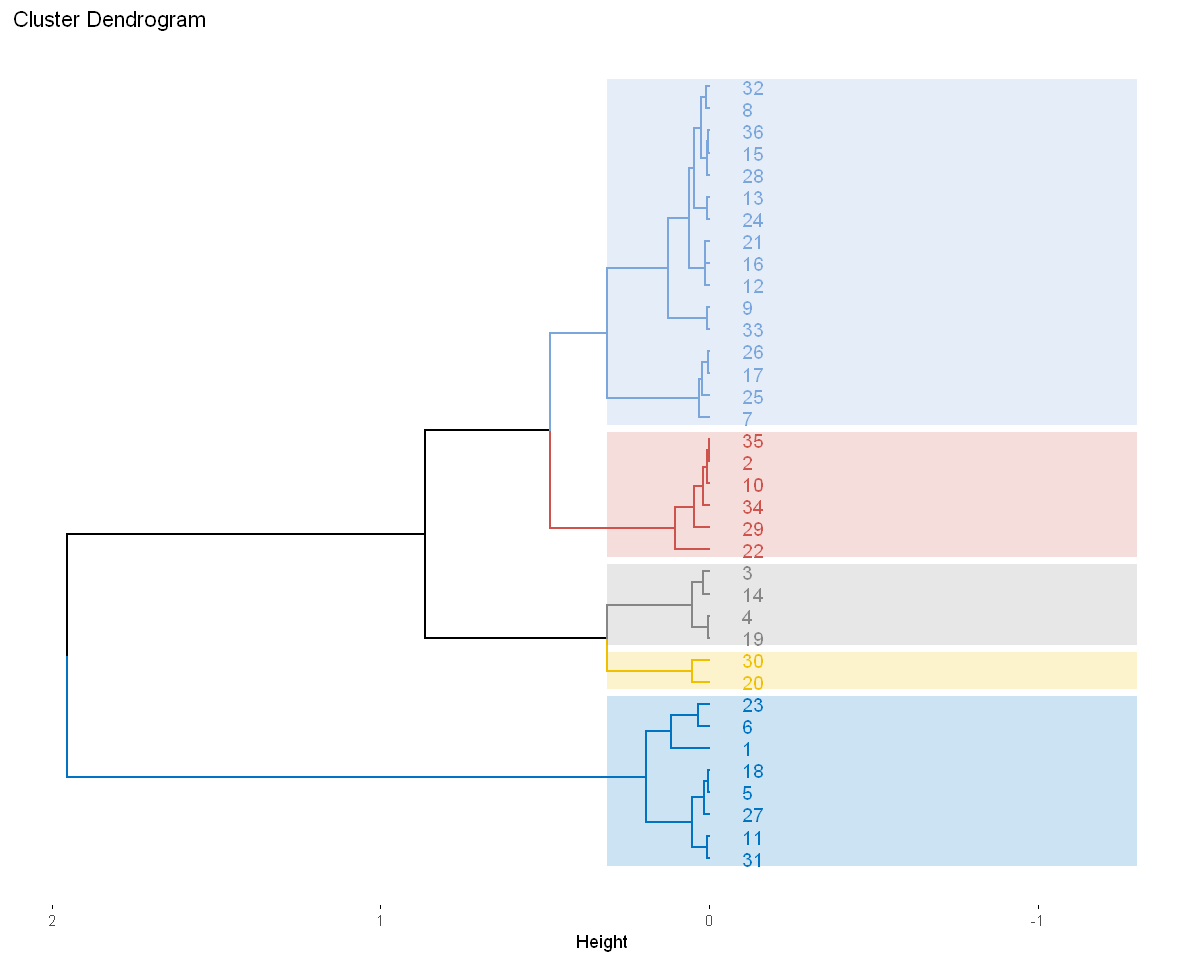

In [79]:
#Un partitionnement initial est effectué.
options(repr.plot.width=10, repr.plot.height=8)
fviz_dend(cah.5, 
          cex = 0.8,                     # Taille du text
          palette = "jco",               # Palette de couleur ?ggpubr::ggpar
          rect = TRUE, rect_fill = TRUE, horiz = TRUE, # Rectangle autour des groupes
          rect_border = "jco",           # Couleur du rectangle
          labels_track_height = 0.8     # Augment l'espace pour le texte
          #ggtheme = theme_classic()     # Thème avec une taille de graphique plus grande
          #ggpar = list(figsize = c(15, 20))# Taille du graphique en pouces)
          )

In [69]:
# Extraire la colonne Zone du fichier C5
Zone.5 <- C5[, 1]
cah.5$data.clust <- cbind(Zone.5, cah.5$data.clust)
cah.5$data.clust

Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Australie,25303574,2151.42,1171442.17,48853.85,72.83,99.00,0.91,5
Autriche,8869561,46427.78,108184.36,54280.68,99.00,99.00,0.93,2
Bahreïn,1475819,56233.44,66754.62,45236.30,90.30,99.00,-0.76,4
Belgique,11503357,211624.76,107409.14,50567.82,87.50,99.00,0.47,4
Canada,37431180,144681.97,1318383.09,48128.88,84.10,99.00,1.05,5
Chili,18980602,131243.79,646989.46,24404.22,76.47,99.00,0.23,5
Chine - RAS de Macao,663228,23137.49,17994.08,110880.00,64.95,99.00,1.27,1
Chypre,1227583,10001.33,27791.64,39698.65,77.07,99.00,0.47,1
Croatie,4127941,13793.18,38717.15,27939.88,69.75,96.55,0.70,1


In [70]:
groupe_5 <- cah.5$data.clust
G1 <- subset(groupe_5, groupe_5$clust==1)
G2 <- subset(groupe_5, groupe_5$clust==2)
G3 <- subset(groupe_5, groupe_5$clust==3)
G4 <- subset(groupe_5, groupe_5$clust==4)
G5 <- subset(groupe_5, groupe_5$clust==5)
groupe_5<-groupe_5[order(groupe_5$clust),]
# Changer le type de la variable clust en entier
groupe_5[, clust := as.integer(clust)]

In [71]:
# Agréger les données par la variable "clust" et calculer la somme de chaque variable
donnees_agreg_g5 <- groupe_5[,2:9][, lapply(.SD, mean), by = clust]
scale_5 <- scale(donnees_agreg_g5)

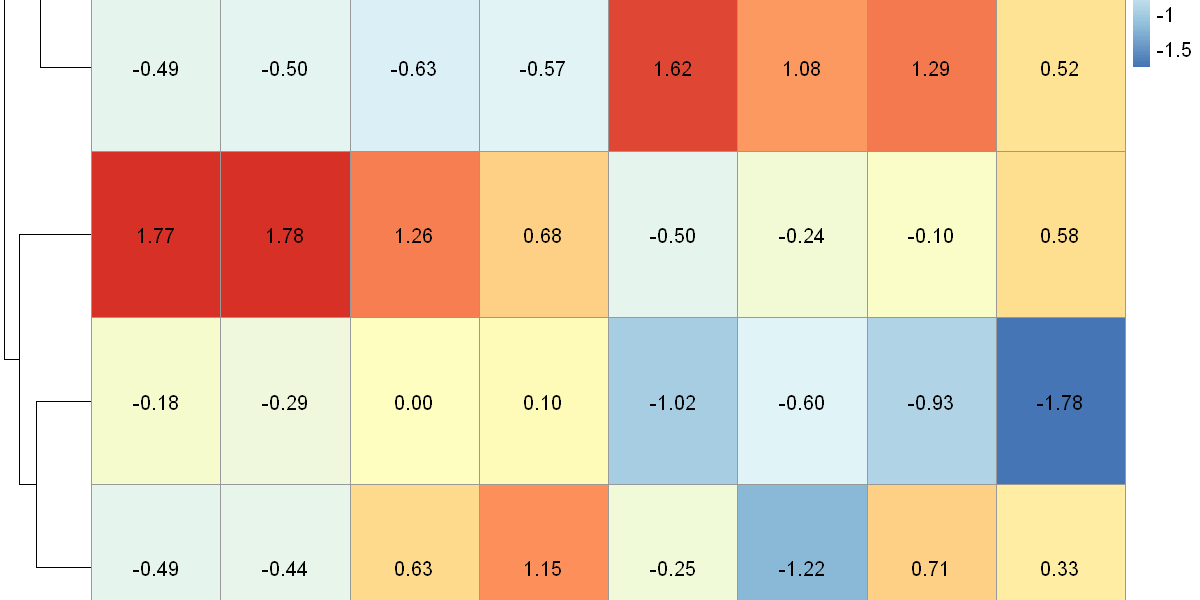

In [72]:
set.seed(5)
pheatmap(scale_5, cellheight = 100, 
         display_numbers = TRUE,
         number_color = "black", 
         fontsize_number = 12, 
         main = "Pheatmap avec CAH clusters pour le groupe 5",
         fontsize = 12)


In [73]:
# Aperçu des groupes qui ressortent du lot
G2
G3

Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Autriche,8869561,46427.78,108184.36,54280.68,99.00,99.0,0.93,2
Danemark,5795945,36509.88,100233.73,56129.28,91.73,99.0,0.94,2
Luxembourg,618777,8012.06,7703.72,114777.75,96.75,97.6,1.32,2
Qatar,2746868,121823.17,146607.73,89510.80,97.20,99.0,0.67,2
Suisse,8574345,30702.32,123879.82,69850.18,99.00,99.0,1.27,2
Suède,10264895,51653.64,135936.34,52018.28,94.88,99.0,1.00,2


Zone,Pop_total,Importation_Qté,Dispo_Poulet,PIB,Pop_Assainissement_sécu,Pop_Assainissement_base,Stabilité_Pol,clust
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Lettonie,1915603,38089.72,40231.42,29947.42,79.95,92.40,0.44,3
Roumanie,19520089,99185.99,343927.17,28616.58,80.65,85.83,0.32,3


Quand on regarde ce heatmap, 2 groupes ressortent du lot également, et ce sont les groupes 2 et 3. Donc parmi ces pays assez confortable au niveau infrastructure:

- Si le plus important pour l'entreprise est le CA, je recommande le groupe 3. Ce sont des pays qui a un fort besoin d'importation de poulet, et en plus le nombre de population est assez conséquente notamment en Roumanie (le marché est grand).
- Si le plus important pour l'entreprise est vraiment la sécurité des employés pour travailler dans un environnement non risqué, dans un pays confortable du point de vue infrastructure, je recommande le groupe 2.